### `Import Libraries and Dataset`

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [4]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization


In [5]:
from scipy.stats import skew, kurtosis
from scipy.stats import norm
from scipy.stats import boxcox


In [6]:
# import dataset
df = pd.read_csv("./data/cardio.csv", delimiter=";", index_col="id")

### `Data Exploration`

In [7]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

Dataset contains 70000 rows and 12 columns.



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  target       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [9]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
target         0
dtype: int64

In [10]:
df.duplicated().sum()

24

In [11]:
df = df.drop_duplicates()

In [12]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69976.000000  69976.000000  69976.000000  69976.000000  69976.000000   
mean   19468.950126      1.349648    164.359152     74.208519    128.820453   
std     2467.374620      0.476862      8.211218     14.397211    154.037729   
min    10798.000000      1.000000     55.000000     10.000000   -150.000000   
25%    17664.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69976.000000  69976.000000  69976.000000  69976.000000  69976.000000   
mean      96.636261      1.366997      1.226535      0.088159      0.053790   
std      188.504581      0.680333      0.572353      0.283528      0.225604   
min      -70.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max    11000.000000      3.000000      3.000000      1.000000      1.000000   

             active        target  
count  69976.000000  69976.000000  
mean       0.803718      0.499771  
std        0.397187      0.500004  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

In [13]:
df["target"].value_counts()

target
0    35004
1    34972
Name: count, dtype: int64

In [14]:
df.groupby("target").mean()

age    gender      height     weight       ap_hi       ap_lo  \
target                                                                          
0       18881.522026  1.345818  164.448377  71.595209  120.433093   84.254114   
1       20056.915733  1.353483  164.269844  76.824219  137.215487  109.029738   

        cholesterol      gluc     smoke      alco    active  
target                                                       
0          1.216632  1.175466  0.092561  0.055451  0.817878  
1          1.517500  1.277651  0.083753  0.052127  0.789546

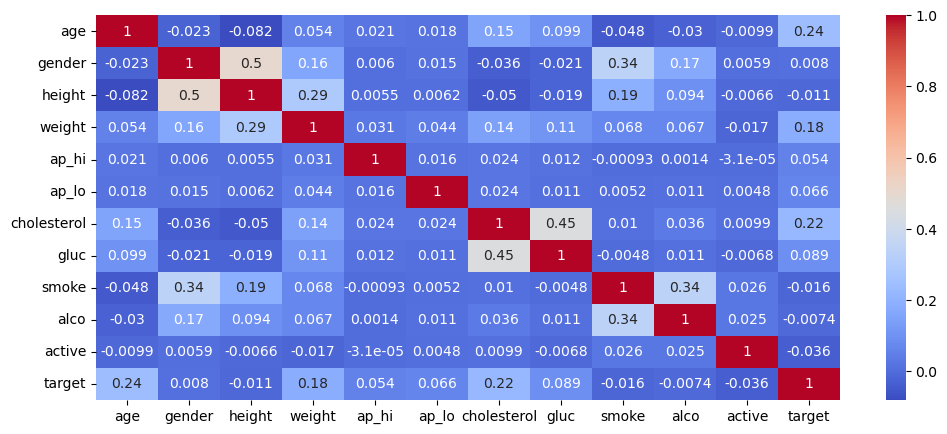

In [15]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

### `Data Preprocessing`

#### `Processing Numerical Features`

##### `Functions`

In [16]:
quant = [0.001, 0.003, 0.005, 0.01, 0.99, 0.995, 0.997, 0.999]

In [17]:
def skew_kurtosis(df, feature_name):
    print(f'{feature_name.upper()}')
    
    # Original feature
    original_skew = skew(df[feature_name])
    original_kurt = kurtosis(df[feature_name])
    print(f"\nOriginal:\nSkewness: {original_skew}, Kurtosis: {original_kurt}\n")
    
    # Square Root Transformation
    sqrt_transformed = np.sqrt(df[feature_name])
    sqrt_skew = skew(sqrt_transformed)
    sqrt_kurt = kurtosis(sqrt_transformed)
    print(f"Square Root Transformation:\nSkewness: {sqrt_skew}, Kurtosis: {sqrt_kurt}\n")
    
    # Log1p Transformation
    log1p_transformed = np.log1p(df[feature_name])
    log1p_skew = skew(log1p_transformed)
    log1p_kurt = kurtosis(log1p_transformed)
    print(f"Log1p Transformation:\nSkewness: {log1p_skew}, Kurtosis: {log1p_kurt}\n")
    
    # Box-Cox Transformation
    # Ensure all values are positive before applying Box-Cox
    df[feature_name] = df[feature_name].apply(lambda x: 1 if x <= 0 else x)  # Replacing non-positive with 1
    boxcox_val, _ = boxcox(df[feature_name])
    boxcox_skew = skew(boxcox_val)
    boxcox_kurt = kurtosis(boxcox_val)
    print(f"Box-Cox Transformation:\nSkewness: {boxcox_skew}, Kurtosis: {boxcox_kurt}\n")


In [18]:
def plot_numerical_feature(df, feature_name):

    plt.figure(figsize=(16, 10))
    
    # 1. Histogram and normal distribution fit
    x = np.linspace(min(df[feature_name]), max(df[feature_name]), 100)
    y = norm.pdf(x, np.mean(df[feature_name]), np.std(df[feature_name]))
    
    plt.subplot(221)
    sns.histplot(df[feature_name], bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} df')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram')
    plt.legend(loc=2)

    # 2. Boxplot
    plt.subplot(222)
    sns.boxplot(x=df[feature_name], color='orange')
    plt.title(f'{feature_name.capitalize()} Outliers - Boxplot')

    # 3. Violin Plot
    plt.subplot(223)
    sns.violinplot(x=df[feature_name], color='purple')
    plt.title(f'{feature_name.capitalize()} Distribution - Violin Plot')

    # 4. Target-Wise Boxplot
    plt.subplot(224)
    sns.boxplot(x='target', y=feature_name, data=df, palette='Set2')
    plt.title(f'{feature_name.capitalize()} by Target - Boxplot')

    plt.tight_layout()
    plt.show()


In [19]:
def check_transform(df, feature_name):
    plt.figure(figsize=(14, 8))

    # 1. Histogram and normal distribution fit (original)
    x = np.linspace(min(df[feature_name]), max(df[feature_name]), 100)
    y = norm.pdf(x, np.mean(df[feature_name]), np.std(df[feature_name]))
    
    plt.subplot(221)
    sns.histplot(df[feature_name], bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (Original)')
    plt.legend(loc=2)

    # 2. Histogram and normal distribution fit (sqrt)
    x = np.linspace(min(np.sqrt(df[feature_name])), max(np.sqrt(df[feature_name])), 100)
    y = norm.pdf(x, np.mean(np.sqrt(df[feature_name])), np.std(np.sqrt(df[feature_name])))
    
    plt.subplot(222)
    sns.histplot(np.sqrt(df[feature_name]), bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (sqrt)')
    plt.legend(loc=2)

    # 3. Histogram and normal distribution fit (log1p)
    x = np.linspace(min(np.log1p(df[feature_name])), max(np.log1p(df[feature_name])), 100)
    y = norm.pdf(x, np.mean(np.log1p(df[feature_name])), np.std(np.log1p(df[feature_name])))
    
    plt.subplot(223)
    sns.histplot(np.log1p(df[feature_name]), bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (log1p)')
    plt.legend(loc=2)

    # 4. Histogram and normal distribution fit (Box-Cox)
    # Apply Box-Cox transformation, ensuring no values <= 0
    df_temp = df.copy()
    df_temp[feature_name] = df_temp[feature_name].apply(lambda x: 1 if x <= 0 else x)  # Replacing non-positive with 1
    boxcox_val, _ = boxcox(df_temp[feature_name])
    
    x = np.linspace(min(boxcox_val), max(boxcox_val), 100)
    y = norm.pdf(x, np.mean(boxcox_val), np.std(boxcox_val))

    plt.subplot(224)
    sns.histplot(boxcox_val, bins=30, color='blue', stat='density', label=f'{feature_name.capitalize()} Data')
    plt.plot(x, y, color="red", lw=3, label="Normal Distribution")
    plt.title(f'{feature_name.capitalize()} Distribution - Histogram (Box-Cox)')
    plt.legend(loc=2)

    plt.tight_layout()
    plt.show()


##### `age`

In [20]:
df['age'].describe()

count    69976.000000
mean     19468.950126
std       2467.374620
min      10798.000000
25%      17664.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

In [21]:
df['age'] = (df['age'] // 365)

In [22]:
df['age'].describe()

count    69976.000000
mean        52.840874
std          6.767103
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

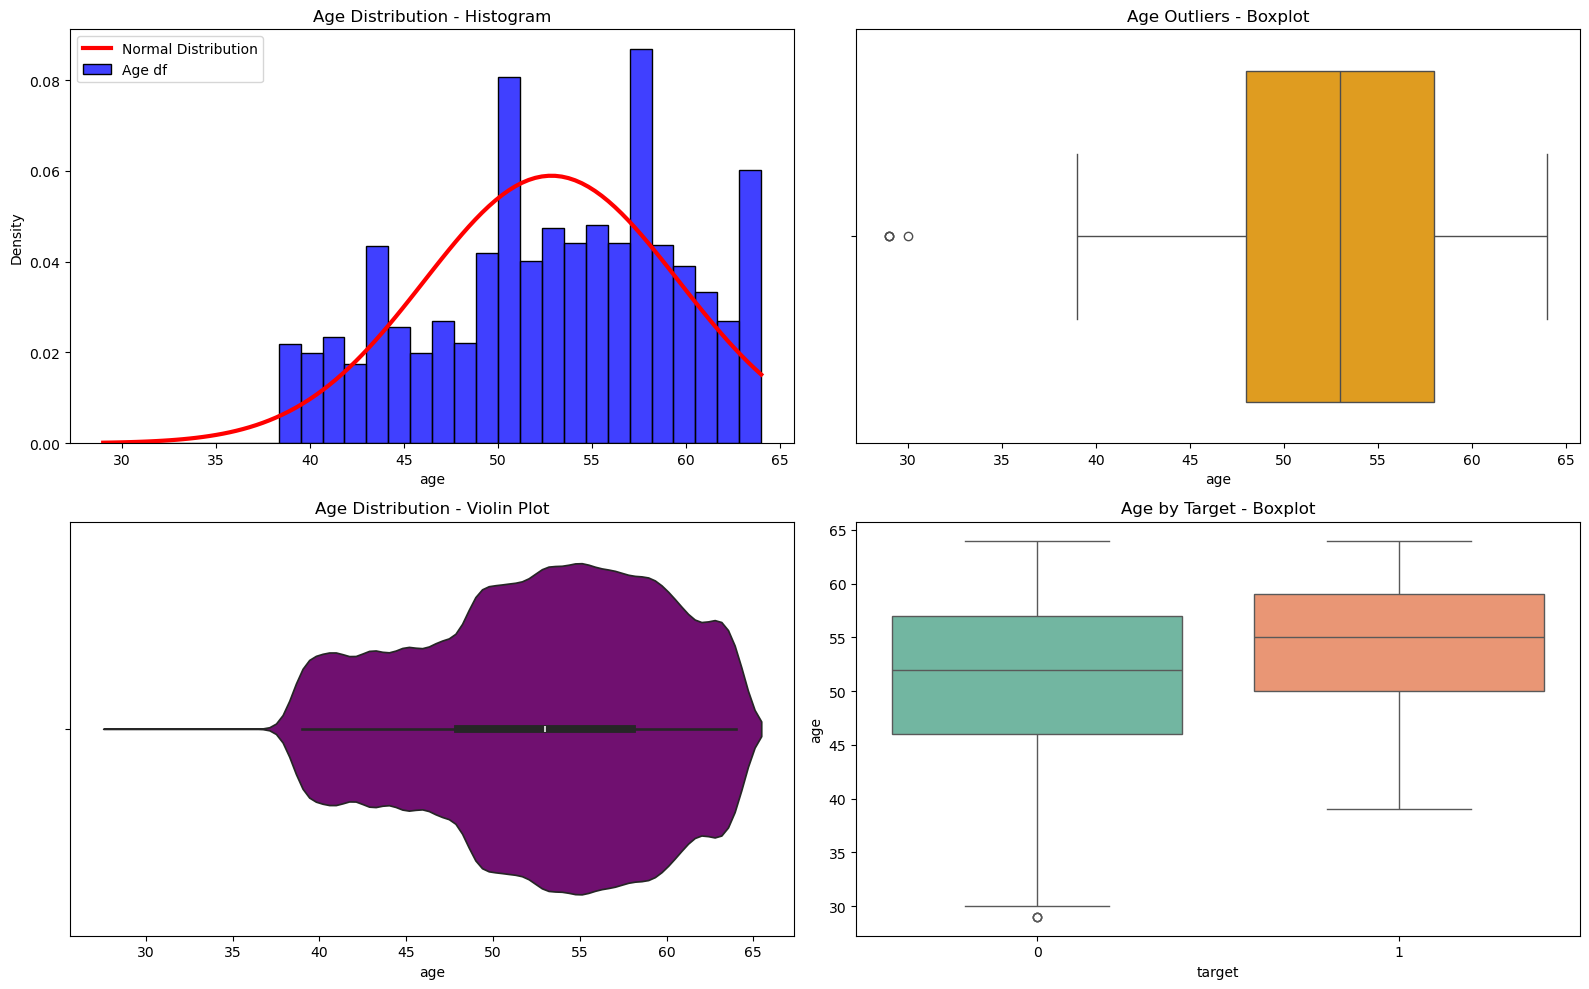

In [23]:
plot_numerical_feature(df, 'age')

In [24]:
print(df['age'].quantile(quant))

0.001    39.0
0.003    39.0
0.005    39.0
0.010    39.0
0.990    64.0
0.995    64.0
0.997    64.0
0.999    64.0
Name: age, dtype: float64


In [25]:
skew_kurtosis(df, 'age')

AGE

Original:
Skewness: -0.30575117719818606, Kurtosis: -0.8190753765766812

Square Root Transformation:
Skewness: -0.4143814232611518, Kurtosis: -0.7270772459212829

Log1p Transformation:
Skewness: -0.5204076328320707, Kurtosis: -0.6118086852266935

Box-Cox Transformation:
Skewness: -0.08700507278490238, Kurtosis: -0.9257176373797709



In [26]:
df[df['age'] < 39]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                           
8850    29       1     175    59.0    120     80            1     1      0   
31922   29       2     175    92.0    100     60            1     1      0   
43842   29       1     159    59.0    120     80            1     1      0   
79749   30       1     160    59.0    110     70            1     1      0   

       alco  active  target  
id                           
8850      0       1       0  
31922     0       1       0  
43842     0       1       0  
79749     0       1       0

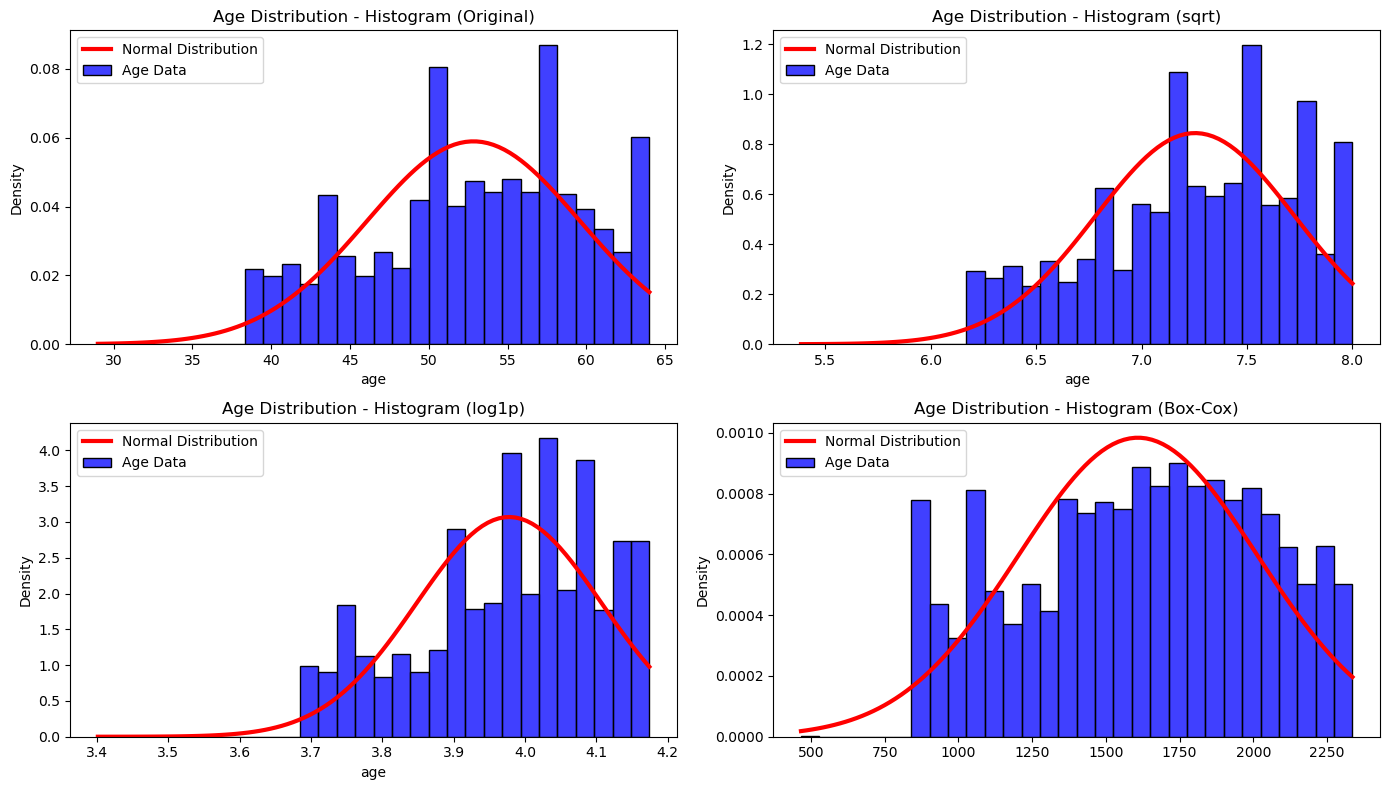

In [27]:
check_transform(df, 'age')

In [28]:
df['age_boxcox'], _ = boxcox(df['age'])

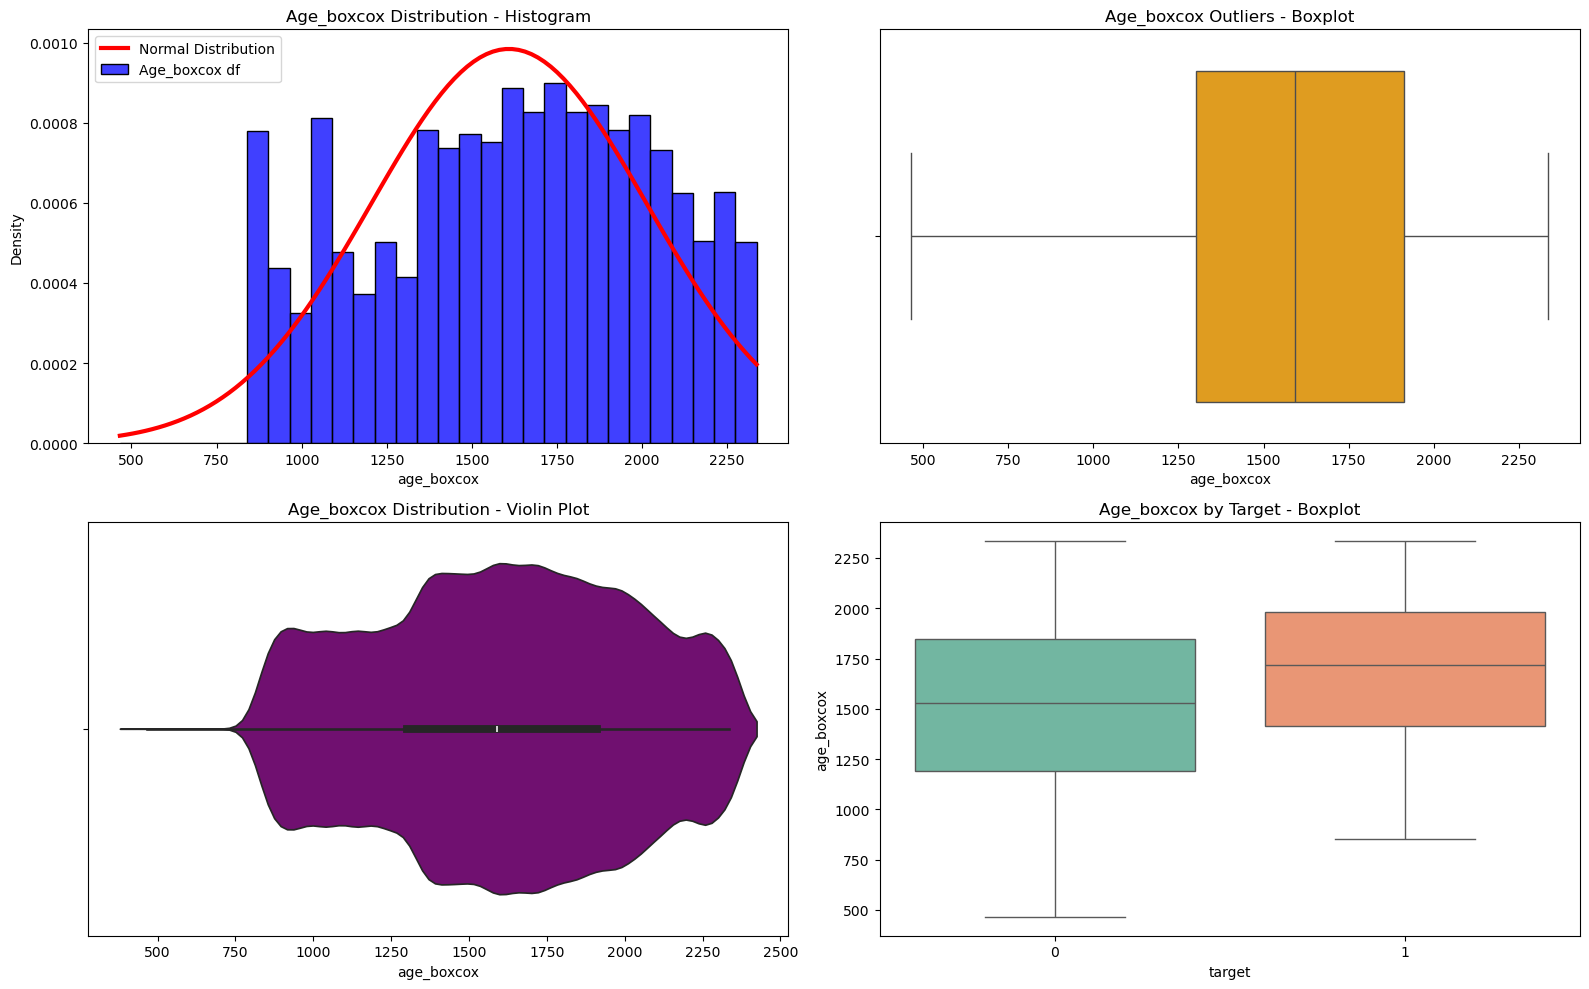

In [29]:
plot_numerical_feature(df, 'age_boxcox')

##### `height`

In [30]:
df['height'].describe()

count    69976.000000
mean       164.359152
std          8.211218
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

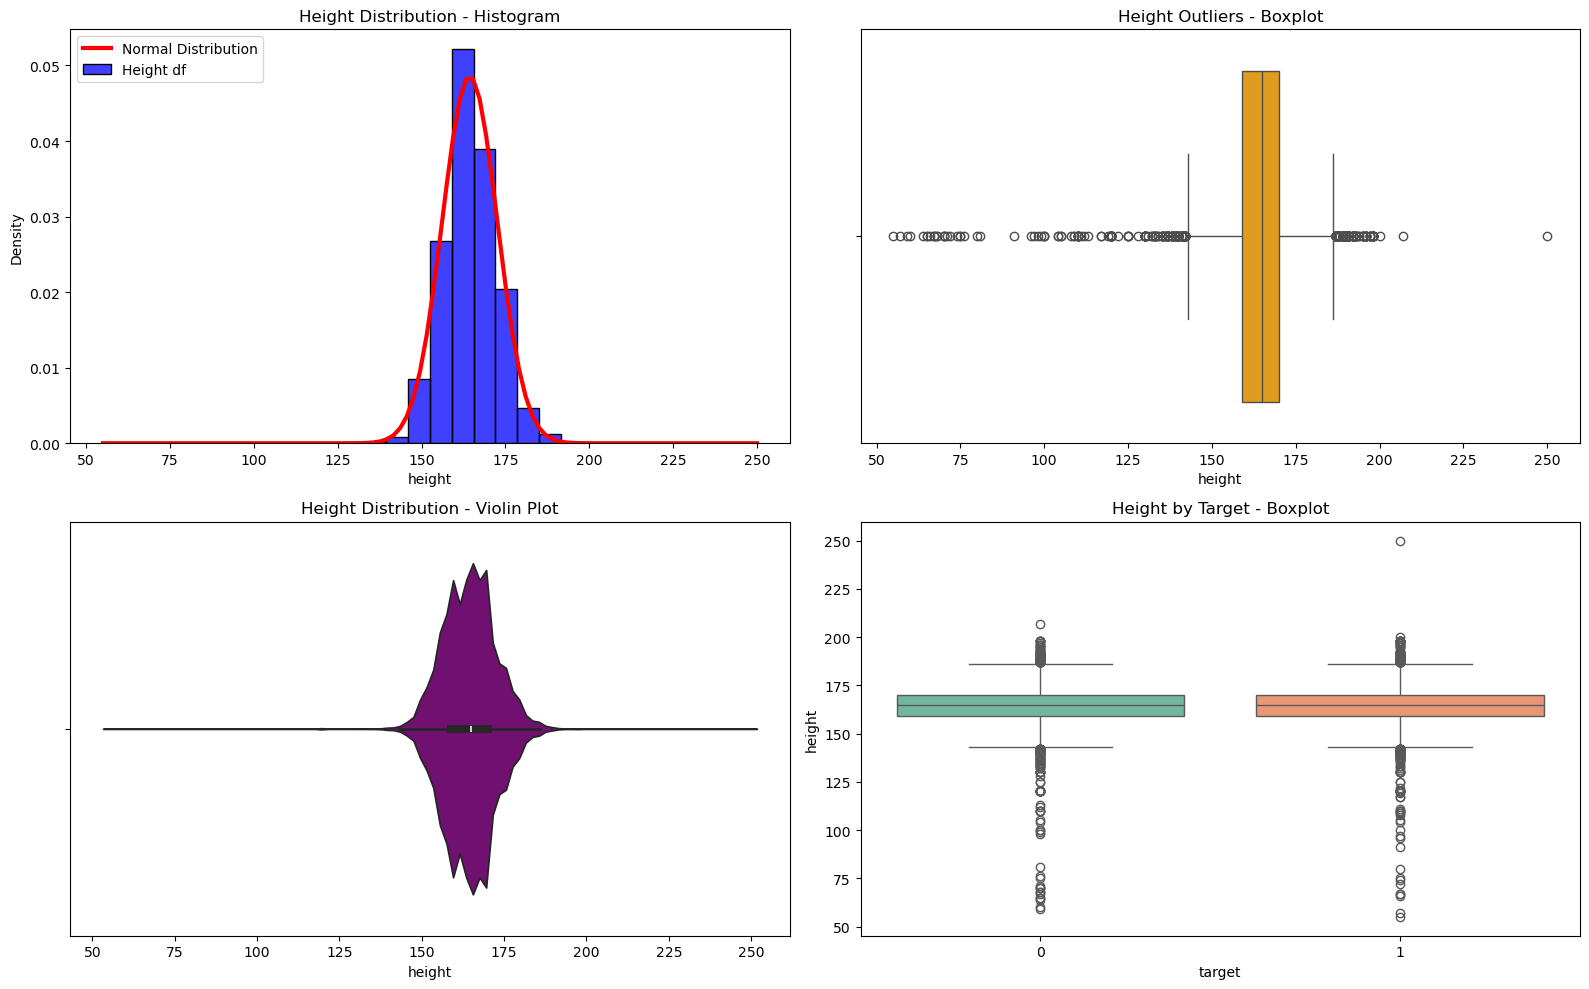

In [31]:
plot_numerical_feature(df, 'height')

In [32]:
print(df['height'].quantile(quant))

0.001    120.0
0.003    141.0
0.005    144.0
0.010    147.0
0.990    184.0
0.995    186.0
0.997    187.0
0.999    190.0
Name: height, dtype: float64


In [33]:
skew_kurtosis(df, 'height')

HEIGHT

Original:
Skewness: -0.6421281441982895, Kurtosis: 7.940842284867994

Square Root Transformation:
Skewness: -1.1893294078936334, Kurtosis: 15.617395525325769

Log1p Transformation:
Skewness: -2.083566756941124, Kurtosis: 32.518126766217755

Box-Cox Transformation:
Skewness: 0.12832593251413454, Kurtosis: 2.372220653085586



In [34]:
df['height'] = df['height'].clip(lower=120, upper=190)
print(df.shape)

(69976, 13)


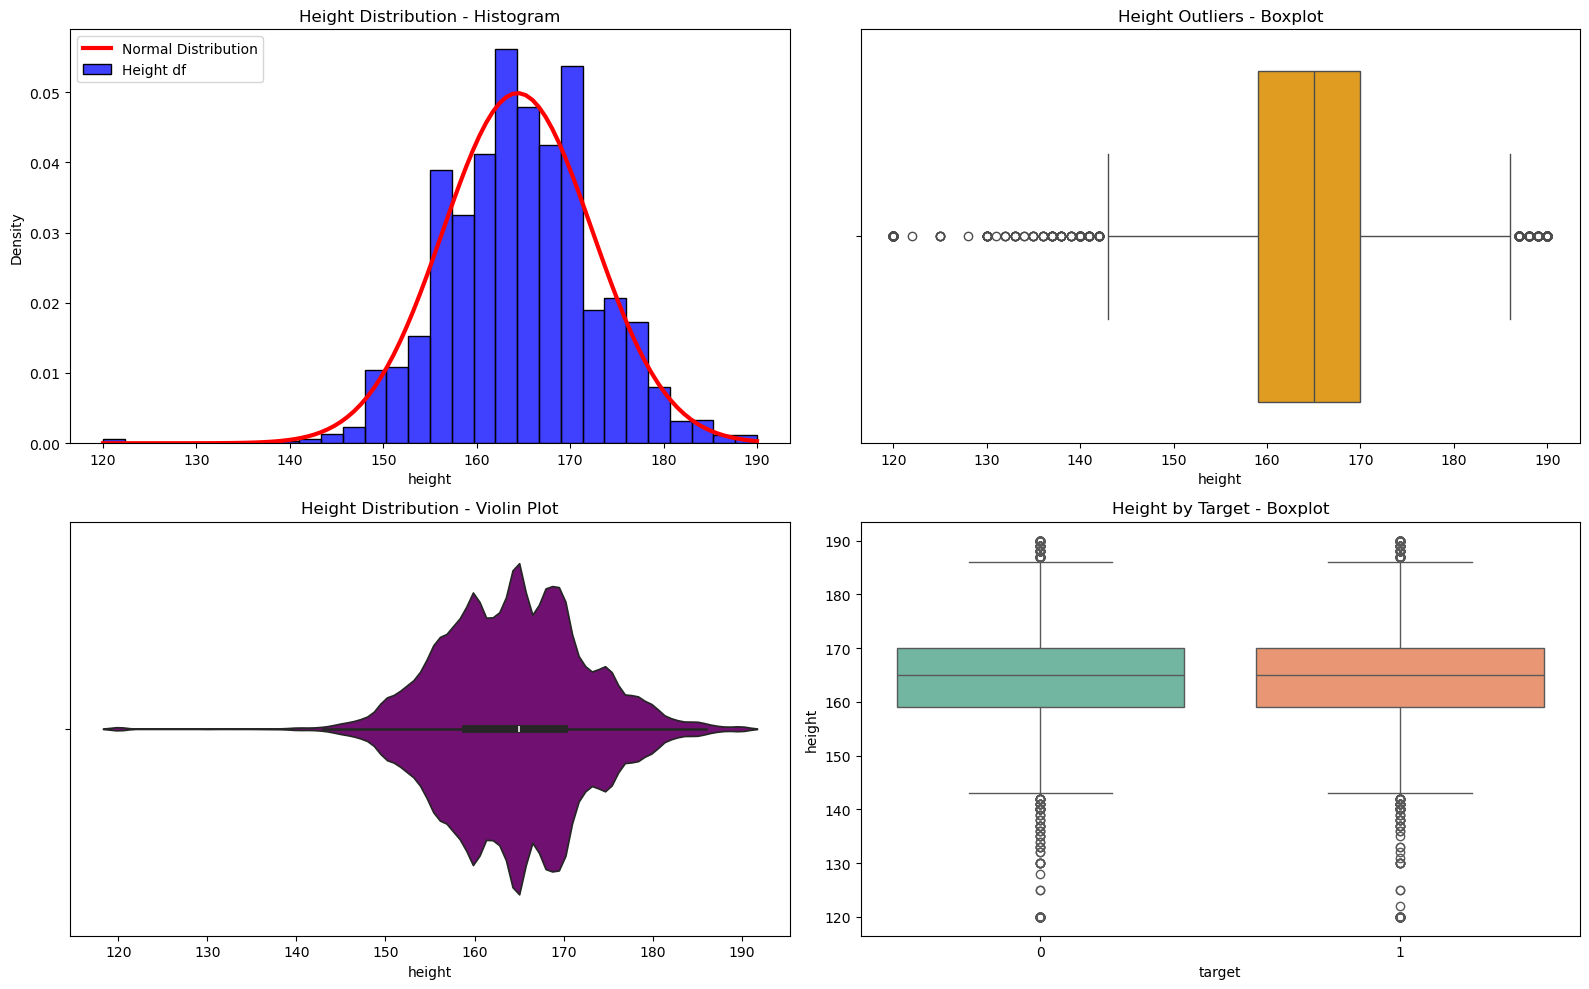

In [35]:
plot_numerical_feature(df, 'height')

In [36]:
skew_kurtosis(df, 'height')

HEIGHT

Original:
Skewness: -0.10880644859911301, Kurtosis: 1.079436309191558

Square Root Transformation:
Skewness: -0.2300437220746021, Kurtosis: 1.4421549375814902

Log1p Transformation:
Skewness: -0.36171440204230226, Kurtosis: 1.9477430699983946

Box-Cox Transformation:
Skewness: 0.024747965860627916, Kurtosis: 0.7937003843348744



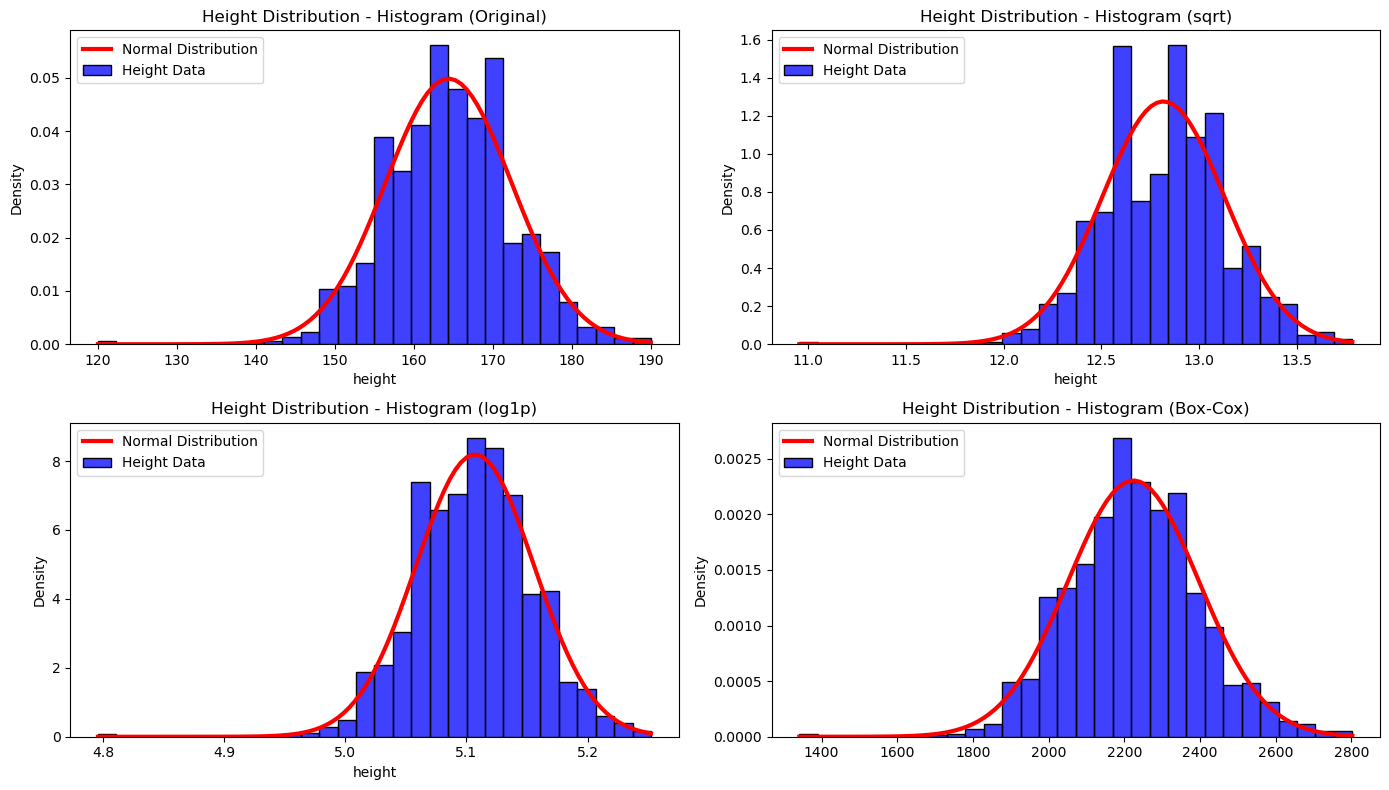

In [37]:
check_transform(df, 'height')

In [38]:
df['height_boxcox'], _ = boxcox(df['height'])

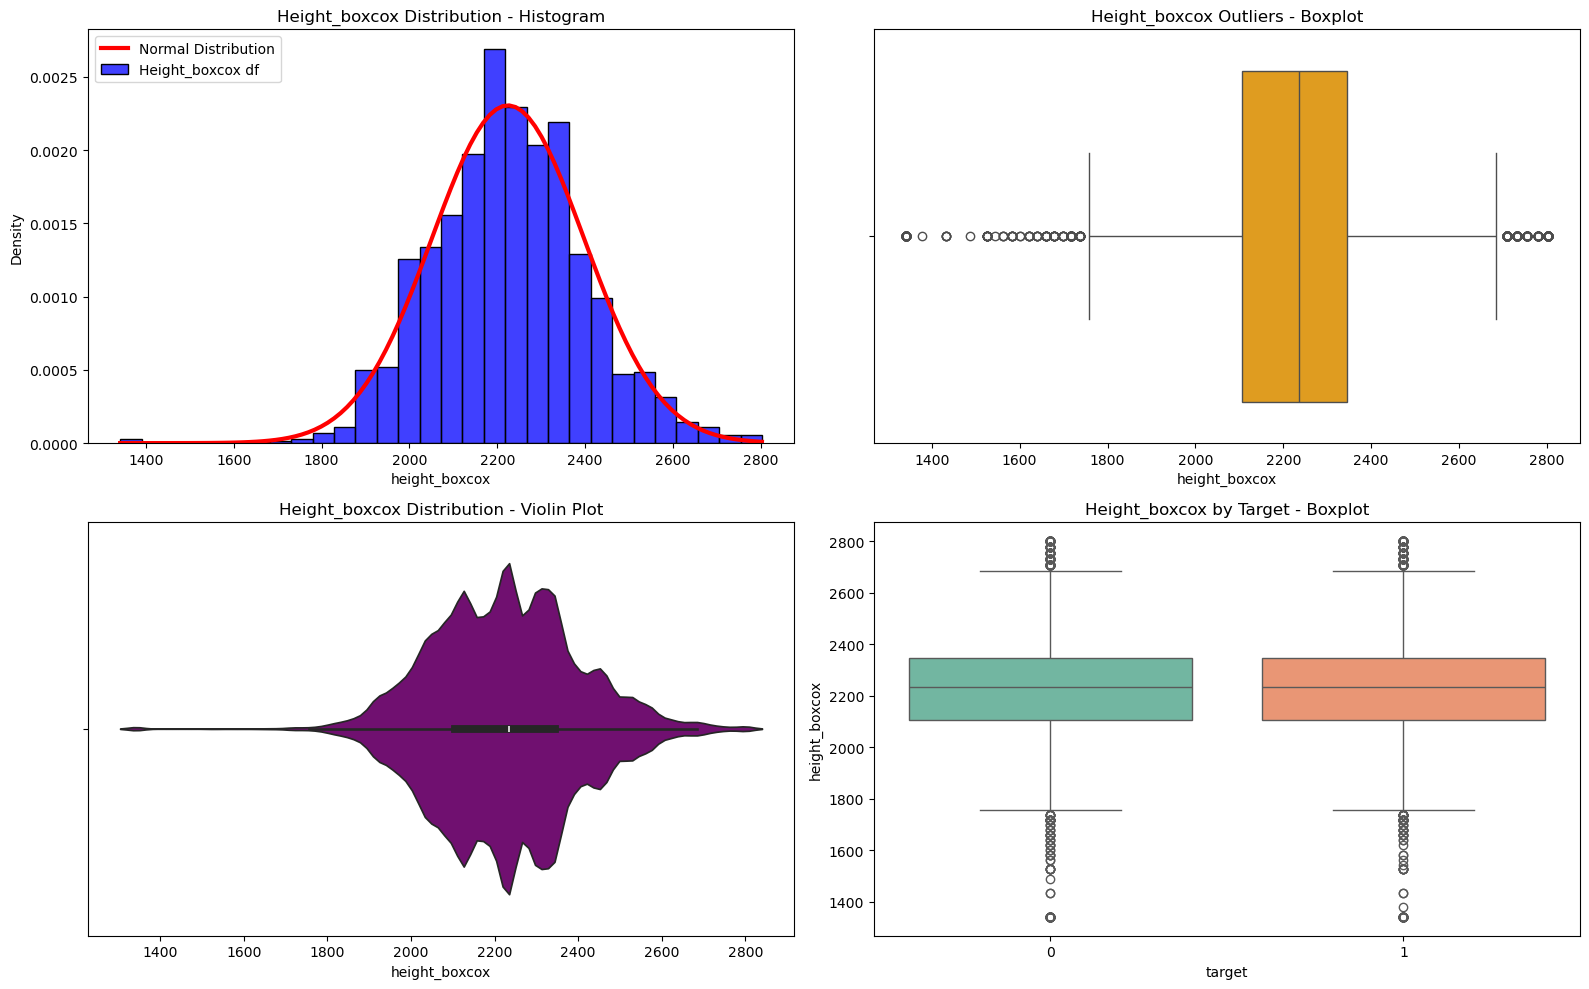

In [39]:
plot_numerical_feature(df, 'height_boxcox')

##### `weight`

In [40]:
df['weight'].describe()

count    69976.000000
mean        74.208519
std         14.397211
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

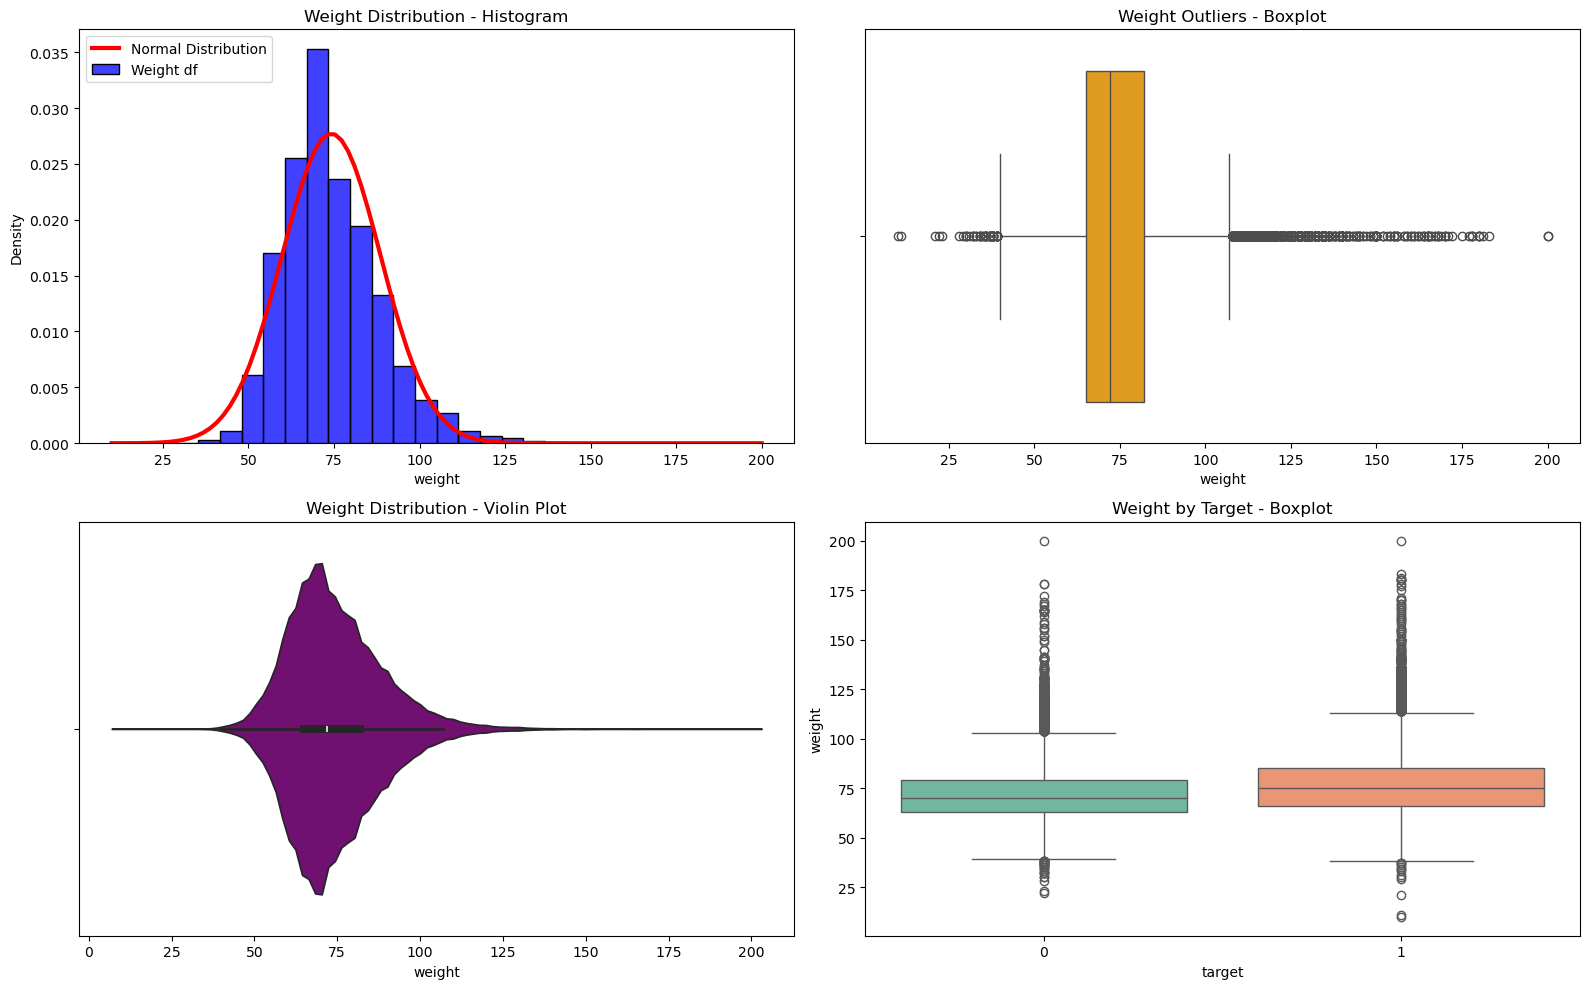

In [41]:
plot_numerical_feature(df, 'weight')

In [42]:
print(df['weight'].quantile(quant))

0.001     40.0
0.003     43.0
0.005     45.0
0.010     48.0
0.990    117.0
0.995    125.0
0.997    130.0
0.999    150.0
Name: weight, dtype: float64


In [43]:
skew_kurtosis(df, 'weight')

WEIGHT

Original:
Skewness: 1.0116111686084681, Kurtosis: 2.5853222905507636

Square Root Transformation:
Skewness: 0.5979025347277006, Kurtosis: 1.2316822527471611

Log1p Transformation:
Skewness: 0.21696550427798197, Kurtosis: 0.9193149440539323

Box-Cox Transformation:
Skewness: -0.021044232892534397, Kurtosis: 1.5463410319348068



In [44]:
df['weight'] = df['weight'].clip(lower=35, upper=150)

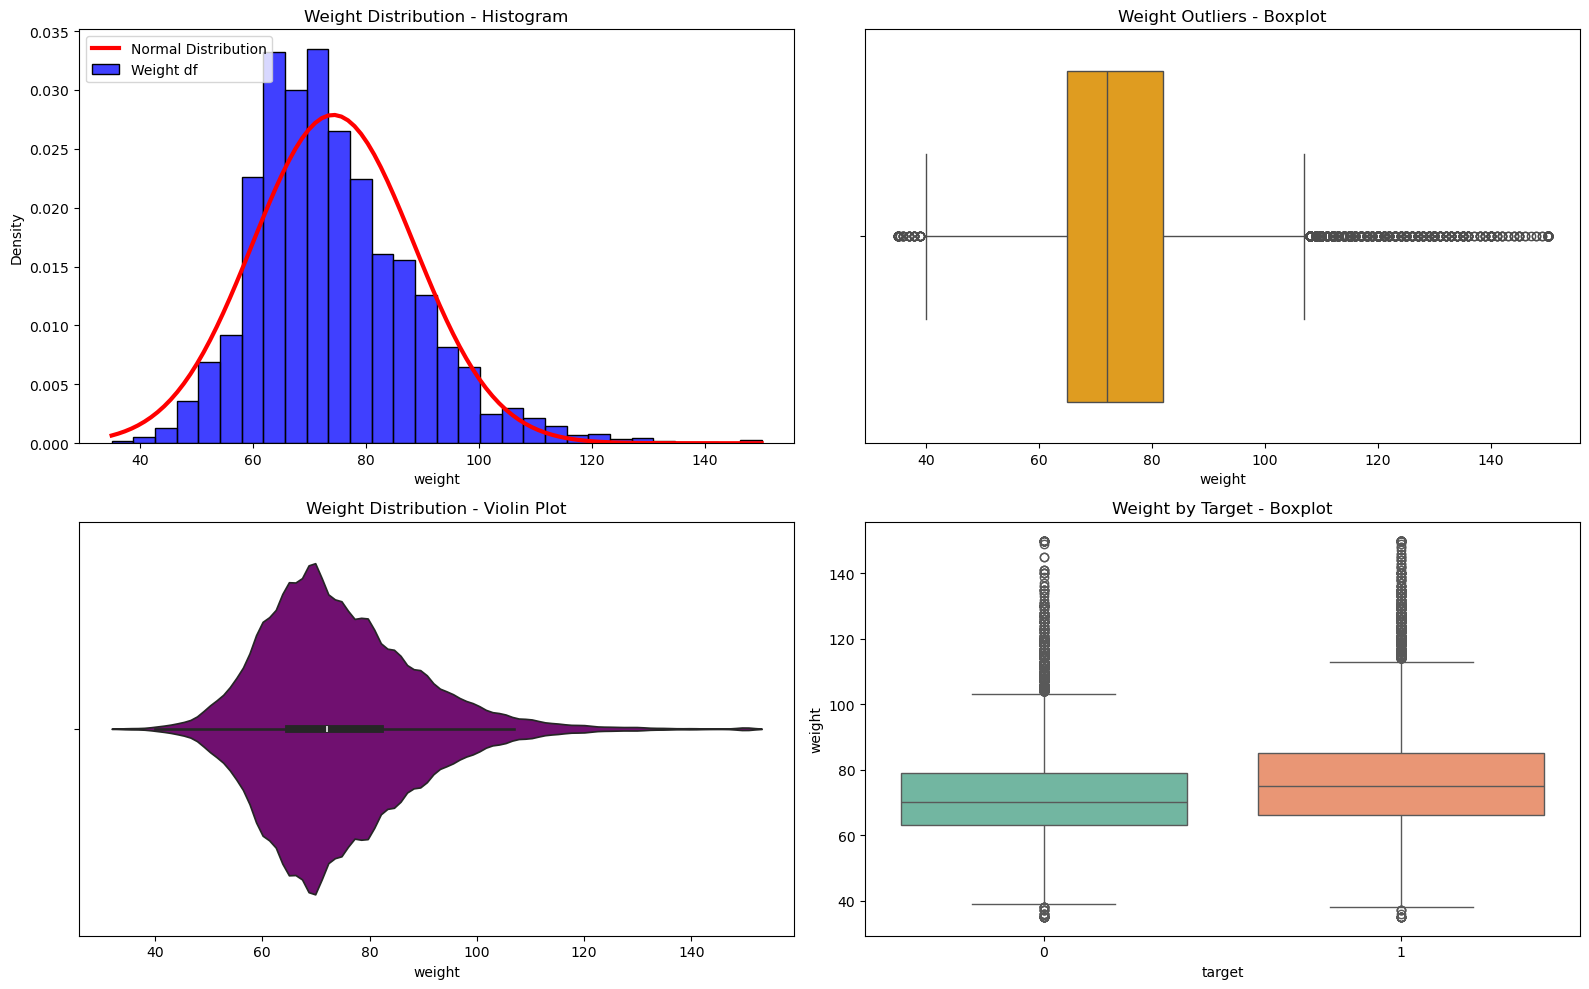

In [45]:
plot_numerical_feature(df, 'weight')

In [46]:
skew_kurtosis(df, 'weight')

WEIGHT

Original:
Skewness: 0.9288451786194468, Kurtosis: 1.8018332811458677

Square Root Transformation:
Skewness: 0.5680563515781226, Kurtosis: 0.86568823659286

Log1p Transformation:
Skewness: 0.23734776806580932, Kurtosis: 0.4503326710369757

Box-Cox Transformation:
Skewness: -0.00879576780706109, Kurtosis: 0.4263115165668947



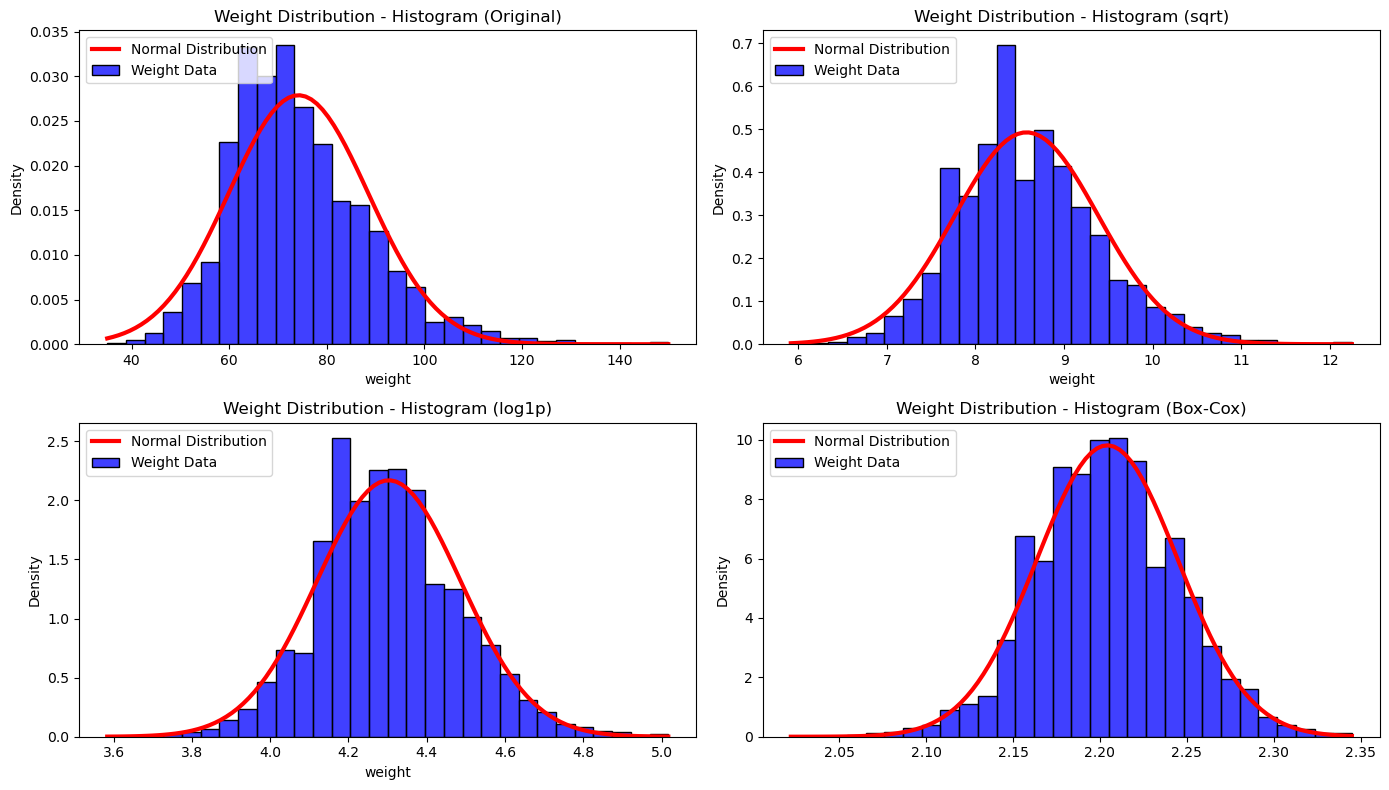

In [47]:
check_transform(df, 'weight')

In [48]:
df['weight_boxcox'], _ = boxcox(df['weight'])

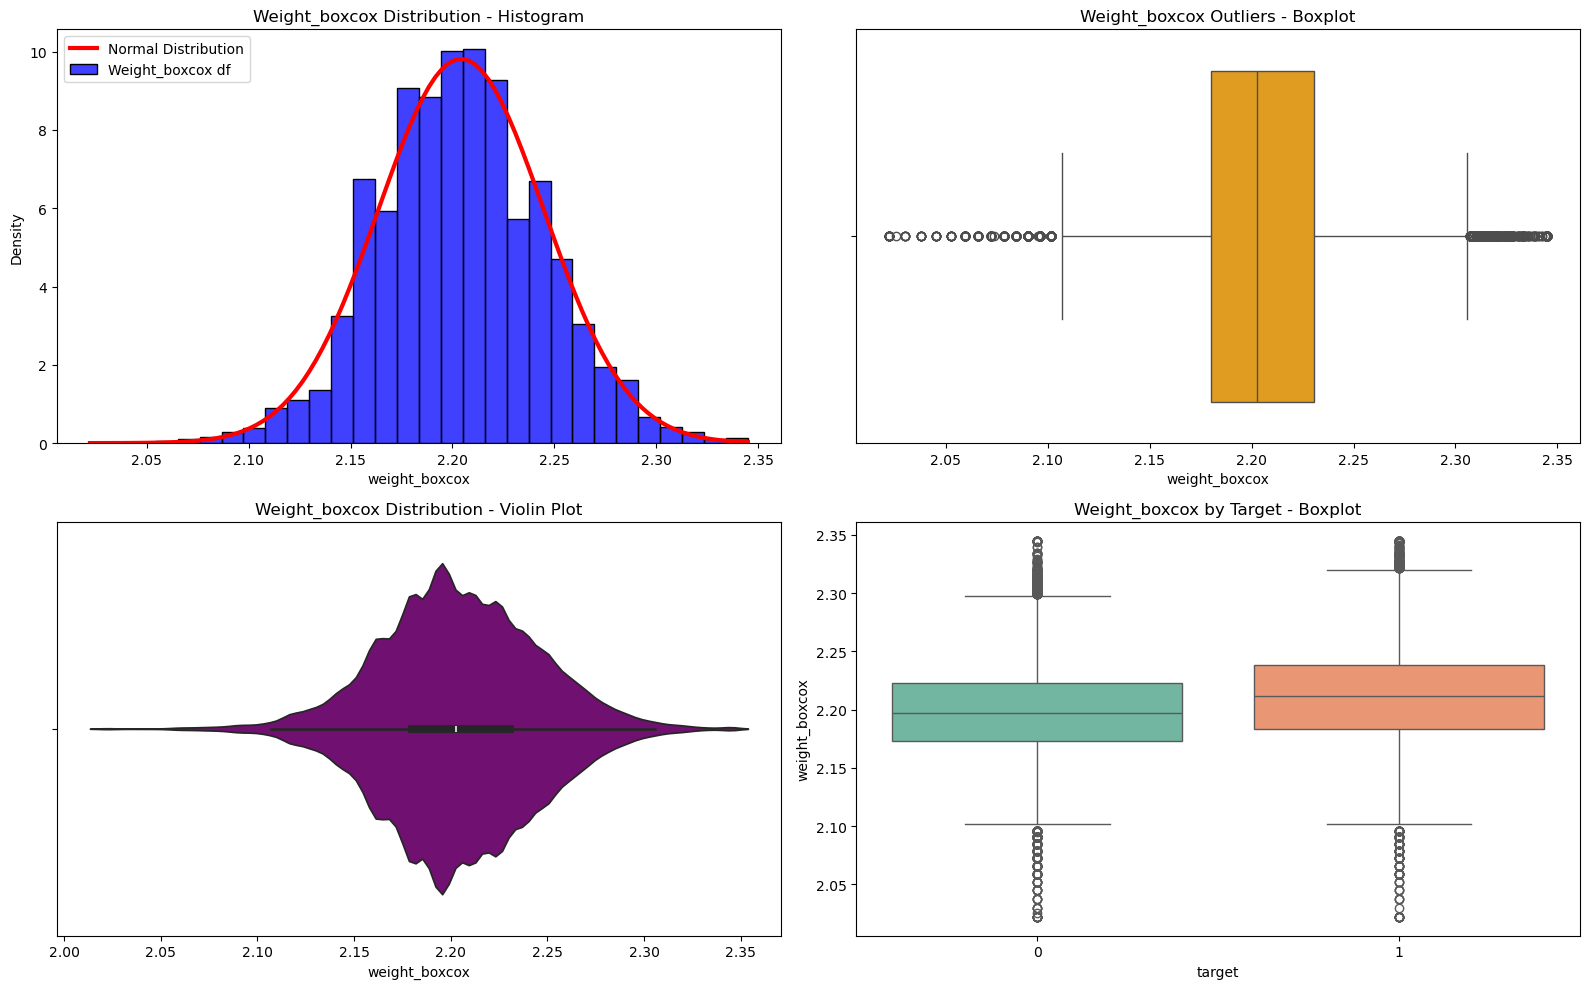

In [49]:
plot_numerical_feature(df, 'weight_boxcox')

##### `ap_hi`

In [50]:
df['ap_hi'].describe()

count    69976.000000
mean       128.820453
std        154.037729
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

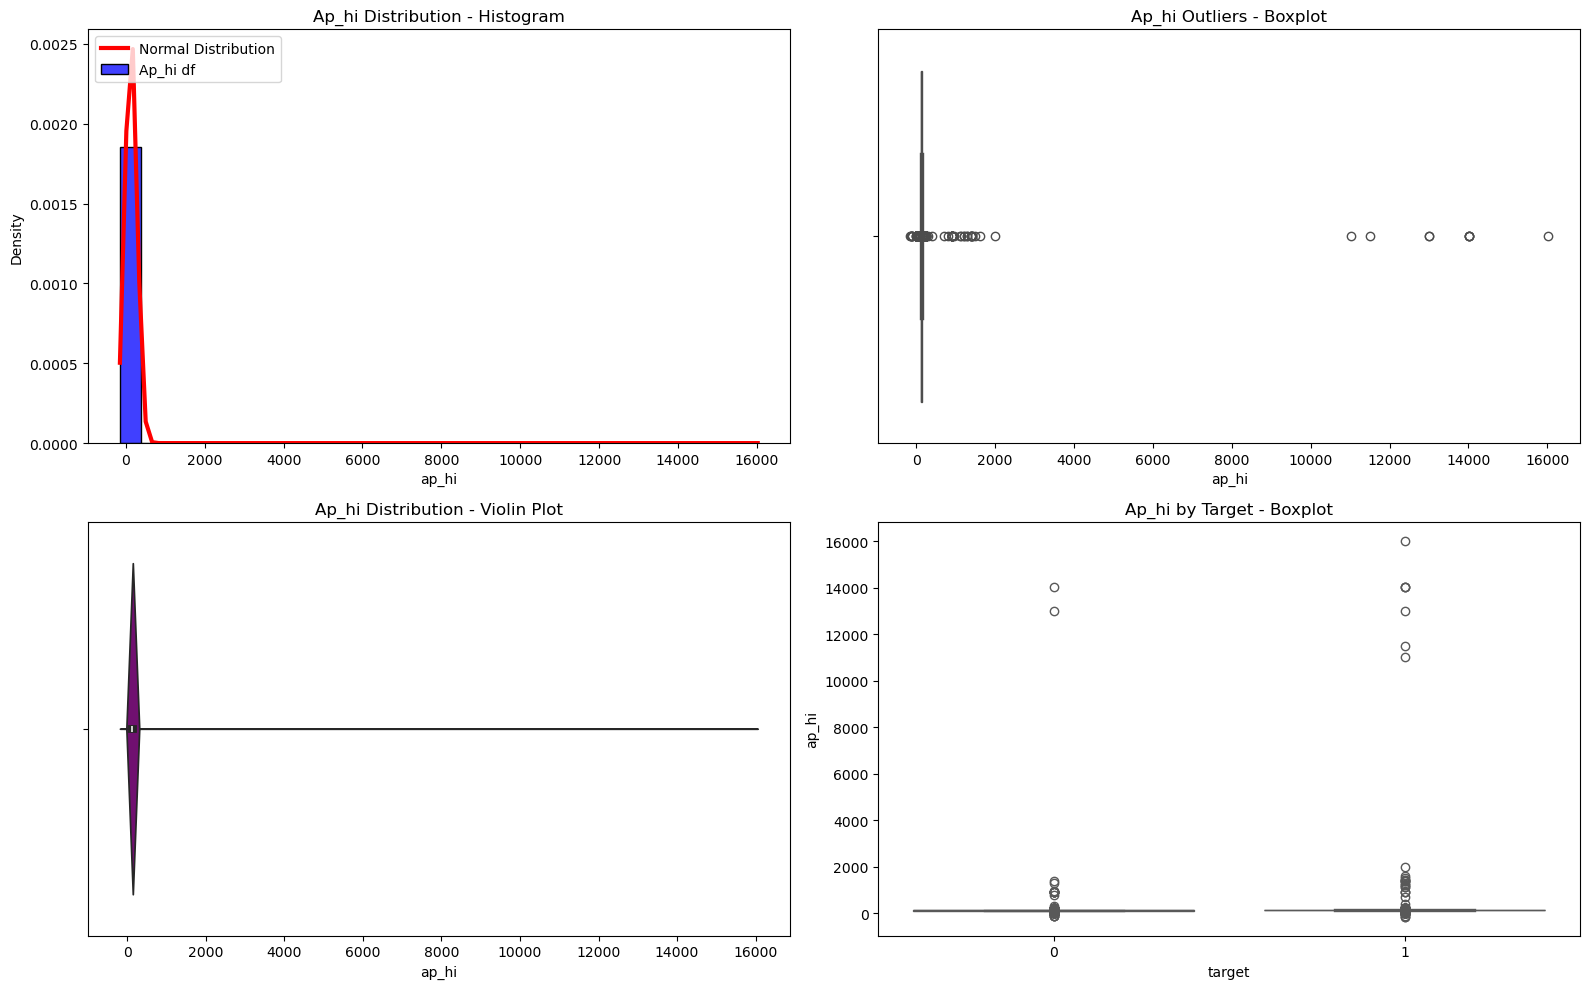

In [51]:
plot_numerical_feature(df, 'ap_hi')

In [52]:
print(df['ap_hi'].quantile(quant))

0.001     12.0
0.003     80.0
0.005     90.0
0.010     90.0
0.990    180.0
0.995    190.0
0.997    200.0
0.999    220.0
Name: ap_hi, dtype: float64


In [53]:
skew_kurtosis(df, 'ap_hi')

AP_HI

Original:
Skewness: 85.27986642707323, Kurtosis: 7576.946055855712

Square Root Transformation:
Skewness: nan, Kurtosis: nan

Log1p Transformation:
Skewness: nan, Kurtosis: nan

Box-Cox Transformation:
Skewness: 1.1837585748904815, Kurtosis: 192.75102805048627



In [54]:
df['ap_hi'] = df['ap_hi'].clip(lower=80, upper=180)

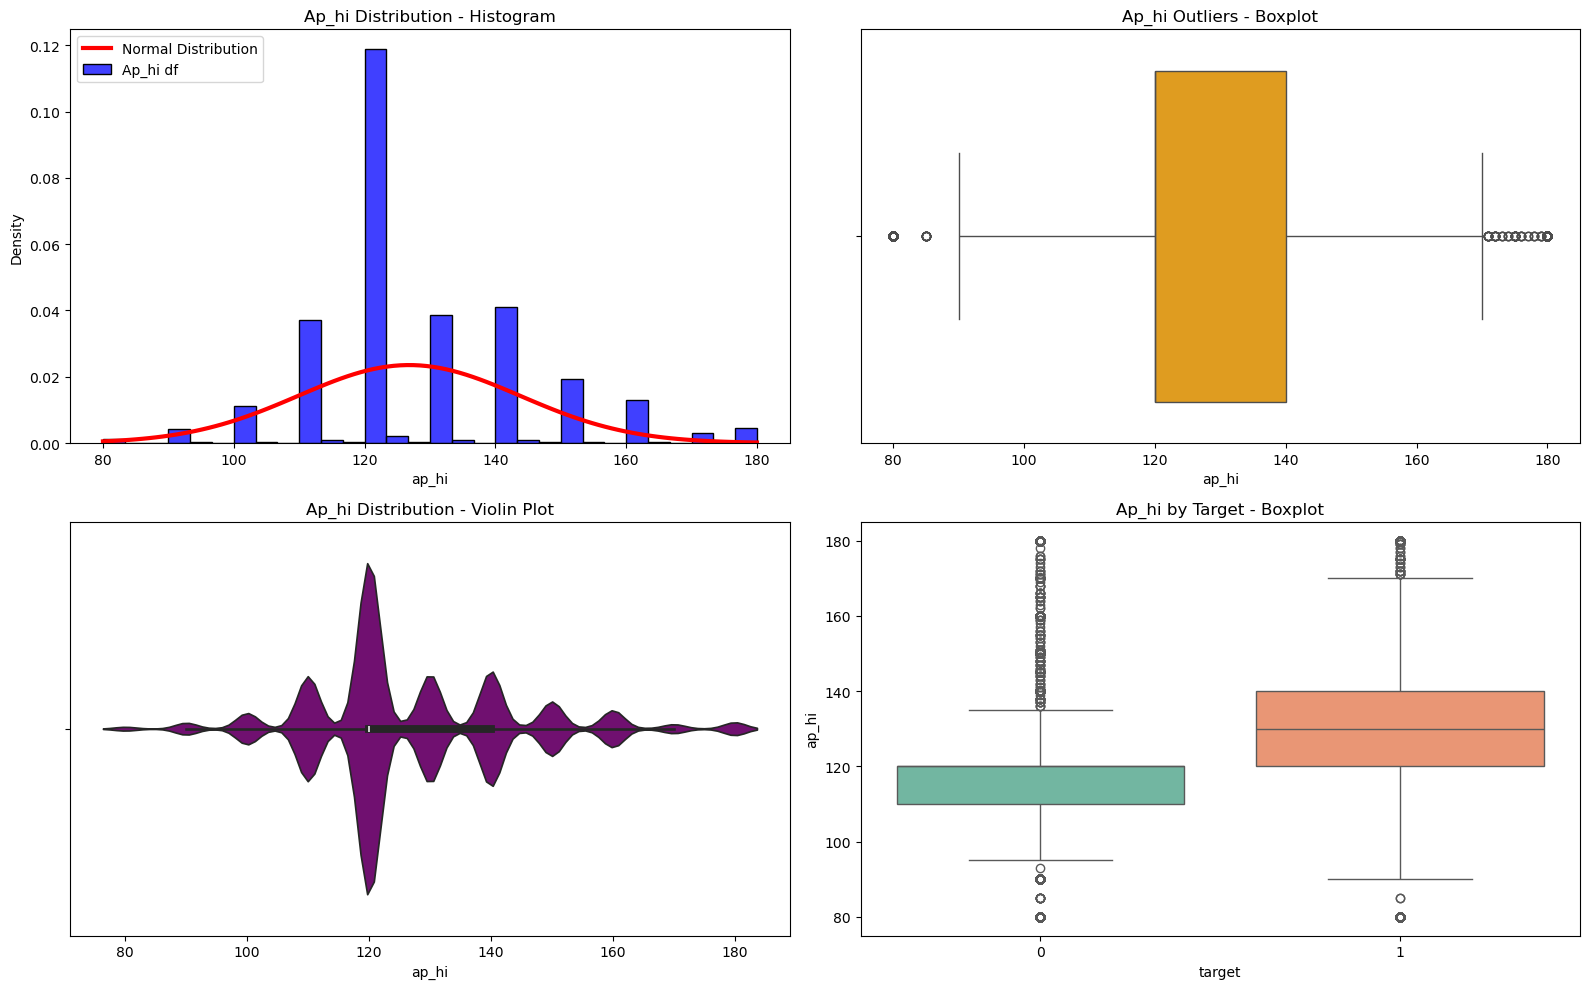

In [55]:
plot_numerical_feature(df, 'ap_hi')

In [56]:
skew_kurtosis(df, 'ap_hi')

AP_HI

Original:
Skewness: 0.697129393990221, Kurtosis: 0.8708564097304374

Square Root Transformation:
Skewness: 0.4569929586588695, Kurtosis: 0.7077453300352801

Log1p Transformation:
Skewness: 0.20564513431417555, Kurtosis: 0.734569307755538

Box-Cox Transformation:
Skewness: -0.014720140408566184, Kurtosis: 0.9223728661601398



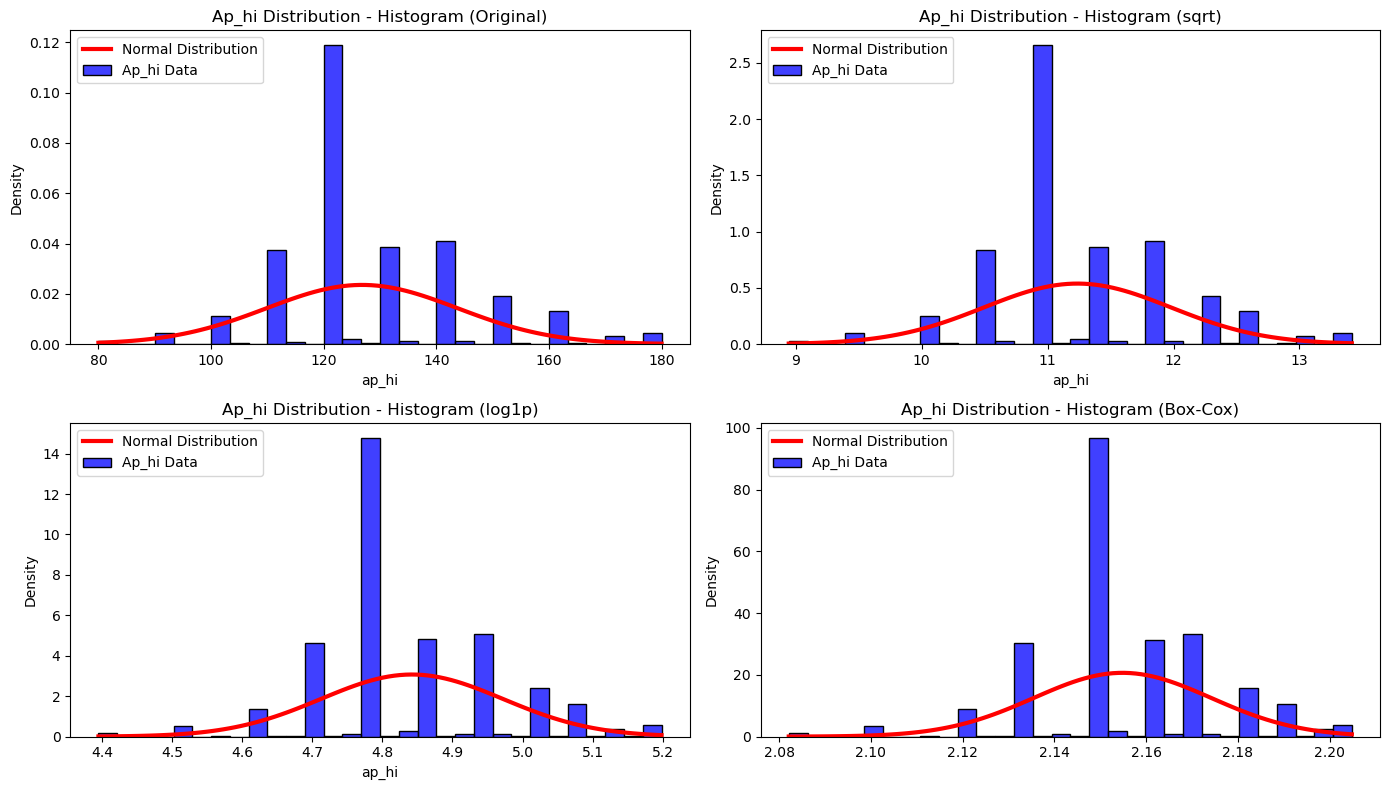

In [57]:
check_transform(df, 'ap_hi')

In [58]:
df['ap_hi_boxcox'], _ = boxcox(df['ap_hi'])

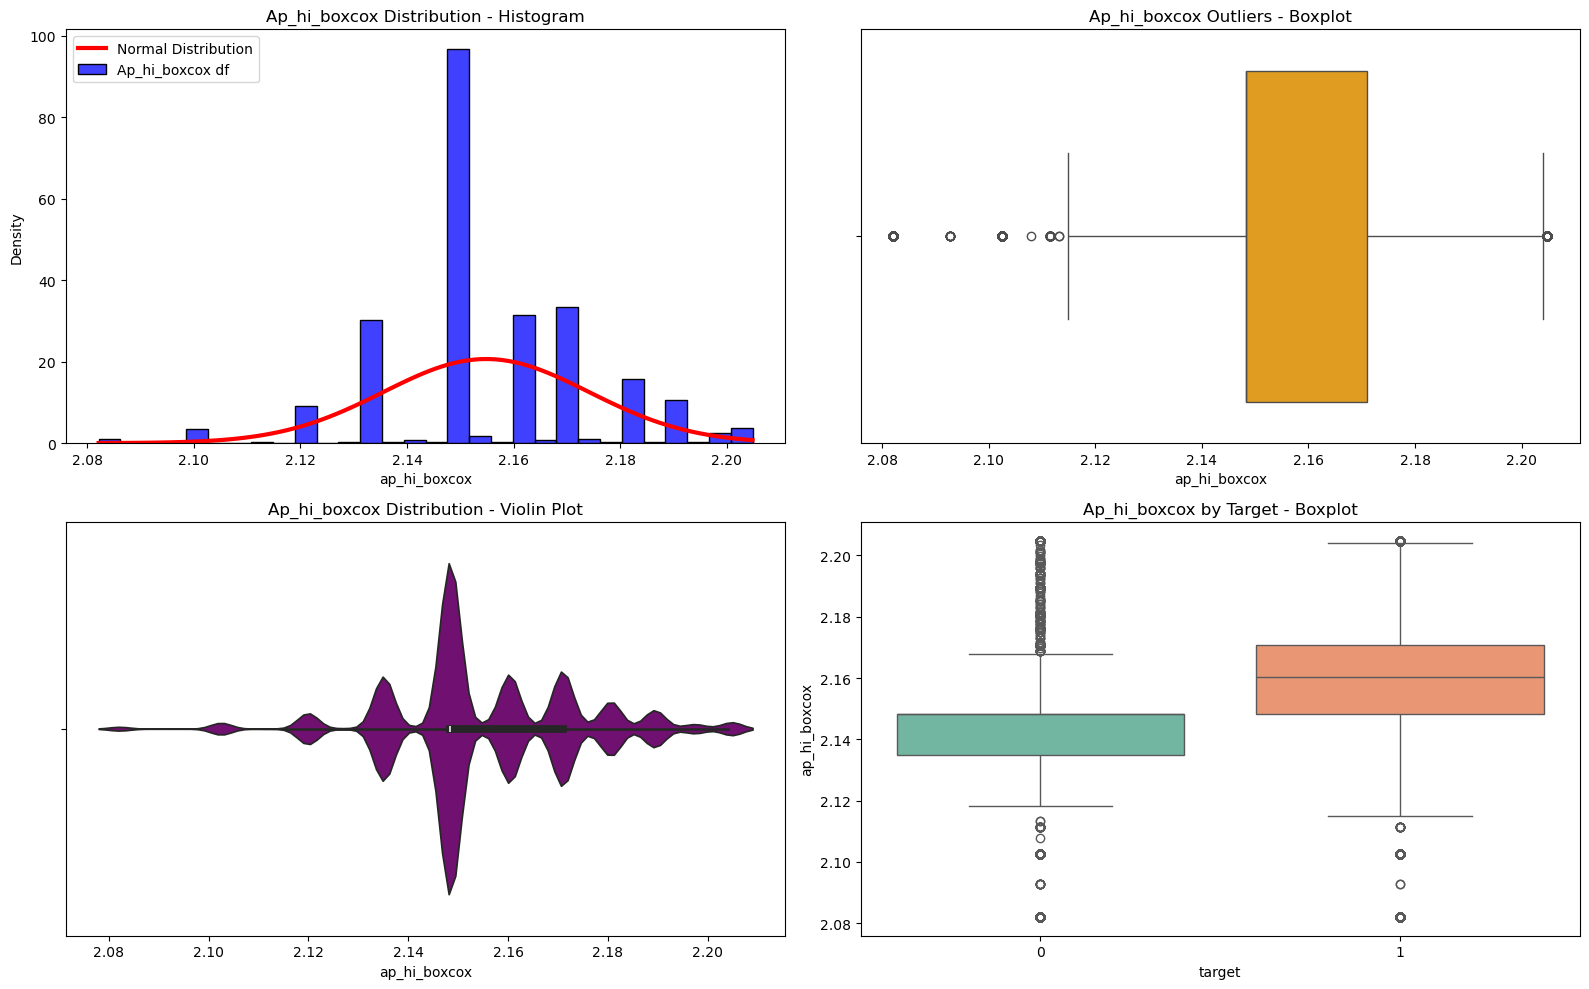

In [59]:
plot_numerical_feature(df, 'ap_hi_boxcox')

##### `ap_lo`

In [60]:
df['ap_lo'].describe()

count    69976.000000
mean        96.636261
std        188.504581
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

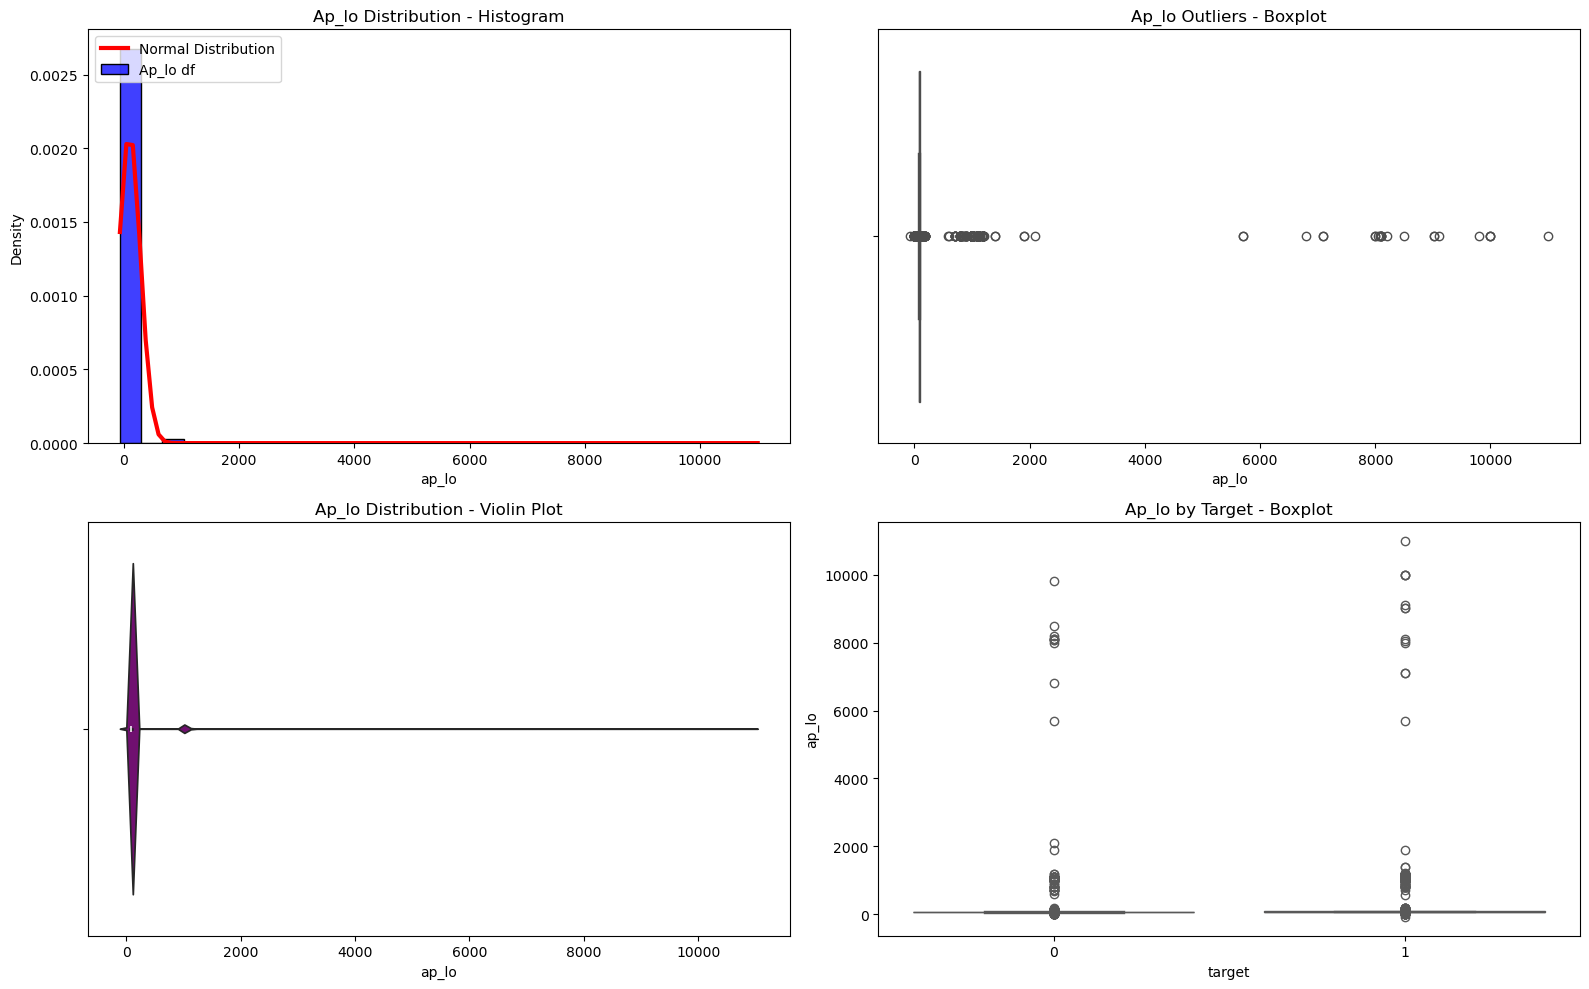

In [61]:
plot_numerical_feature(df, 'ap_lo')

In [62]:
print(df['ap_lo'].quantile(quant))

0.001      40.0
0.003      60.0
0.005      60.0
0.010      60.0
0.990    1000.0
0.995    1000.0
0.997    1100.0
0.999    1110.0
Name: ap_lo, dtype: float64


In [63]:
skew_kurtosis(df, 'ap_lo')

AP_LO

Original:
Skewness: 32.107933256879015, Kurtosis: 1425.3269136648898

Square Root Transformation:
Skewness: nan, Kurtosis: nan

Log1p Transformation:
Skewness: nan, Kurtosis: nan

Box-Cox Transformation:
Skewness: -2.9299697002829324, Kurtosis: 192.9375874128357



In [64]:
df['ap_lo'] = df['ap_lo'].clip(lower=50, upper=120)

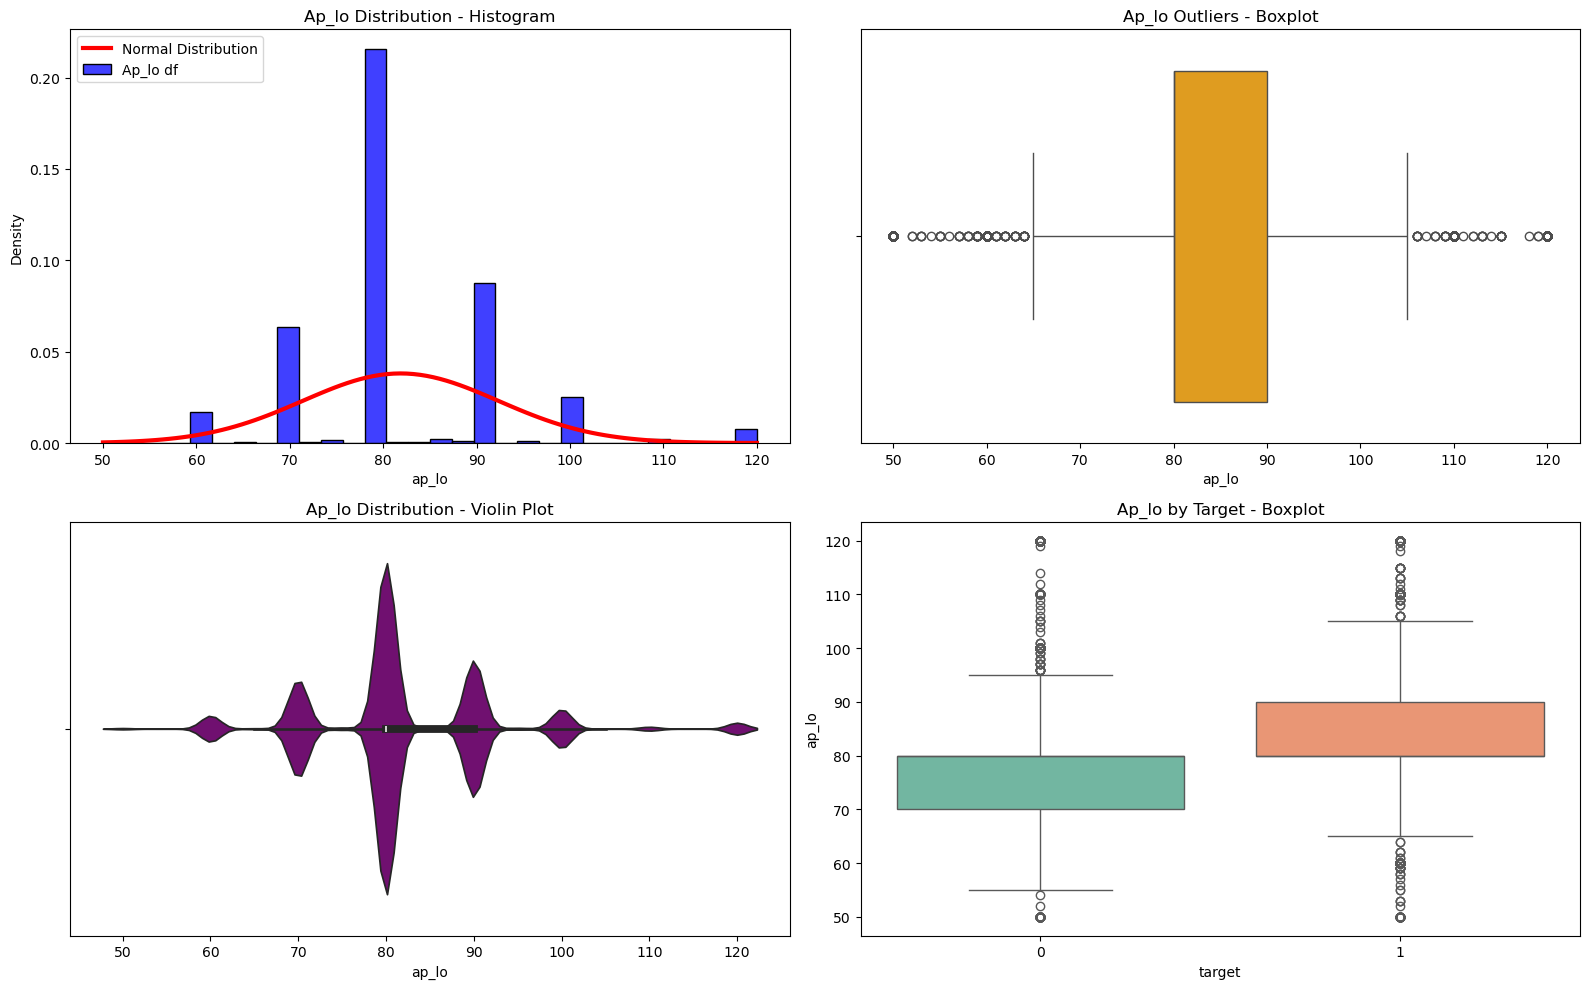

In [65]:
plot_numerical_feature(df, 'ap_lo')

In [66]:
skew_kurtosis(df, 'ap_lo')

AP_LO

Original:
Skewness: 0.7663998844947889, Kurtosis: 2.328603960297202

Square Root Transformation:
Skewness: 0.4276858360842152, Kurtosis: 1.7782537312338276

Log1p Transformation:
Skewness: 0.10187185023575608, Kurtosis: 1.5319044530602044

Box-Cox Transformation:
Skewness: -0.00992682710440851, Kurtosis: 1.5163370445303137



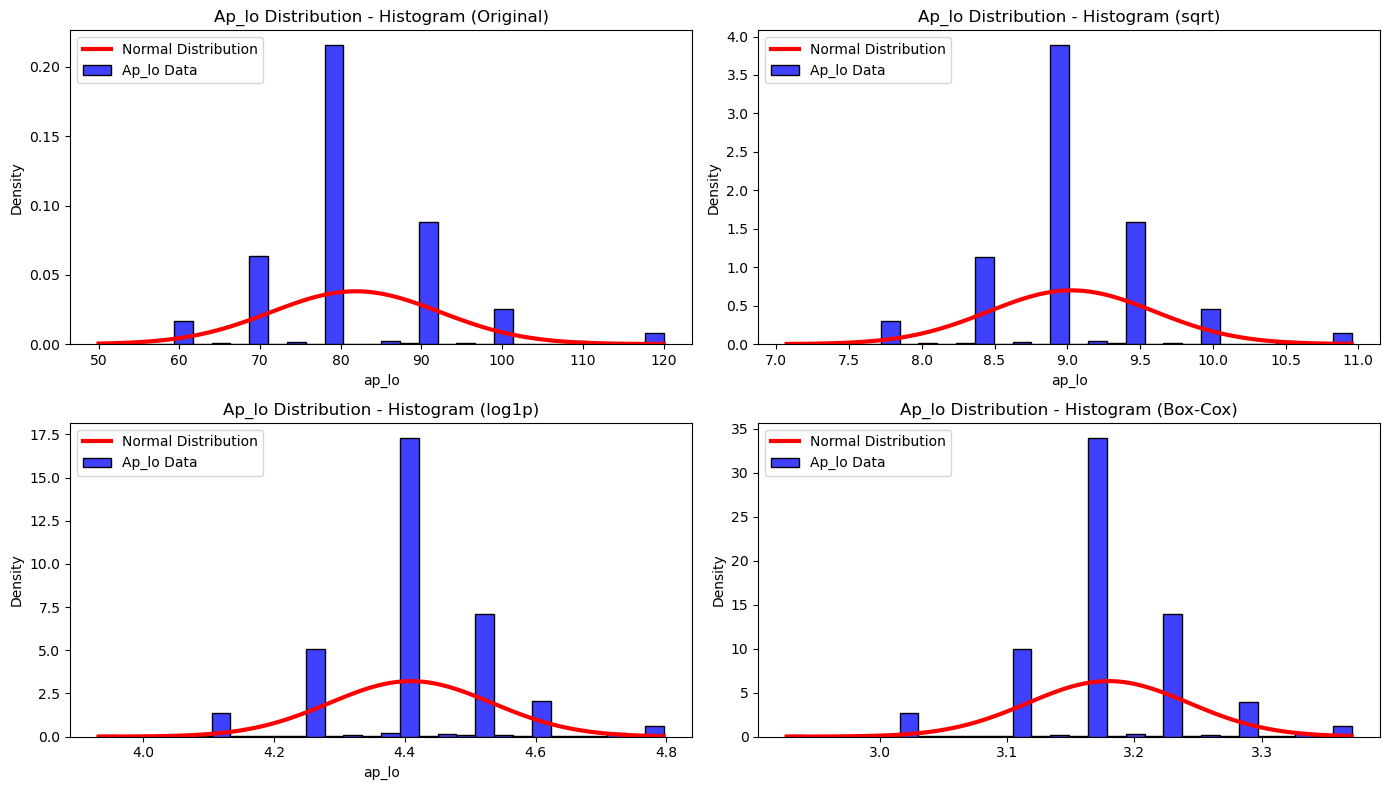

In [67]:
check_transform(df, 'ap_lo')

In [68]:
df['ap_lo_boxcox'], _ = boxcox(df['ap_lo'])

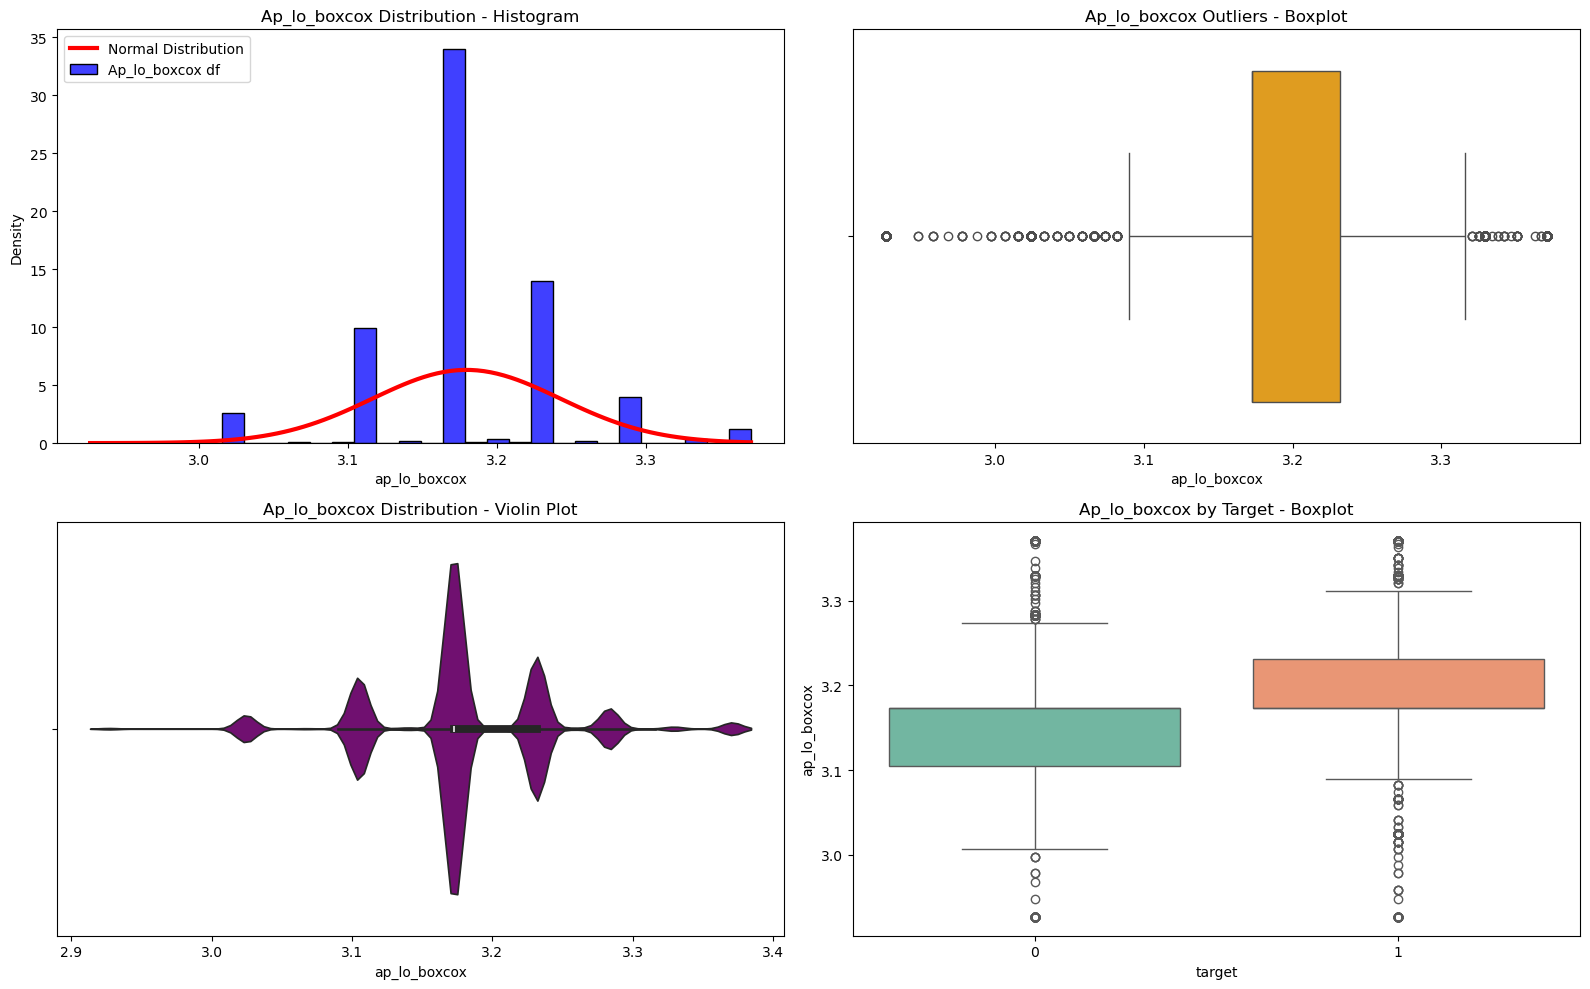

In [69]:
plot_numerical_feature(df, 'ap_lo_boxcox')

#### `Processing Categorical Features`

##### `Functions`

In [70]:
def plot_categorical_feature(df, feature_name, target_column='target'):
    plt.figure(figsize=(14, 10))

    # Frequency bar plot of target=1 proportion in each category
    plt.subplot(2, 2, 1)
    # Calculate the proportion of target=1 within each category
    prop_target_1 = df.groupby(feature_name)[target_column].mean()
    prop_target_1.plot(kind='bar', color='royalblue')
    plt.title(f'Proportion of Target=1 in {feature_name.capitalize()}')
    plt.ylabel('Proportion of Target=1')
    plt.xticks(rotation=45)

    # Frequency bar plot (horizontal)
    plt.subplot(2, 2, 2)
    sns.countplot(data=df, y=feature_name, order=df[feature_name].value_counts().index, palette='viridis')
    plt.title(f'Horizontal Frequency Bar Plot of {feature_name.capitalize()}')
    plt.xlabel('Count')

    # Pie chart
    plt.subplot(2, 2, 3)
    df[feature_name].value_counts().plot.pie(
        autopct='%1.1f%%', startangle=90, counterclock=False, cmap='viridis', explode=[0.05]*len(df[feature_name].unique())
    )
    plt.title(f'Pie Chart of {feature_name.capitalize()}')
    plt.ylabel('')  # Hide y-label for the pie chart

    # Cumulative percentage bar chart
    plt.subplot(2, 2, 4)
    value_counts = df[feature_name].value_counts(normalize=True).cumsum()
    sns.barplot(
        x=value_counts.index, y=value_counts.values, palette='viridis'
    )
    plt.title(f'Cumulative Percentage Bar Plot of {feature_name.capitalize()}')
    plt.ylabel('Cumulative Percentage')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


##### `gender`

In [71]:
df["gender"] = df["gender"] - 1

In [72]:
print(df["gender"].value_counts())

gender
0    45509
1    24467
Name: count, dtype: int64


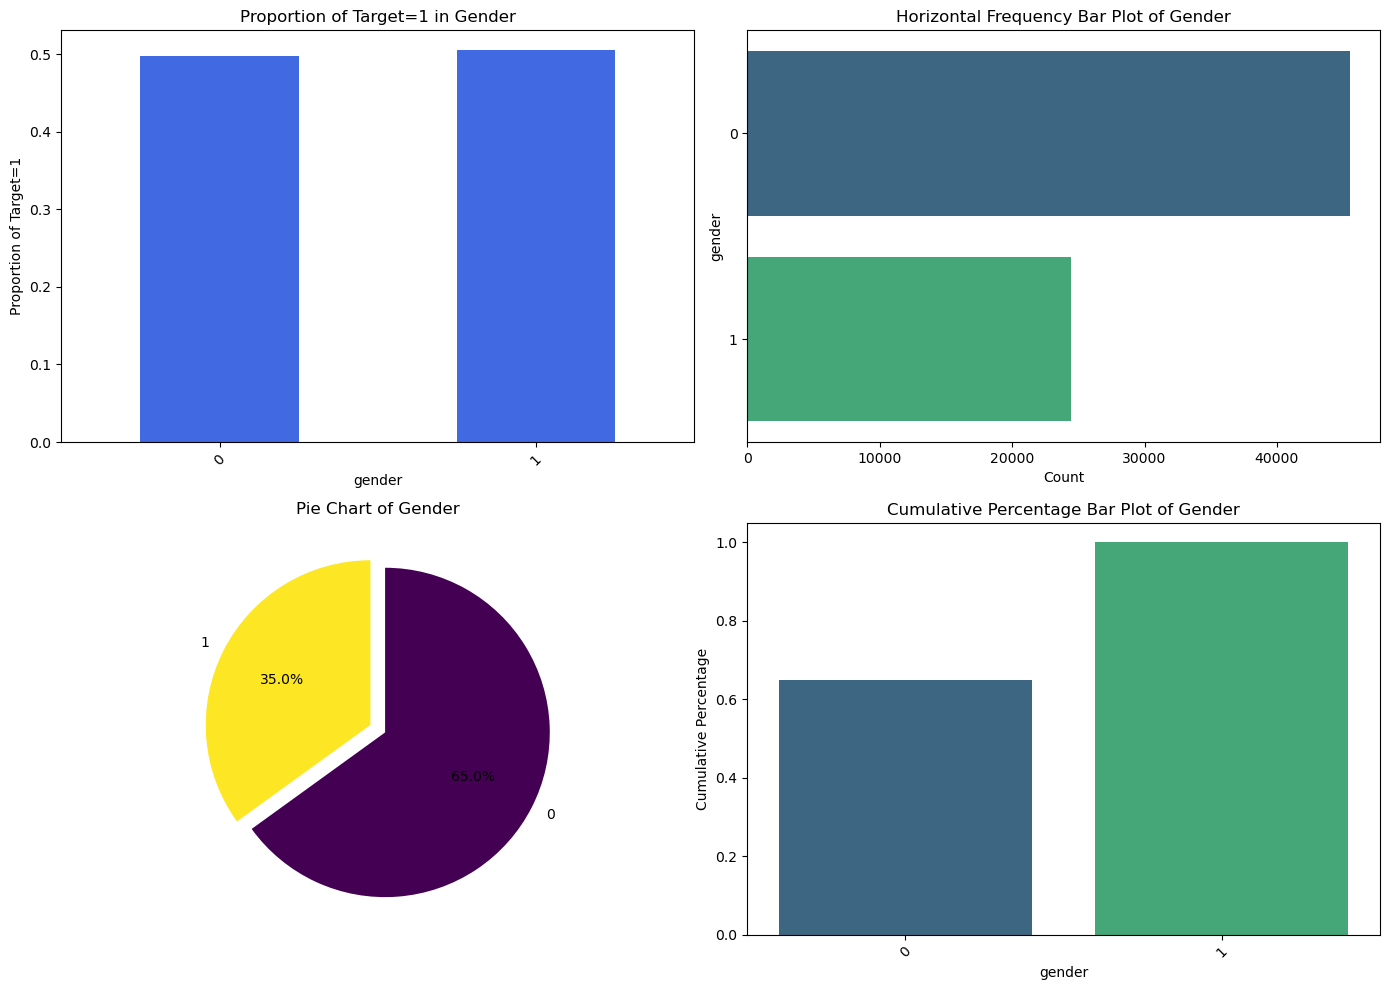

In [73]:
plot_categorical_feature(df, 'gender')

##### `cholesterol`

In [74]:
print(df["cholesterol"].value_counts())

cholesterol
1    52361
2     9549
3     8066
Name: count, dtype: int64


In [75]:
df['cholesterol'] = df['cholesterol'] - 1

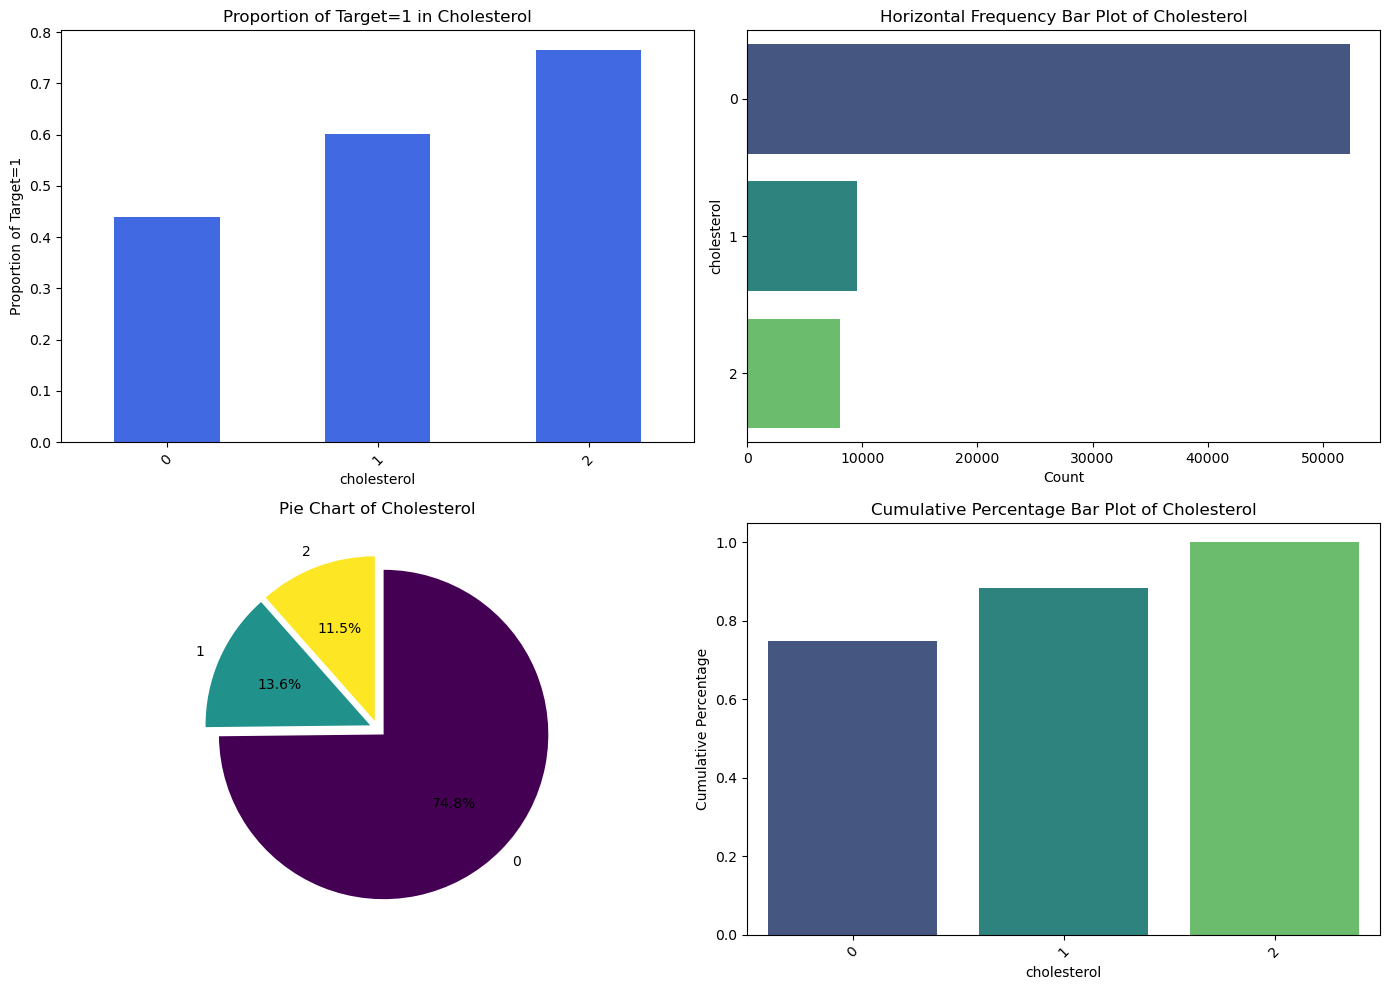

In [76]:
plot_categorical_feature(df, 'cholesterol')

##### `gluc`

In [77]:
print(df["gluc"].value_counts())

gluc
1    59455
3     5331
2     5190
Name: count, dtype: int64


In [78]:
df['gluc'] = df['gluc'] - 1

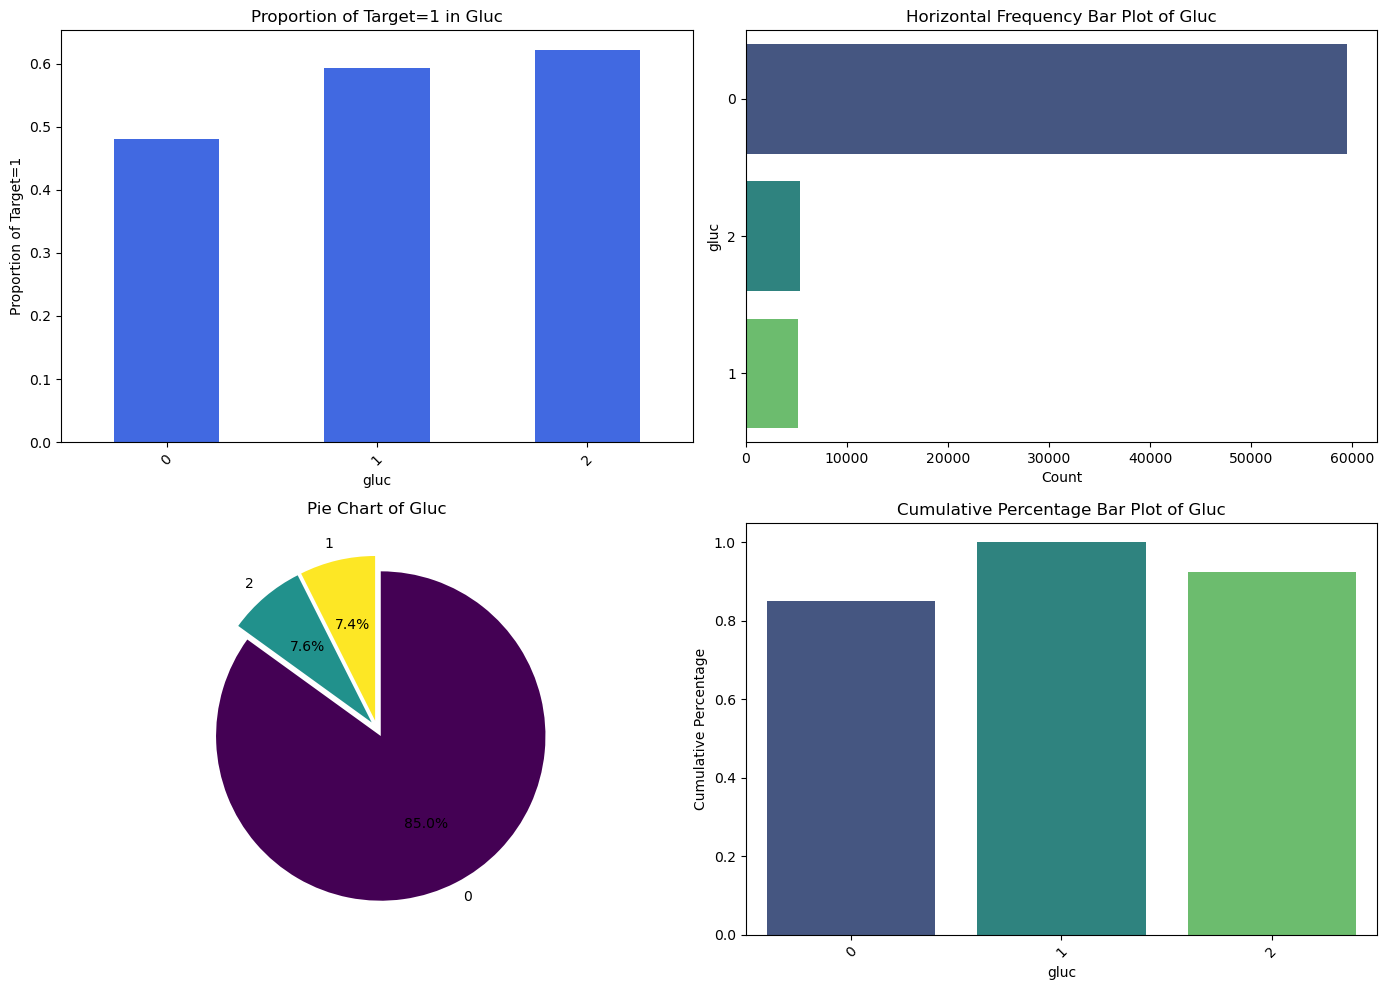

In [79]:
plot_categorical_feature(df, 'gluc')

##### `smoke`

In [80]:
print(df["smoke"].value_counts())

smoke
0    63807
1     6169
Name: count, dtype: int64


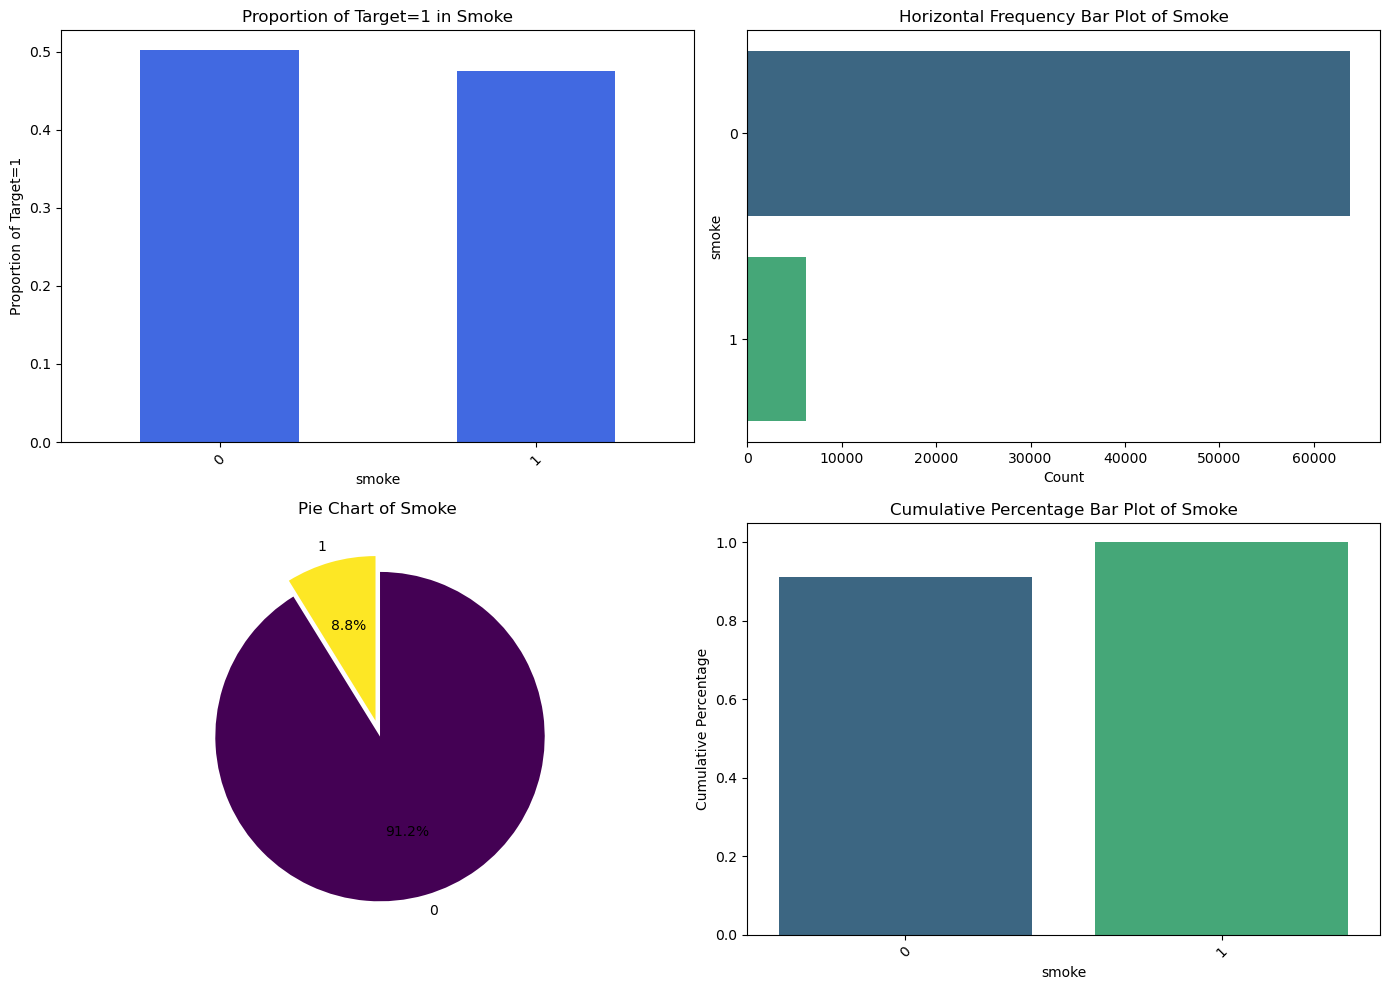

In [81]:
plot_categorical_feature(df, 'smoke')

##### `alco`

In [82]:
print(df["alco"].value_counts())

alco
0    66212
1     3764
Name: count, dtype: int64


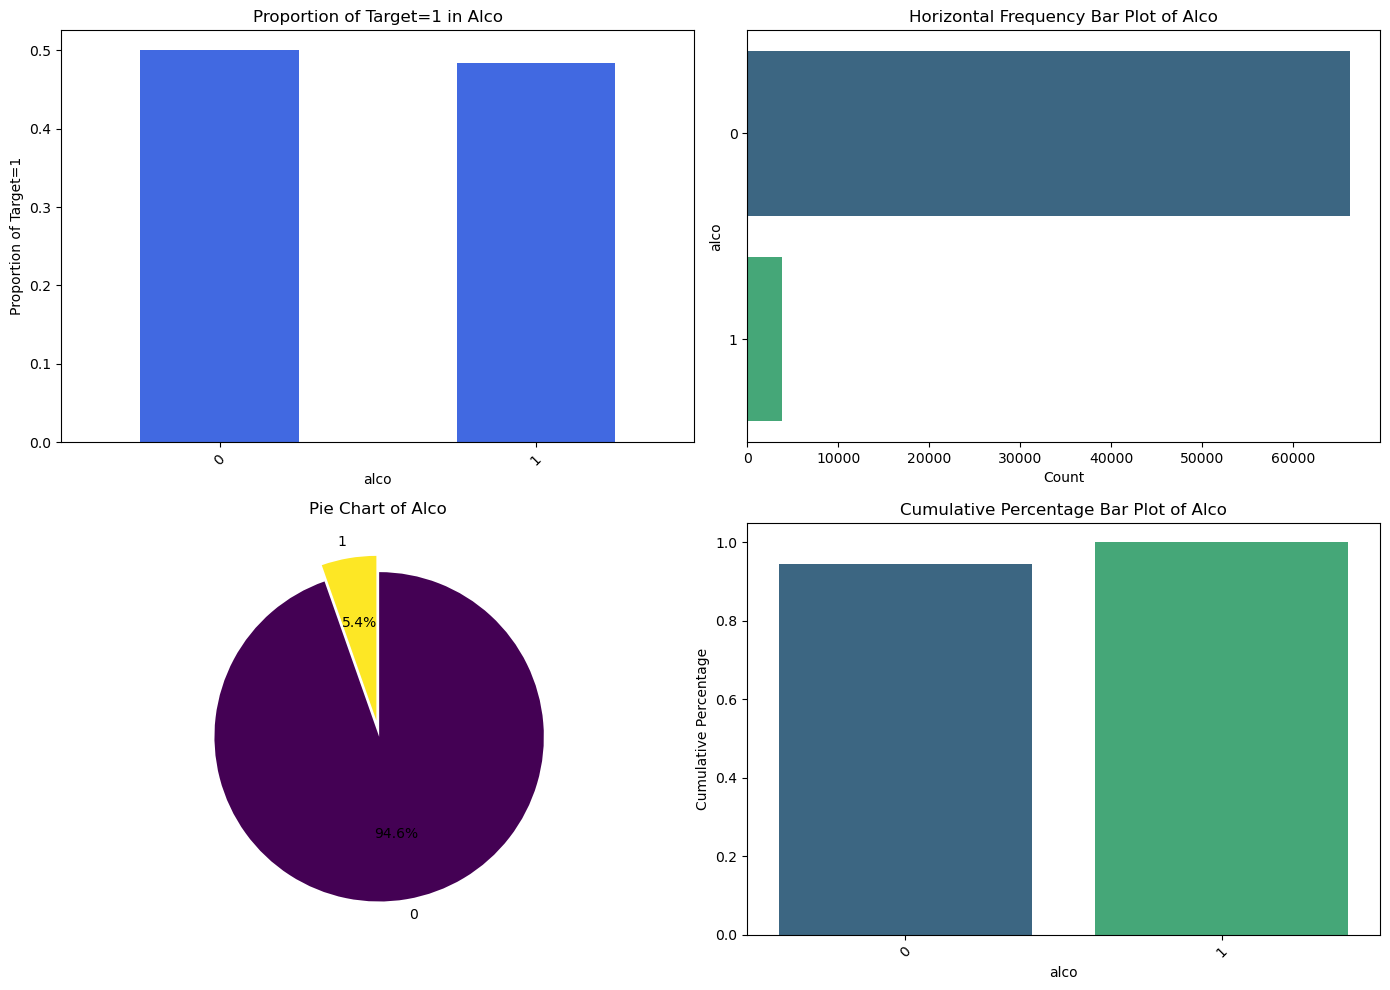

In [83]:
plot_categorical_feature(df, 'alco')

##### `active`

In [84]:
print(df["active"].value_counts())

active
1    56241
0    13735
Name: count, dtype: int64


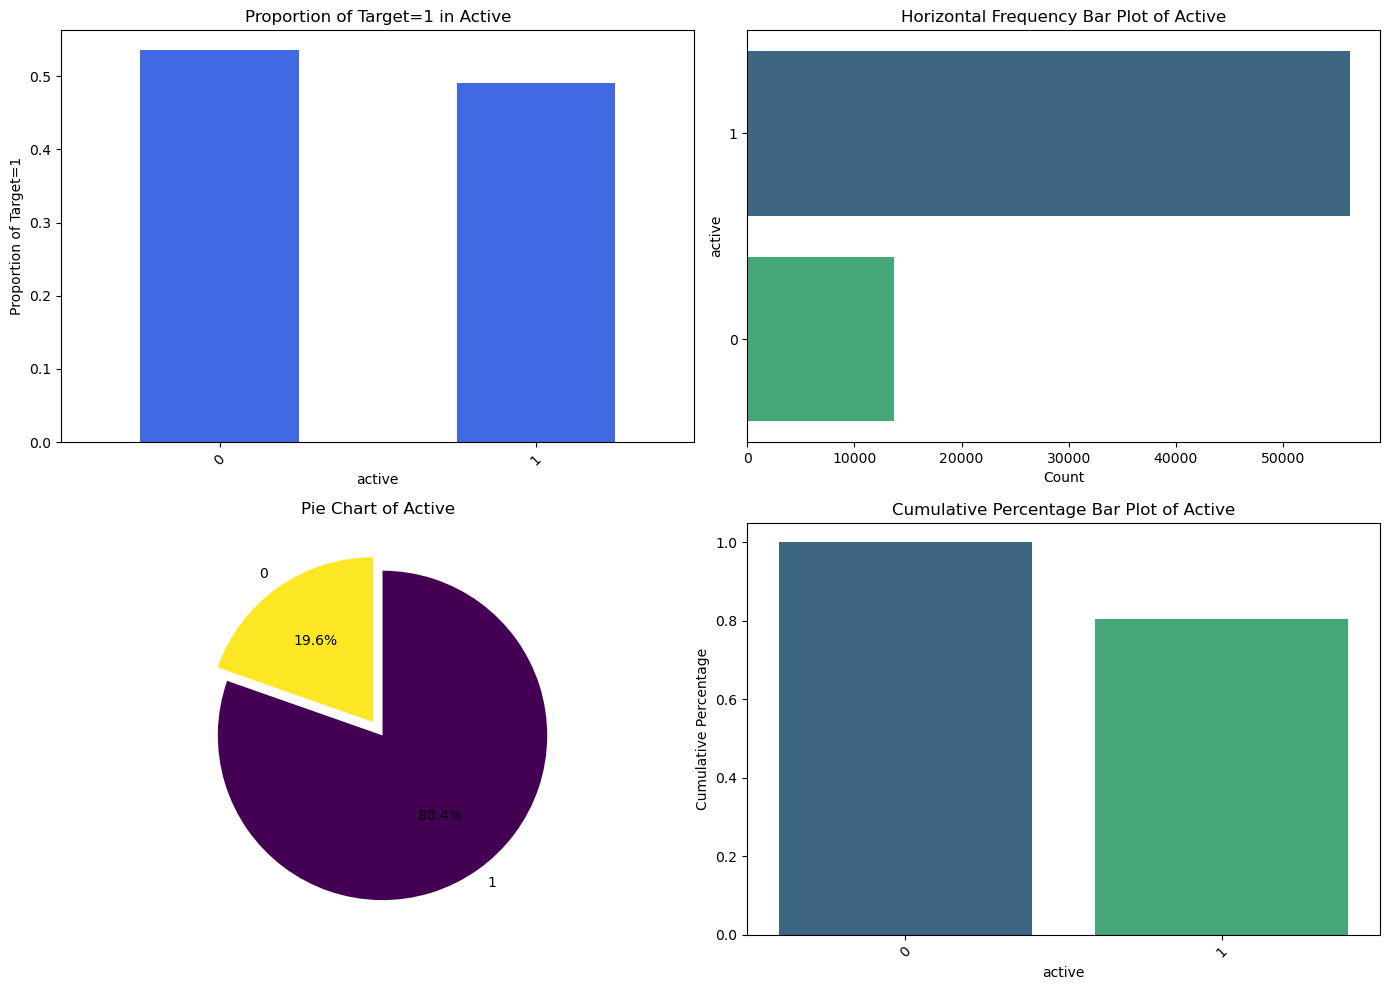

In [85]:
plot_categorical_feature(df, 'active')

### `Feature Engineering`

##### `bmi`

In [86]:
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

In [87]:
df[['weight', 'height', 'bmi']].sample(5)

weight  height        bmi
id                              
46236    60.0     160  23.437500
28470    78.0     164  29.000595
66404   100.0     185  29.218408
72125    81.0     176  26.149277
78902    82.0     172  27.717685

In [88]:
df['bmi'].describe()

count    69976.000000
mean        27.508487
std          5.341505
min         11.046585
25%         23.875115
50%         26.395803
75%         30.222222
max        104.166667
Name: bmi, dtype: float64

In [89]:
df['bmi'].quantile(quant)

0.001    16.161114
0.003    17.224804
0.005    17.777778
0.010    18.612245
0.990    44.284149
0.995    47.542415
0.997    49.844361
0.999    55.555556
Name: bmi, dtype: float64

In [90]:
df[['age', 'gender', 'height', 'weight', 'bmi', 'target']][(df['bmi'] < 16) | (df['bmi'] > 52)].value_counts('target')

target
1    115
0     80
Name: count, dtype: int64

In [91]:
df = df[(df['bmi'] >= 16) & (df['bmi'] <= 52)]

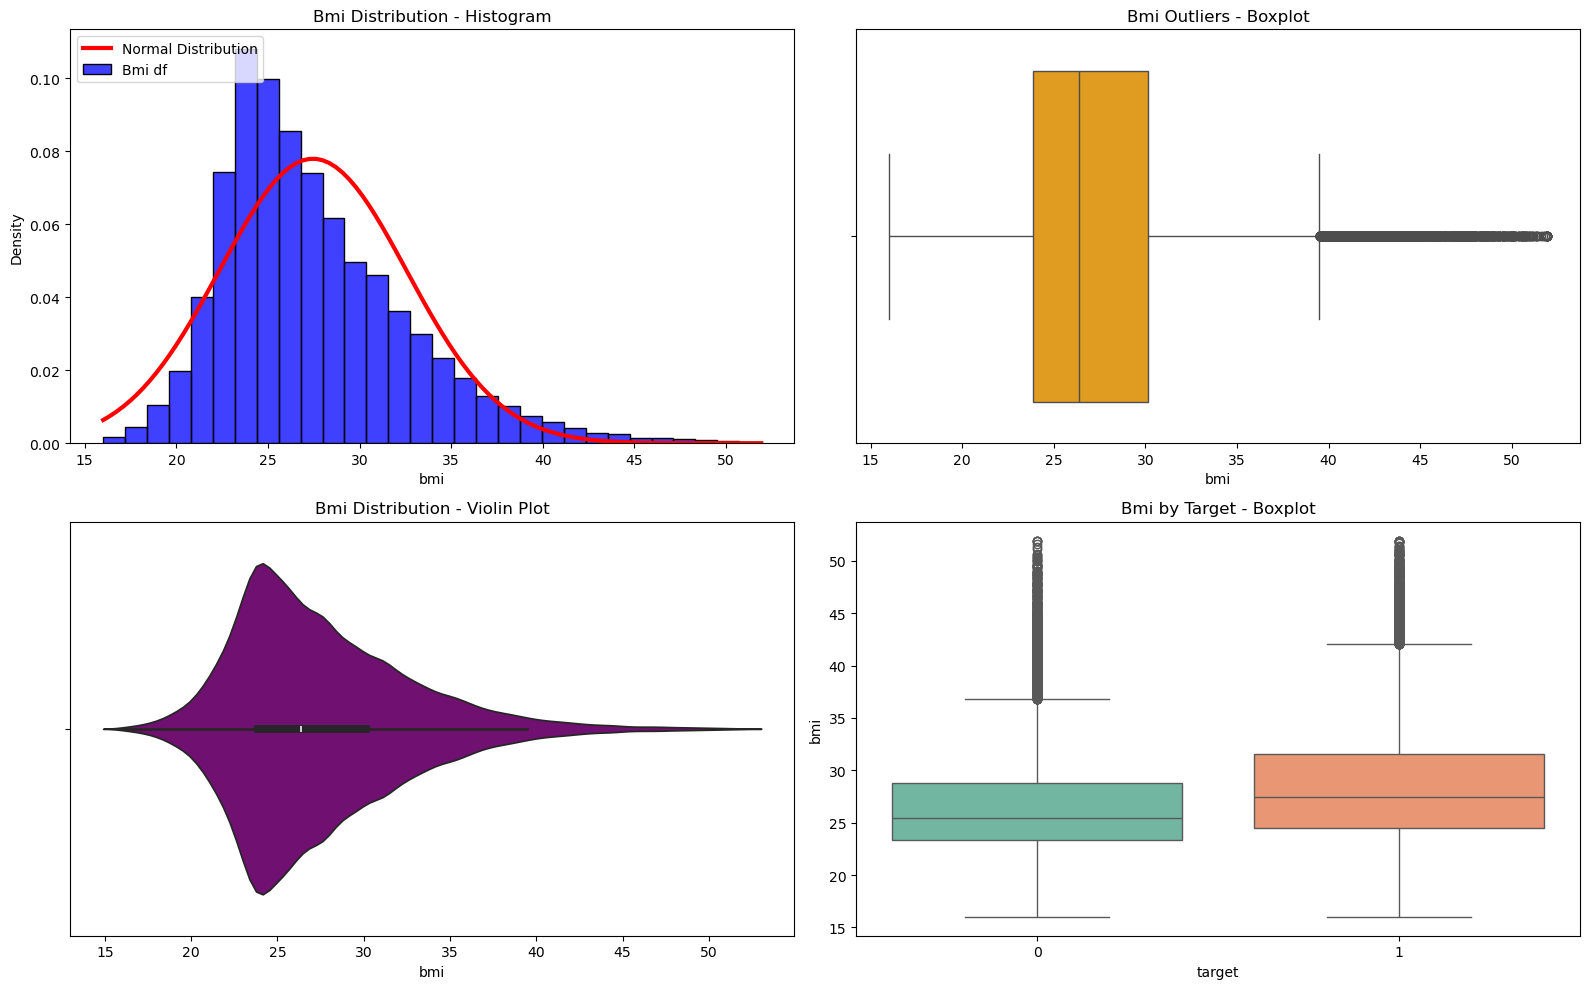

In [92]:
plot_numerical_feature(df, 'bmi')

In [93]:
skew_kurtosis(df, 'bmi')

BMI

Original:
Skewness: 1.048683777904313, Kurtosis: 1.4738167980639636

Square Root Transformation:
Skewness: 0.7625039334111124, Kurtosis: 0.7138978378195016

Log1p Transformation:
Skewness: 0.5092018039909136, Kurtosis: 0.2692096839419569

Box-Cox Transformation:
Skewness: 0.0013803723177478295, Kurtosis: 0.05905072410132073



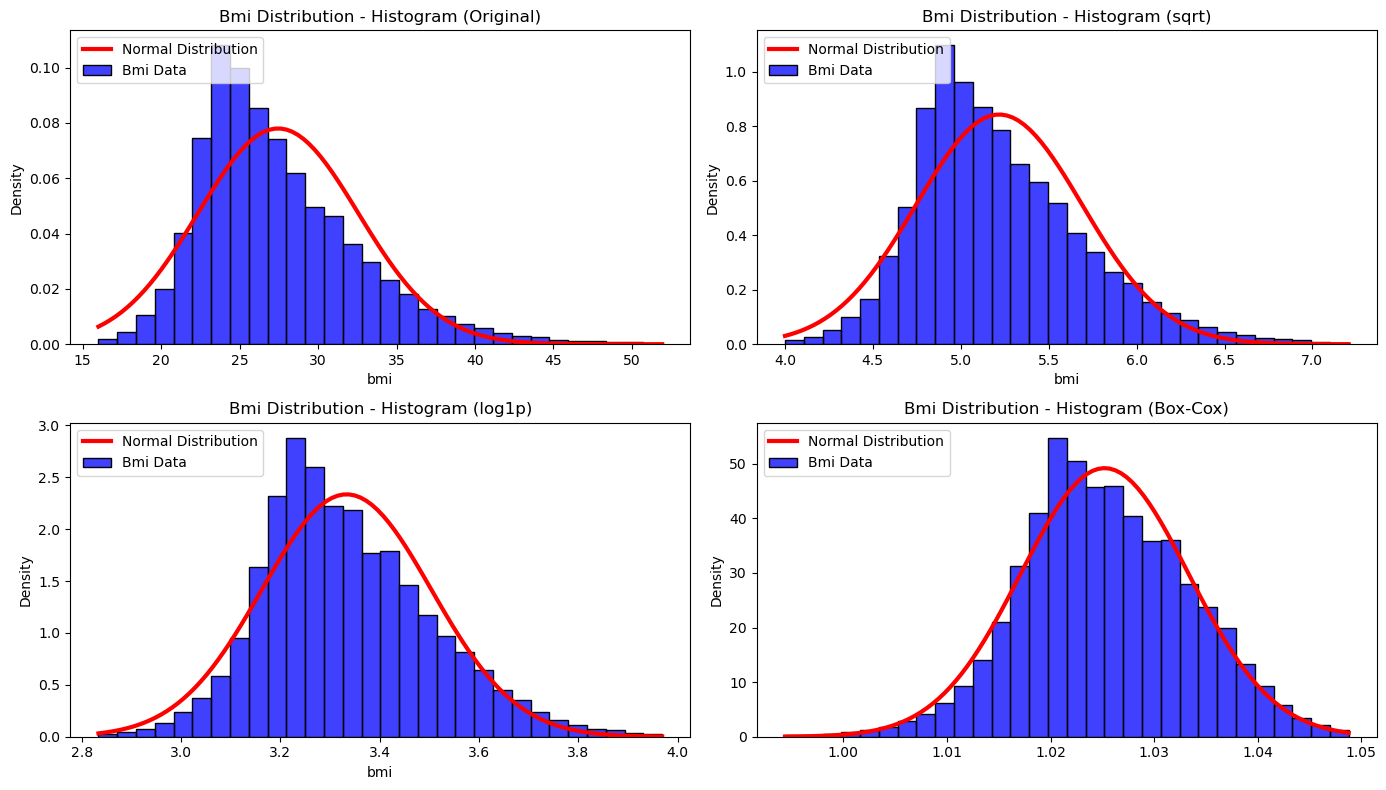

In [94]:
check_transform(df, 'bmi')

In [95]:
df['bmi_boxcox'], _ = boxcox(df['bmi'])

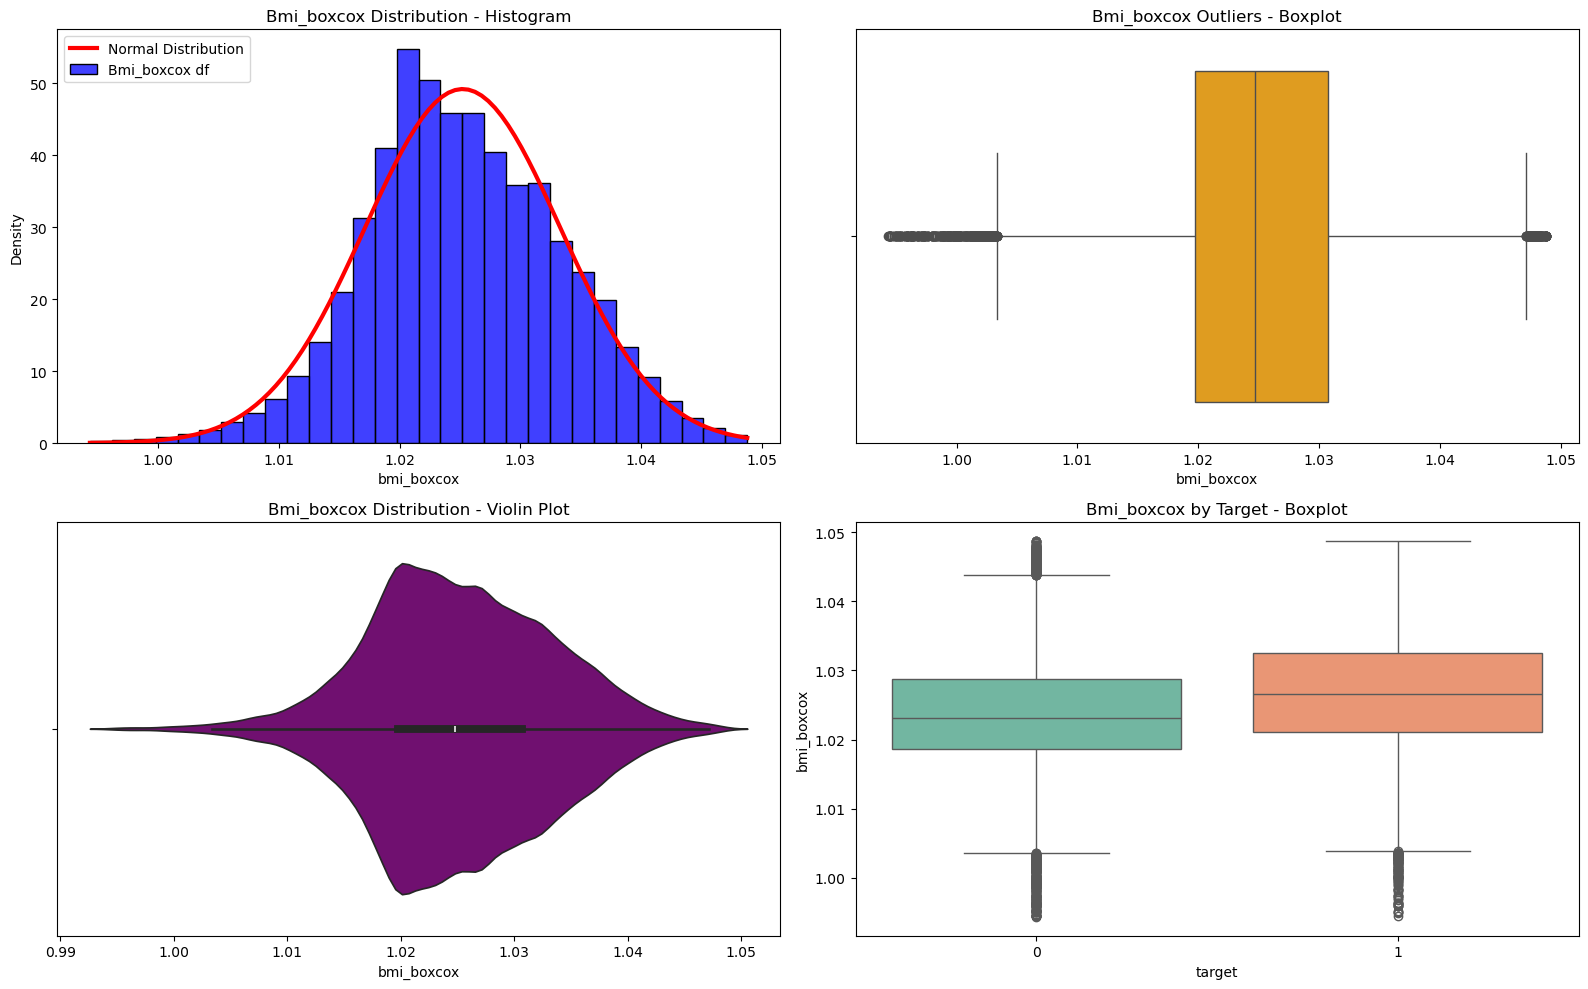

In [96]:
plot_numerical_feature(df, 'bmi_boxcox')

##### `bmi_category`

In [97]:
bins = [0, 18.5, 24.9, 29.9, np.inf]
labels = [0, 1, 2, 3]

df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False).astype('int')

In [98]:
df[['height', 'weight', 'bmi', 'bmi_category']].sample(5)

height  weight        bmi  bmi_category
id                                            
93410     166    94.0  34.112353             3
63683     153    57.0  24.349609             1
67502     160    65.0  25.390625             2
22546     169    62.0  21.707923             1
43990     184   121.0  35.739603             3

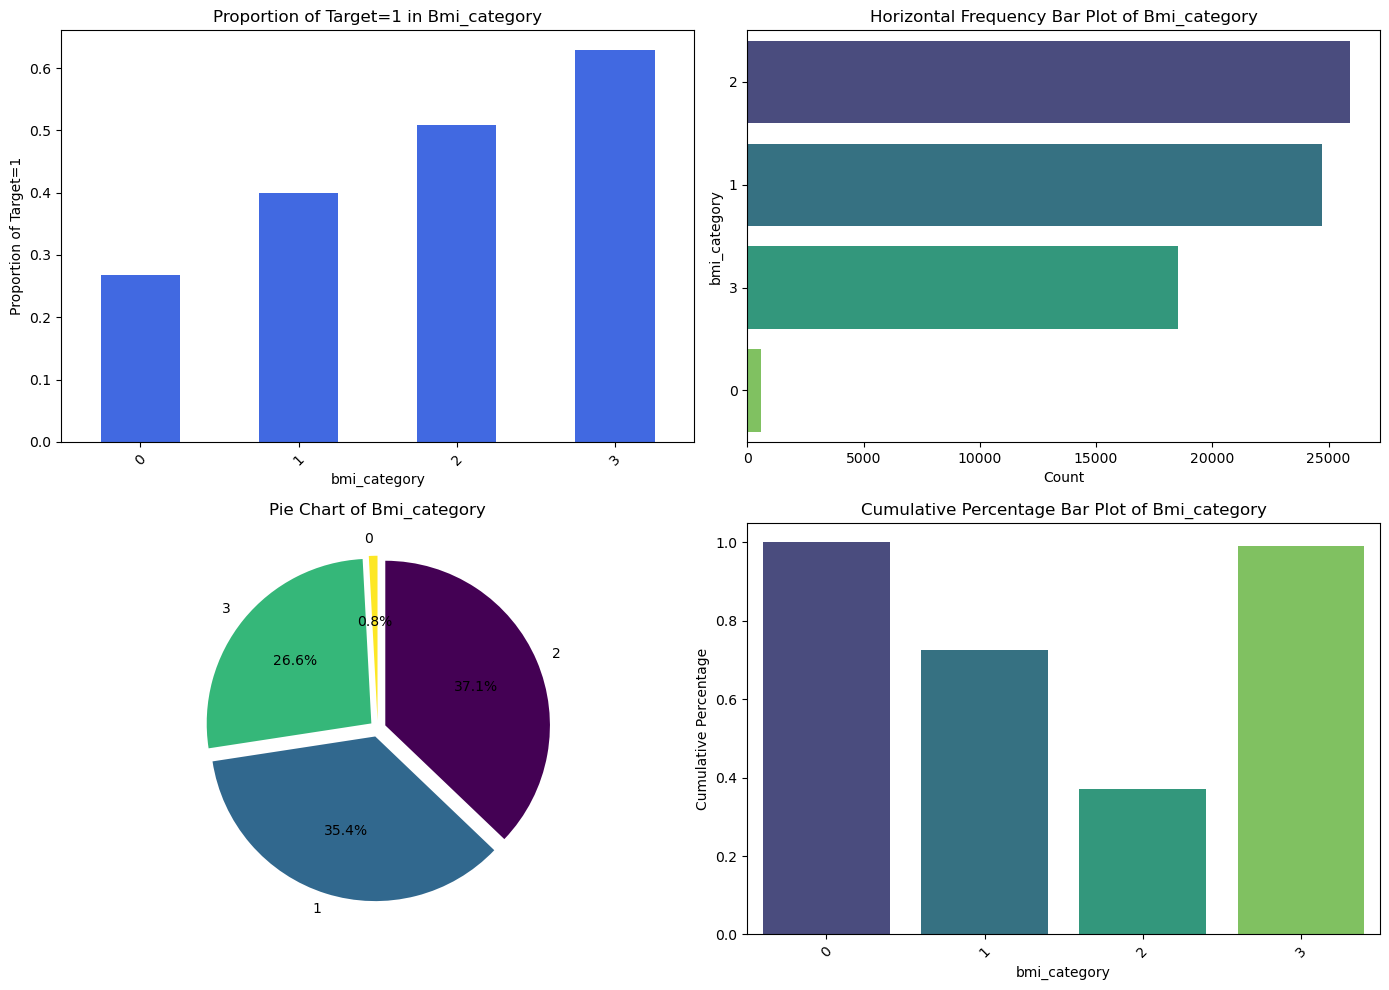

In [99]:
plot_categorical_feature(df, 'bmi_category')

##### `age_to_bmi_ratio`

In [100]:
df['age_to_bmi_ratio'] = df['age'] / df['bmi']

In [101]:
df[['age', 'bmi', 'age_to_bmi_ratio']].sample(5)

age        bmi  age_to_bmi_ratio
id                                     
48144   52  30.824830          1.686952
48966   51  23.875115          2.136115
24509   58  26.709402          2.171520
57136   54  24.840980          2.173827
37080   64  36.051915          1.775218

In [102]:
df['age_to_bmi_ratio'].describe()

count    69781.000000
mean         1.981018
std          0.403316
min          0.769184
25%          1.696988
50%          1.965600
75%          2.250600
max          3.931863
Name: age_to_bmi_ratio, dtype: float64

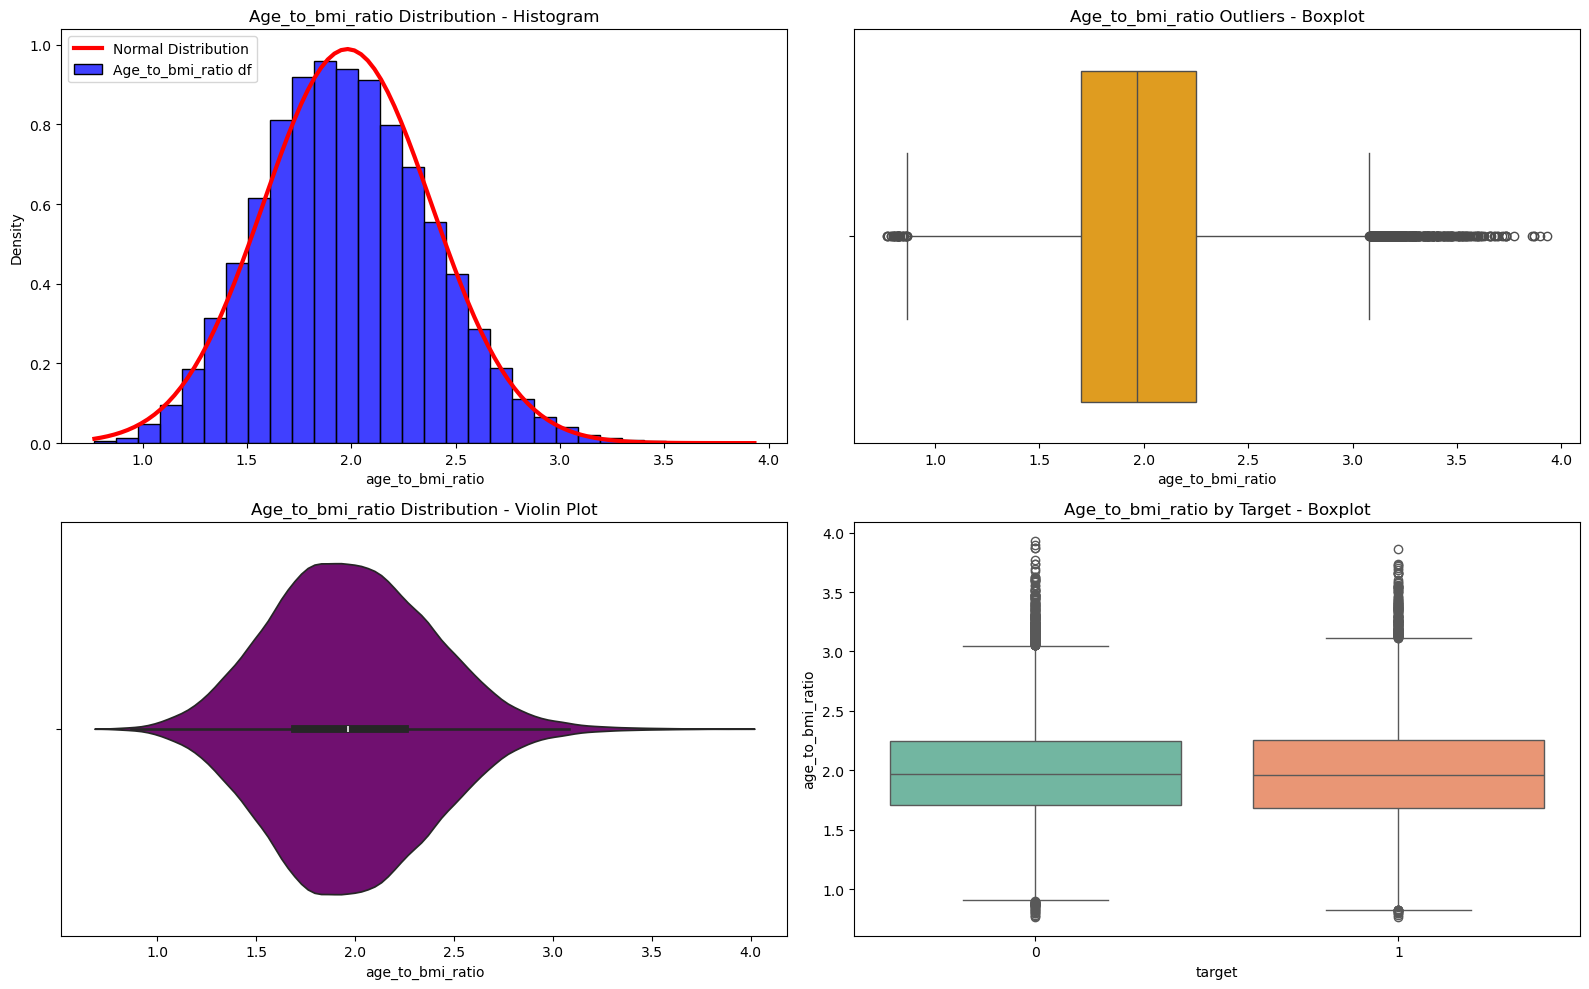

In [103]:
plot_numerical_feature(df, 'age_to_bmi_ratio')

In [104]:
skew_kurtosis(df, 'age_to_bmi_ratio')

AGE_TO_BMI_RATIO

Original:
Skewness: 0.24623562685317818, Kurtosis: 0.05918847518597037

Square Root Transformation:
Skewness: -0.054482267922193316, Kurtosis: -0.05082655980438622

Log1p Transformation:
Skewness: -0.1462615444782914, Kurtosis: -0.05688918197464021

Box-Cox Transformation:
Skewness: -0.002890673938147584, Kurtosis: -0.05527841878735362



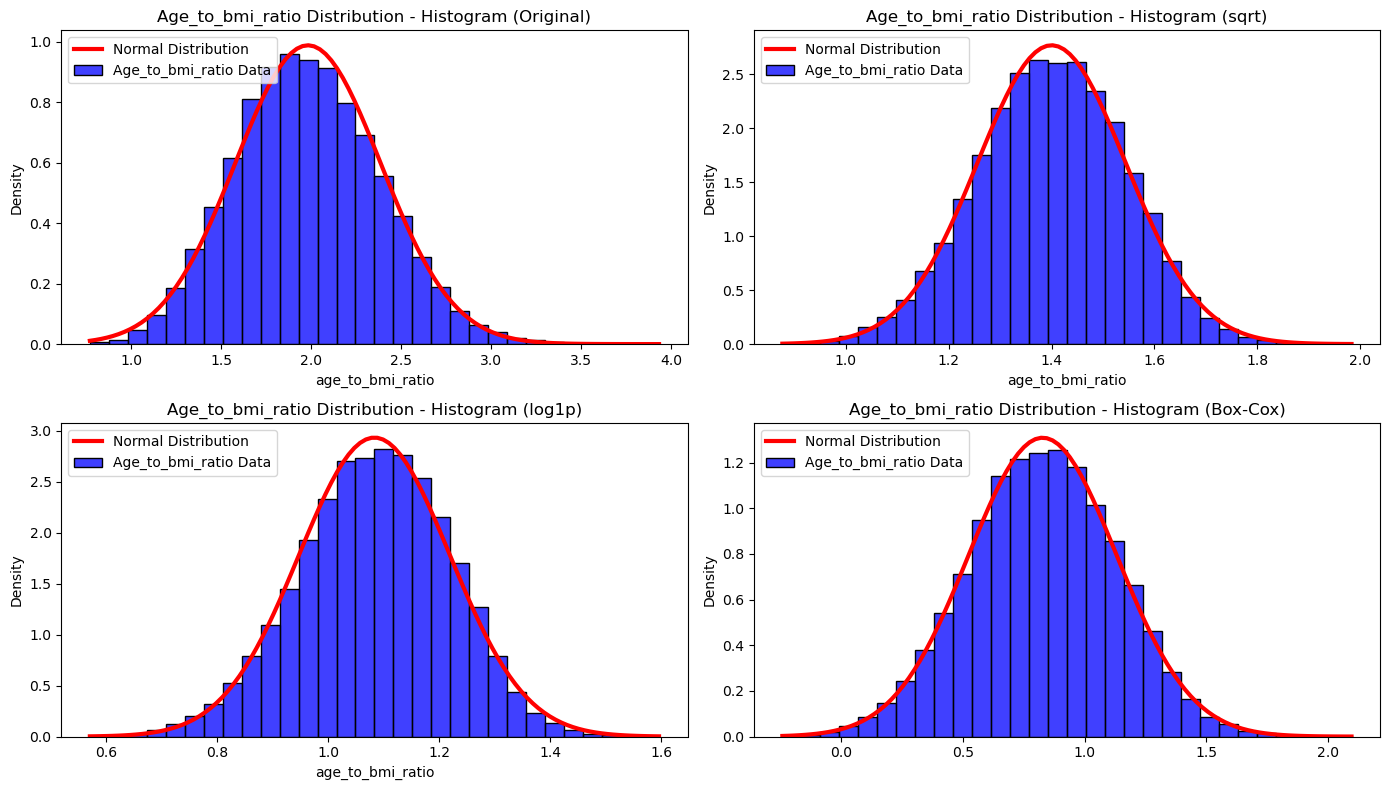

In [105]:
check_transform(df, 'age_to_bmi_ratio')

In [106]:
df['age_to_bmi_ratio_boxcox'], _ = boxcox(df['age_to_bmi_ratio'])

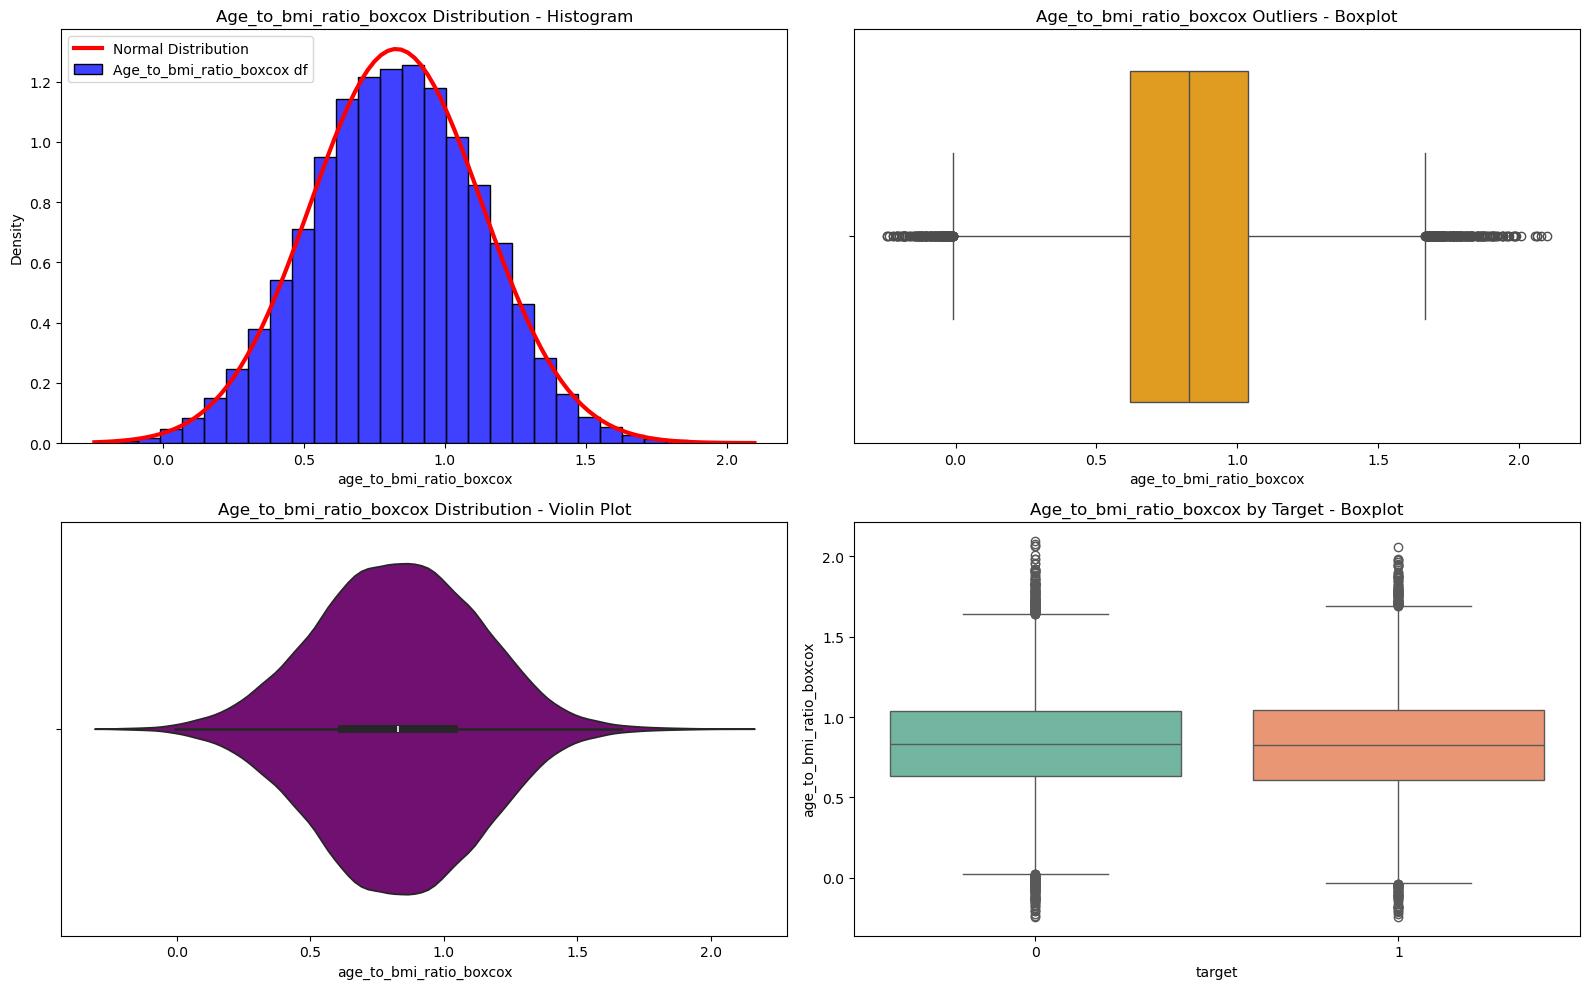

In [107]:
plot_numerical_feature(df, 'age_to_bmi_ratio_boxcox')

##### `age_bmi_interaction`

In [108]:
df['age_bmi_interaction'] = df['age'] * df['bmi']

In [109]:
df[['age', 'bmi', 'age_bmi_interaction']].sample(5)

age        bmi  age_bmi_interaction
id                                        
33239   46  36.262439          1668.072188
48492   53  23.507805          1245.913682
68961   51  25.711662          1311.294766
45911   49  28.710479          1406.813487
9395    52  20.047446          1042.467172

In [110]:
df['age_bmi_interaction'].describe()

count    69781.000000
mean      1454.215715
std        345.054024
min        558.693878
25%       1212.070760
50%       1410.612245
75%       1650.132780
max       3321.799308
Name: age_bmi_interaction, dtype: float64

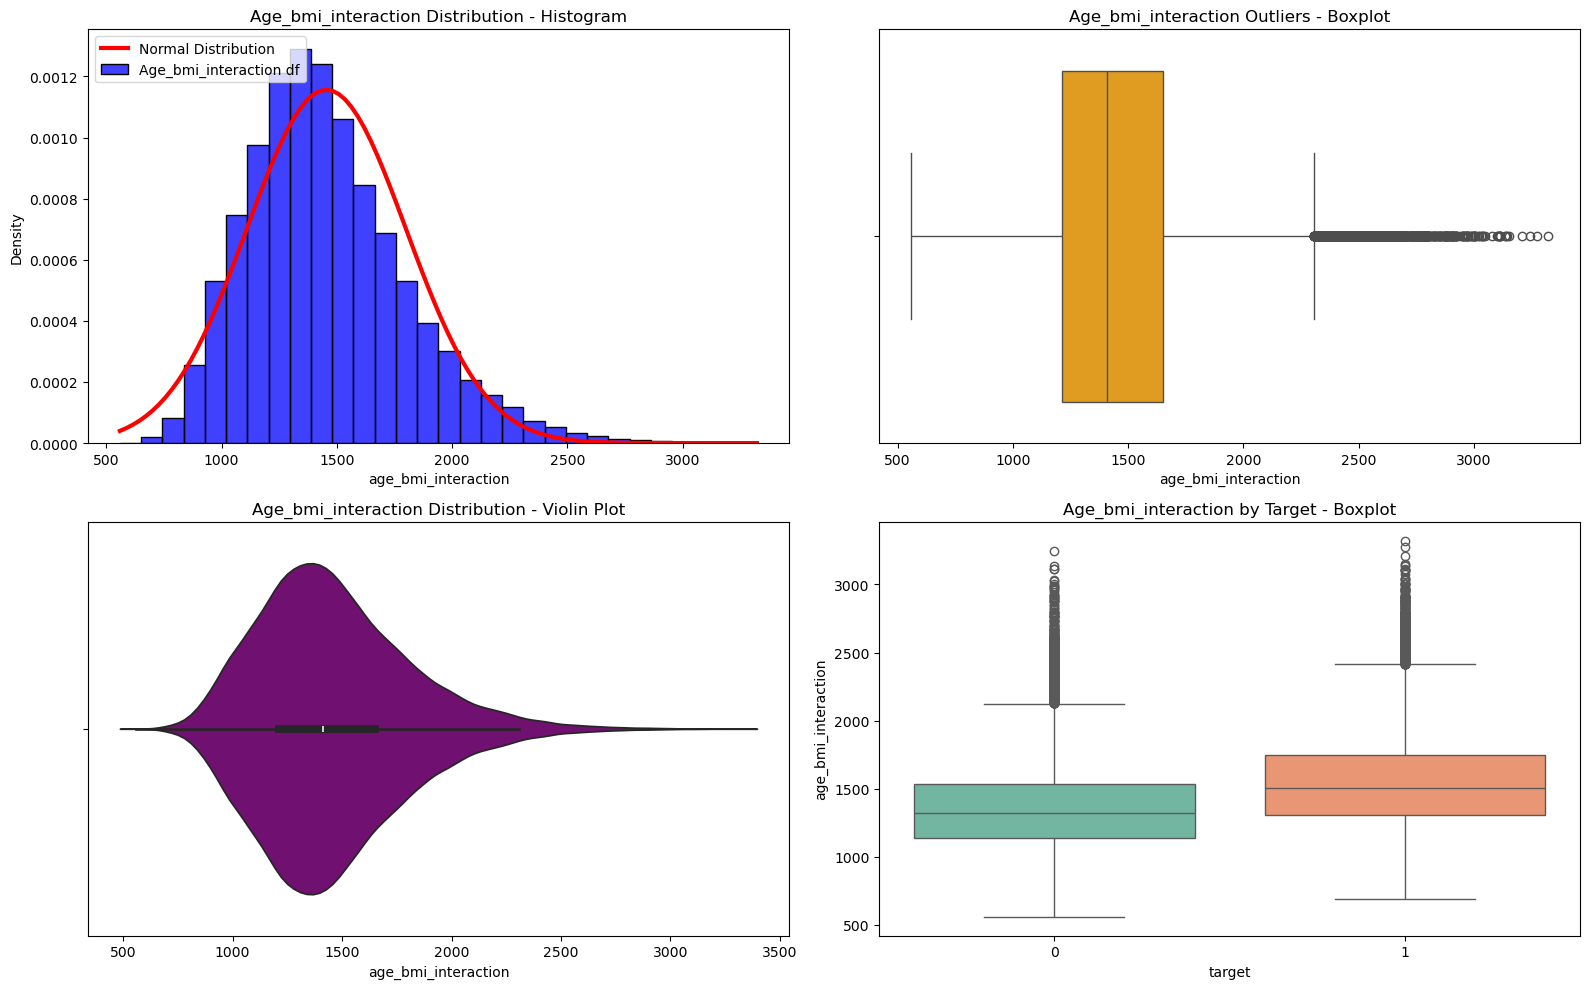

In [111]:
plot_numerical_feature(df, 'age_bmi_interaction')

In [112]:
skew_kurtosis(df, 'age_bmi_interaction')

AGE_BMI_INTERACTION

Original:
Skewness: 0.764898368681568, Kurtosis: 0.8599871431101622

Square Root Transformation:
Skewness: 0.409863244320097, Kurtosis: 0.1973229164371726

Log1p Transformation:
Skewness: 0.06943775515954725, Kurtosis: -0.06043479087917847

Box-Cox Transformation:
Skewness: 0.0005371385145403508, Kurtosis: -0.06764037674351187



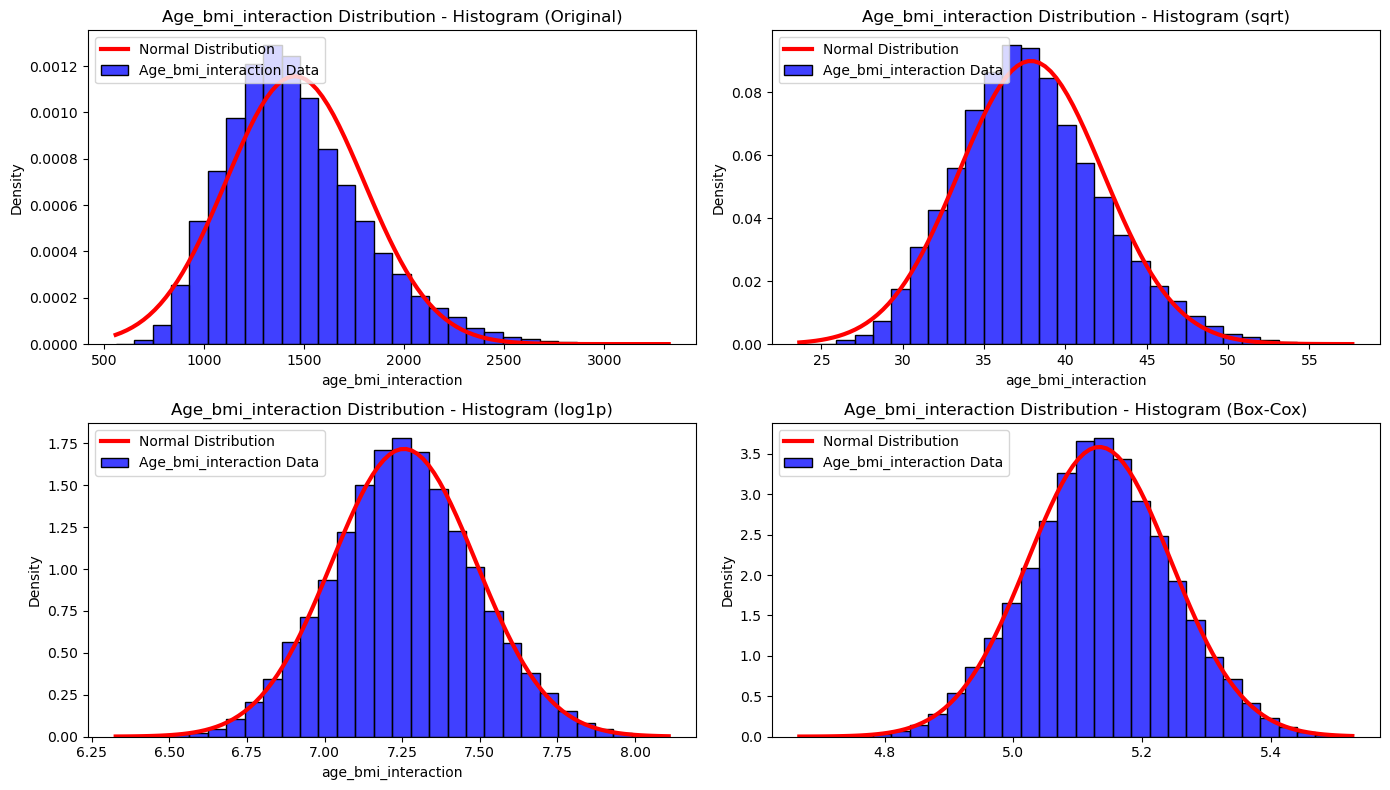

In [113]:
check_transform(df, 'age_bmi_interaction')

In [114]:
df['age_bmi_interaction_boxcox'], _ = boxcox(df['age_bmi_interaction'])

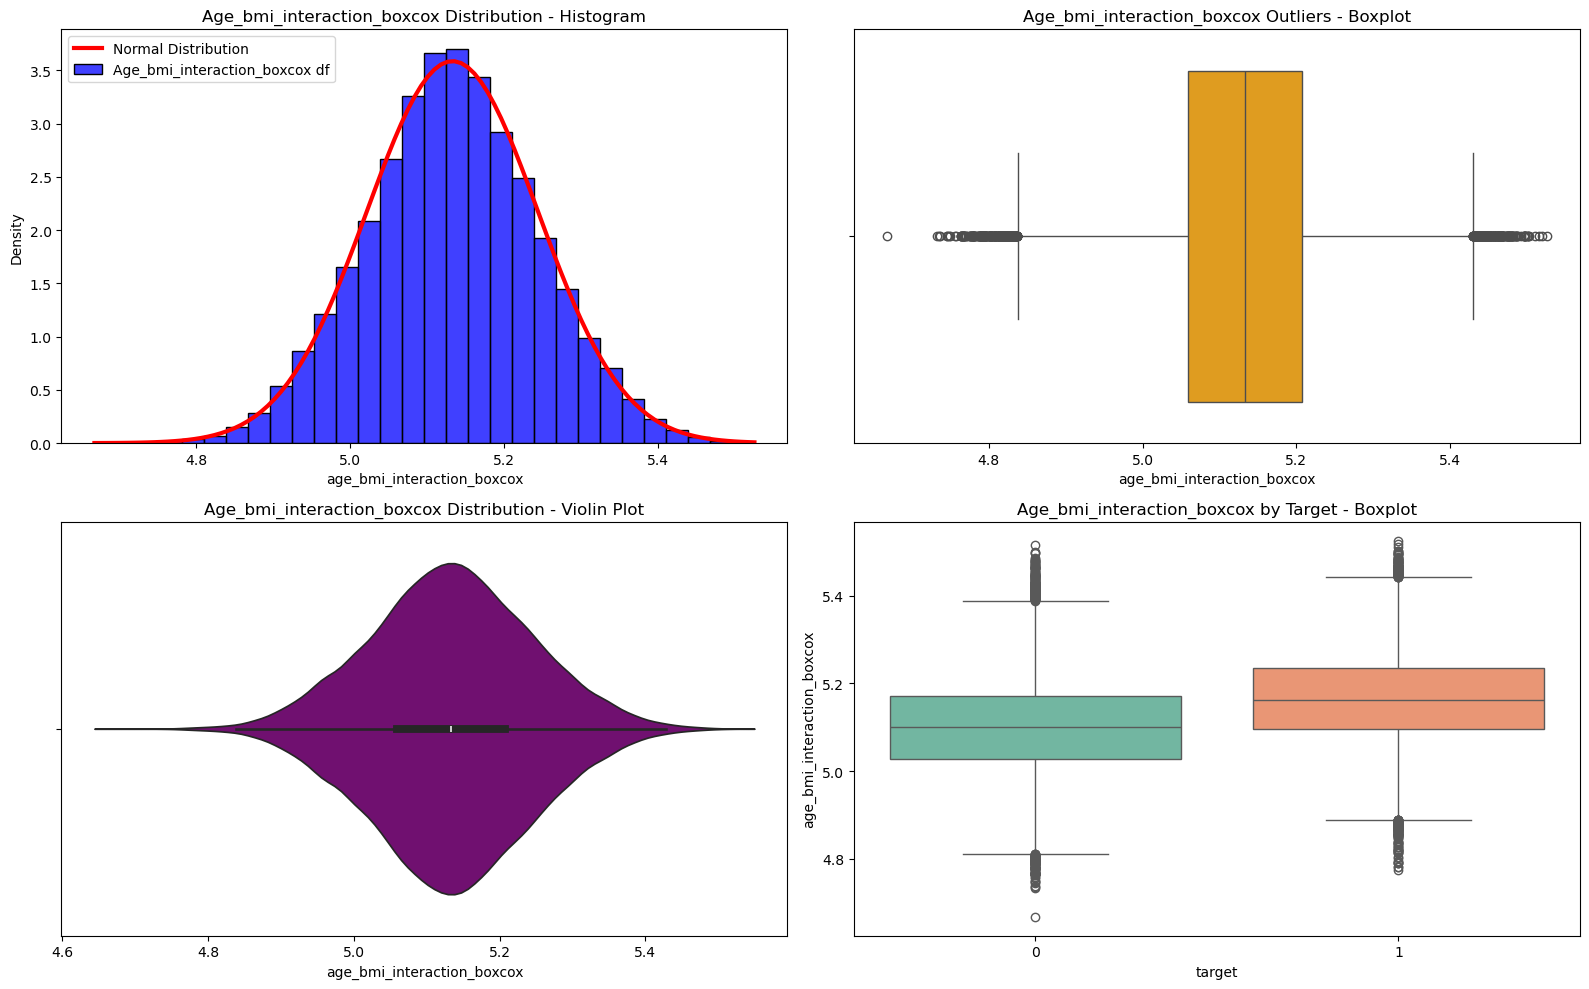

In [115]:
plot_numerical_feature(df, 'age_bmi_interaction_boxcox')

##### `body_fat_indicator`

In [116]:
df['body_fat_indicator'] = (df['bmi'] * df['age']) / 100

In [117]:
df[['age', 'bmi', 'body_fat_indicator']].sample(5)

age        bmi  body_fat_indicator
id                                       
71016   59  33.121307           19.541571
23646   59  29.585799           17.455621
31217   45  25.155896           11.320153
46395   56  35.456448           19.855611
7908    54  25.436467           13.735692

In [118]:
df['body_fat_indicator'].describe()

count    69781.000000
mean        14.542157
std          3.450540
min          5.586939
25%         12.120708
50%         14.106122
75%         16.501328
max         33.217993
Name: body_fat_indicator, dtype: float64

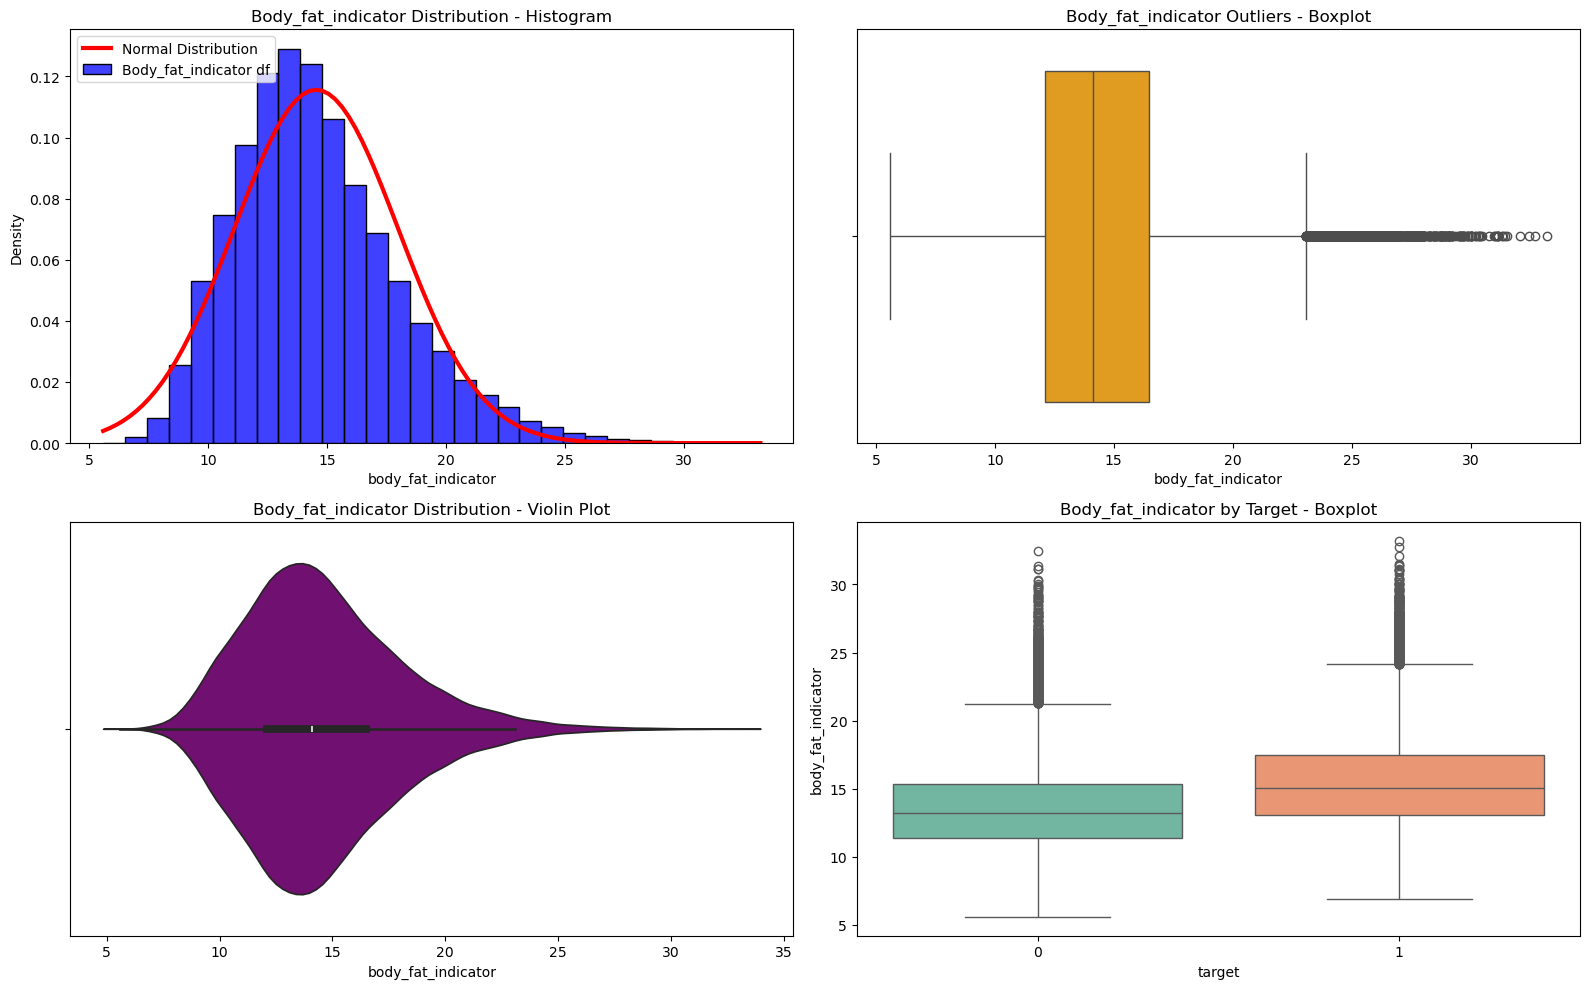

In [119]:
plot_numerical_feature(df, 'body_fat_indicator')

In [120]:
skew_kurtosis(df, 'body_fat_indicator')

BODY_FAT_INDICATOR

Original:
Skewness: 0.7648983686815662, Kurtosis: 0.8599871431101613

Square Root Transformation:
Skewness: 0.40986324432008797, Kurtosis: 0.1973229164371686

Log1p Transformation:
Skewness: 0.11362309471301724, Kurtosis: -0.05845936183097855

Box-Cox Transformation:
Skewness: 0.000537194024809342, Kurtosis: -0.06764037692501734



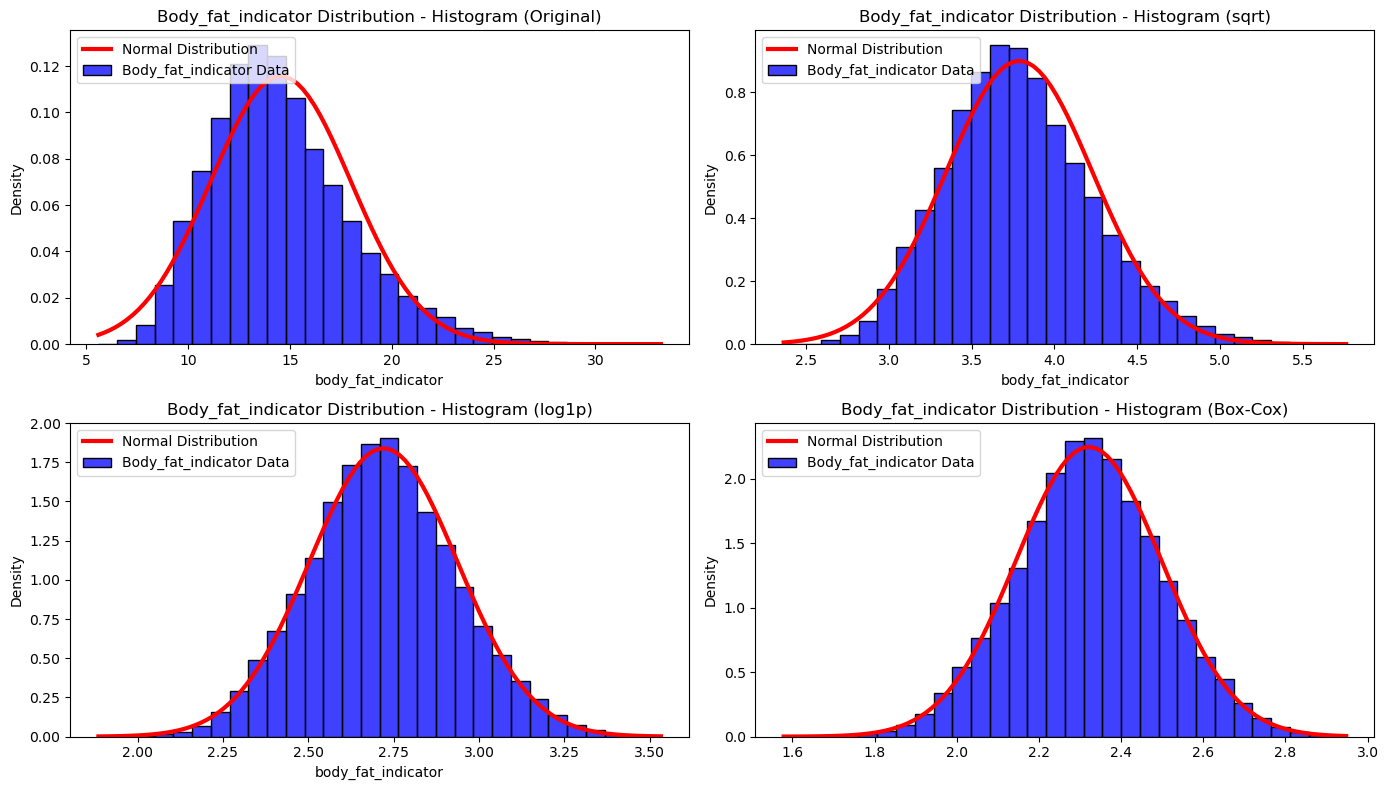

In [121]:
check_transform(df, 'body_fat_indicator')

In [122]:
df['body_fat_indicator_boxcox'], _ = boxcox(df['body_fat_indicator'])

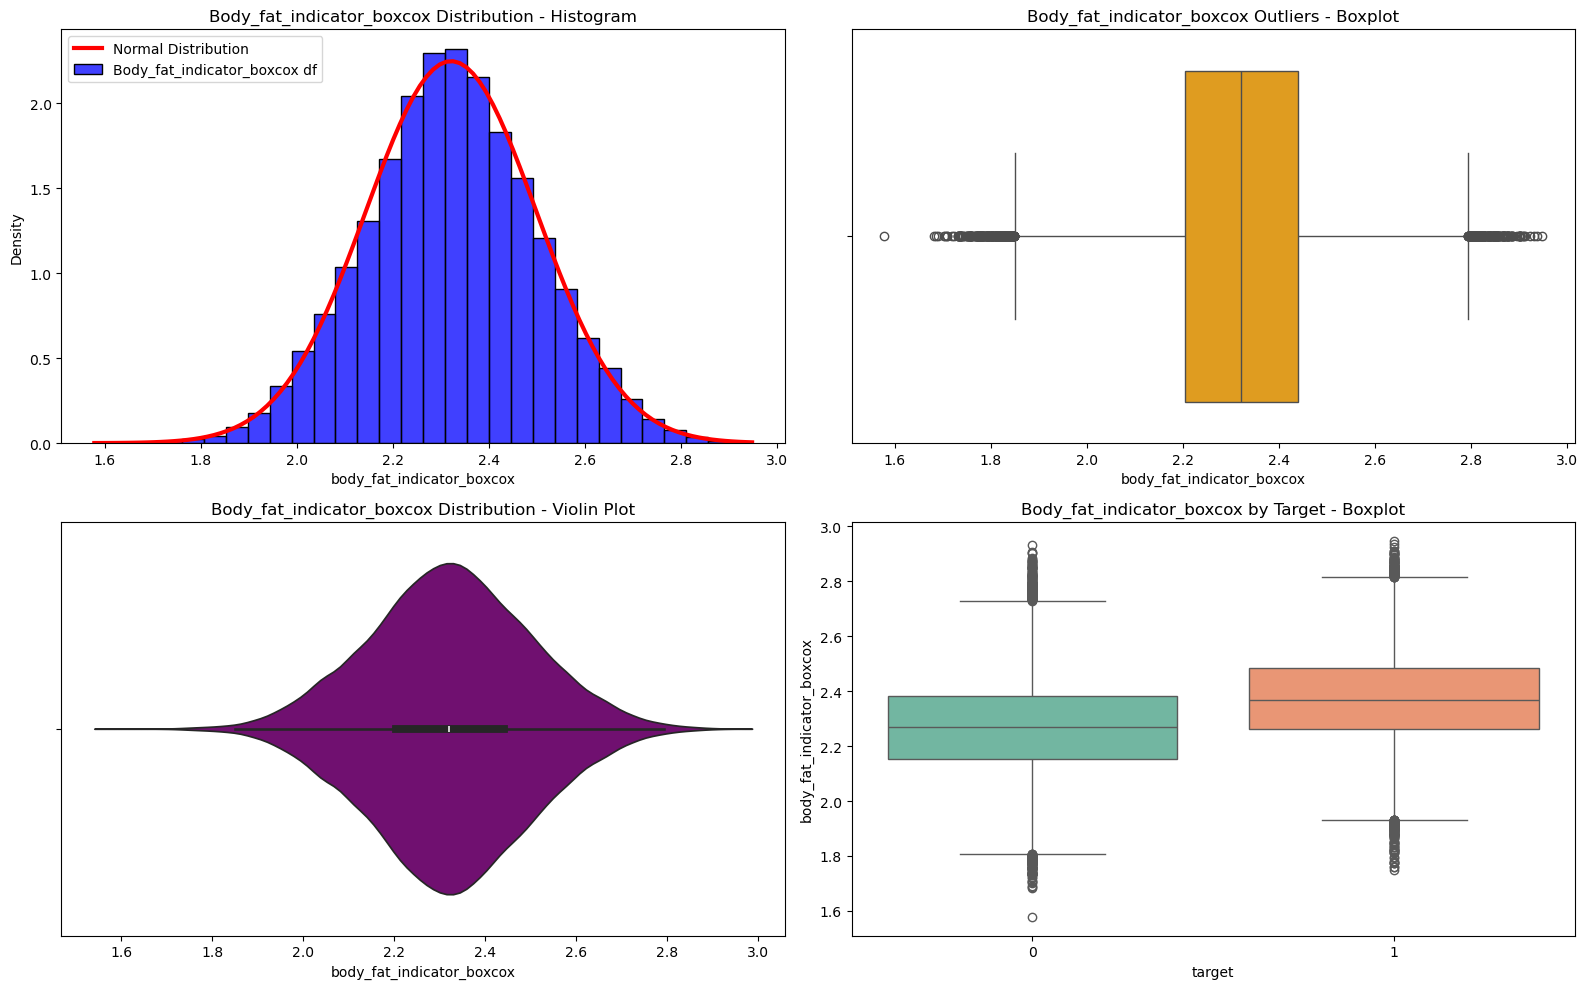

In [123]:
plot_numerical_feature(df, 'body_fat_indicator_boxcox')

##### `weight_height_ratio`

In [124]:
df['weight_height_ratio'] = df['weight'] / df['height']

In [125]:
df[['weight', 'height', 'weight_height_ratio']].sample(5)

weight  height  weight_height_ratio
id                                        
22759    63.0     160             0.393750
81078    84.0     164             0.512195
81416    67.0     149             0.449664
6452     56.0     158             0.354430
19549    65.0     174             0.373563

In [126]:
df['weight_height_ratio'].describe()

count    69781.000000
mean         0.450578
std          0.081642
min          0.239726
25%          0.393939
50%          0.436364
75%          0.494505
max          0.882353
Name: weight_height_ratio, dtype: float64

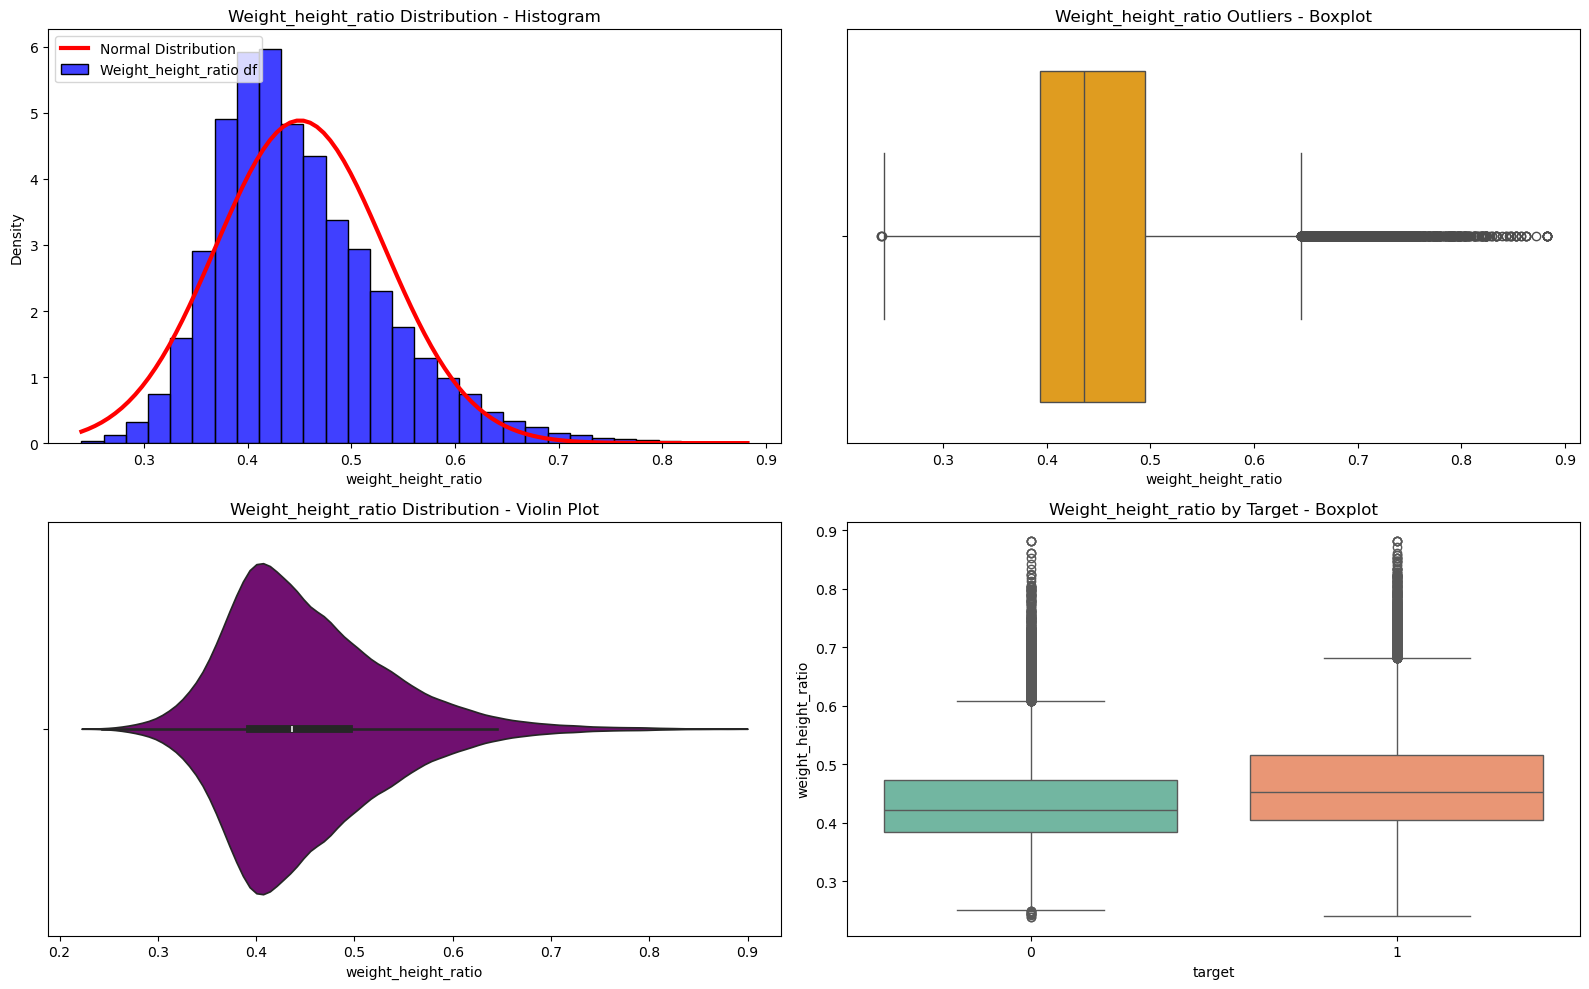

In [127]:
plot_numerical_feature(df, 'weight_height_ratio')

In [128]:
skew_kurtosis(df, 'weight_height_ratio')

WEIGHT_HEIGHT_RATIO

Original:
Skewness: 0.933830914108952, Kurtosis: 1.3494342531261605

Square Root Transformation:
Skewness: 0.6397619062371023, Kurtosis: 0.6387883524749163

Log1p Transformation:
Skewness: 0.739992386121211, Kurtosis: 0.8147372360486402

Box-Cox Transformation:
Skewness: -0.004248012976145262, Kurtosis: 0.16241125378209098



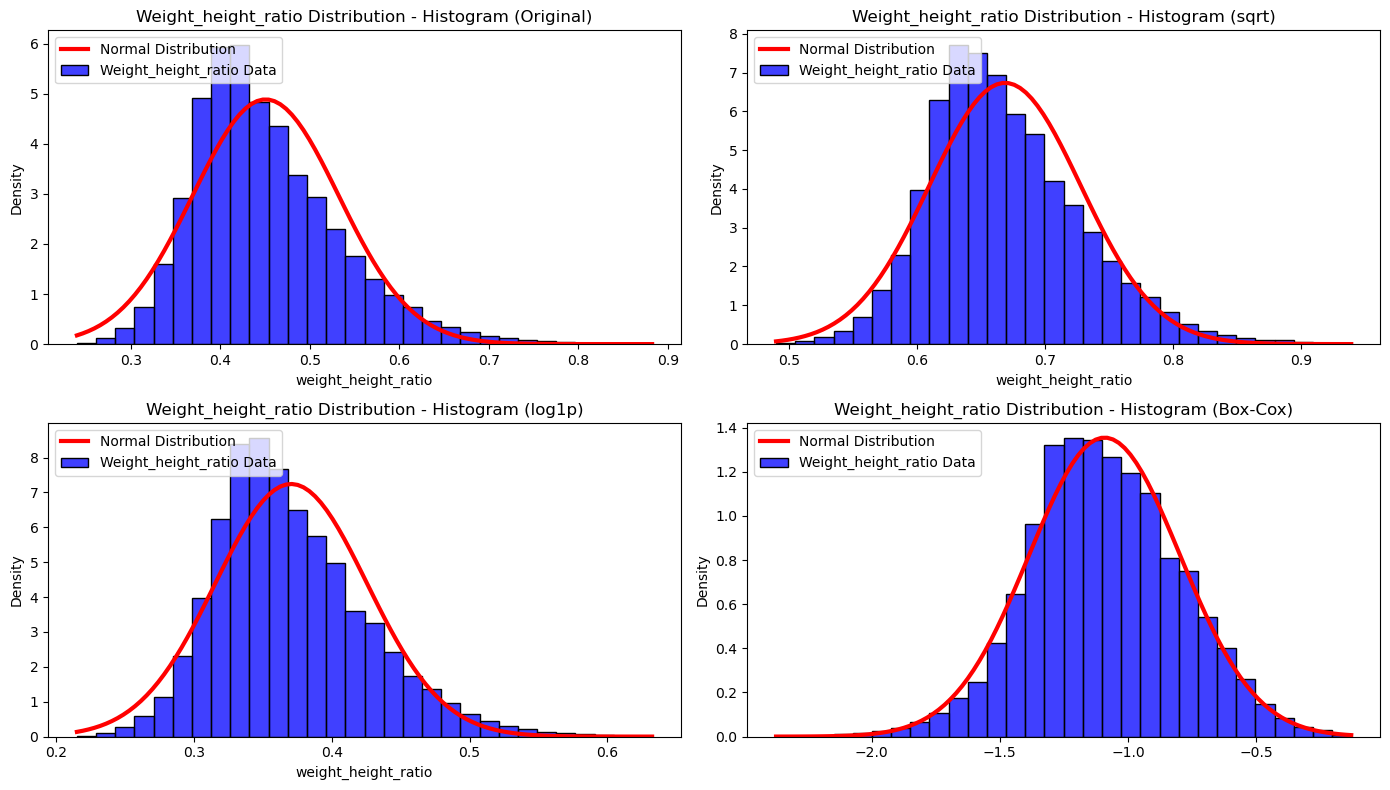

In [129]:
check_transform(df, 'weight_height_ratio')

In [130]:
df['weight_height_ratio_boxcox'], _ = boxcox(df['weight_height_ratio'])

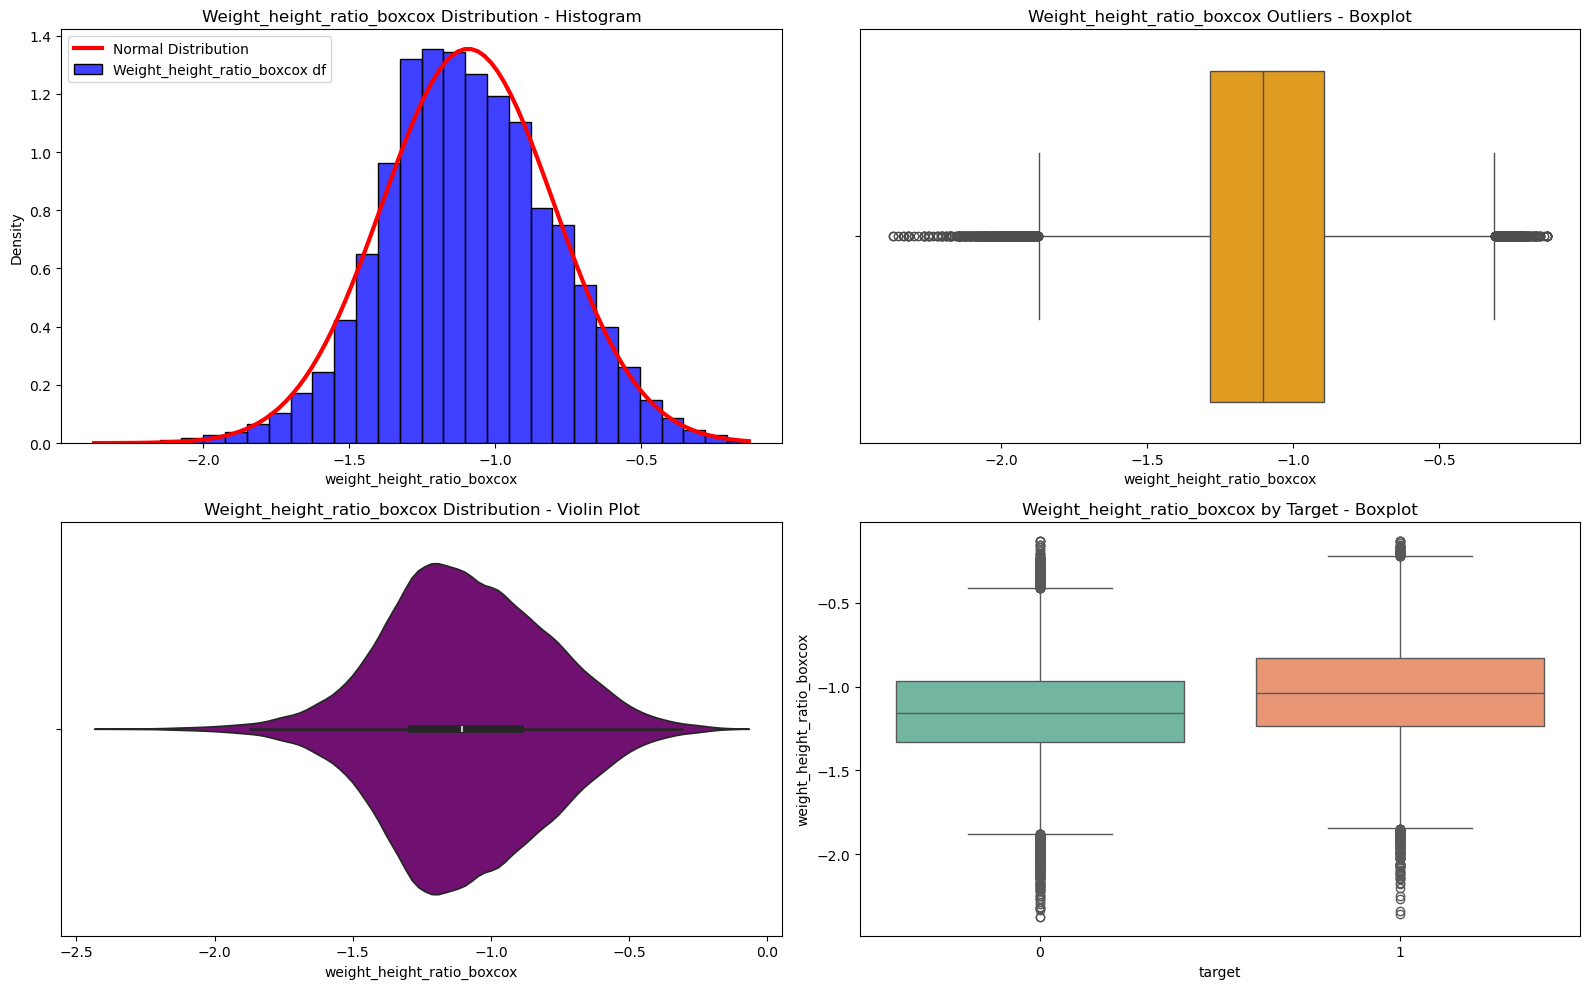

In [131]:
plot_numerical_feature(df, 'weight_height_ratio_boxcox')

##### `bsa - body surface area`

In [132]:
df['bsa'] = 0.007184 * (df['weight']**0.425) * (df['height']**0.725)

In [133]:
df[['weight', 'height', 'bsa']].sample(5)

weight  height       bsa
id                             
79100    68.0     164  1.741584
24856    90.0     155  1.883258
95231    70.0     167  1.786498
12868    95.0     175  2.104270
16217    73.0     160  1.763054

In [134]:
df['bsa'].describe()

count    69781.000000
mean         1.803526
std          0.173966
min          1.047133
25%          1.685962
50%          1.792291
75%          1.909686
max          2.712074
Name: bsa, dtype: float64

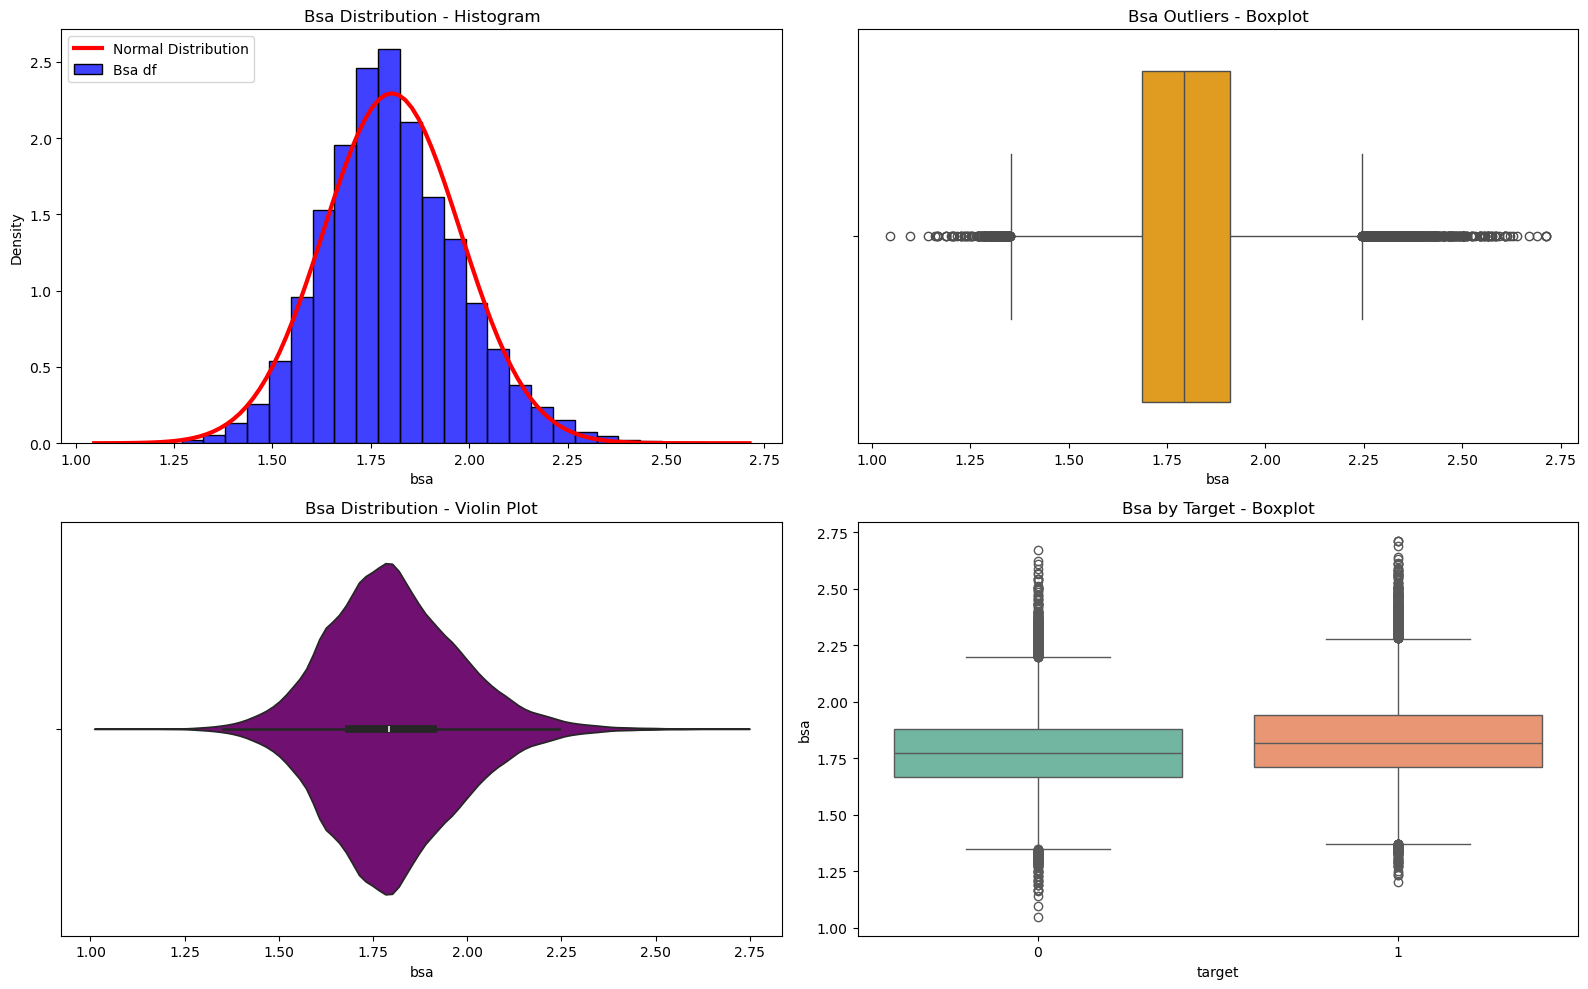

In [135]:
plot_numerical_feature(df, 'bsa')

In [136]:
skew_kurtosis(df, 'bsa')

BSA

Original:
Skewness: 0.38461345568767724, Kurtosis: 0.5806950886929987

Square Root Transformation:
Skewness: 0.2136174719539646, Kurtosis: 0.42130967967225885

Log1p Transformation:
Skewness: 0.16475938942319887, Kurtosis: 0.38365745235527493

Box-Cox Transformation:
Skewness: -0.0015943078549450797, Kurtosis: 0.38397324398852195



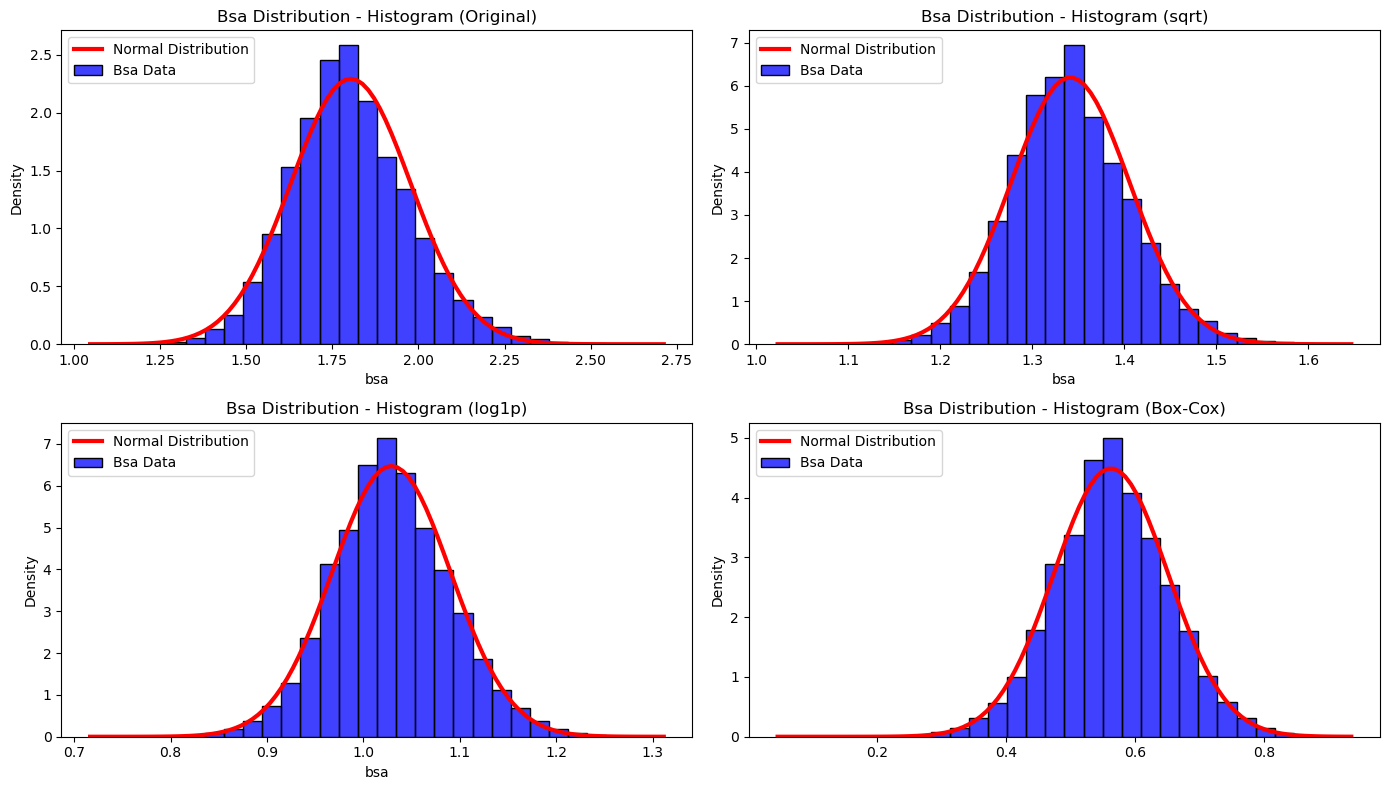

In [137]:
check_transform(df, 'bsa')

In [138]:
df['bsa_boxcox'], _ = boxcox(df['bsa'])

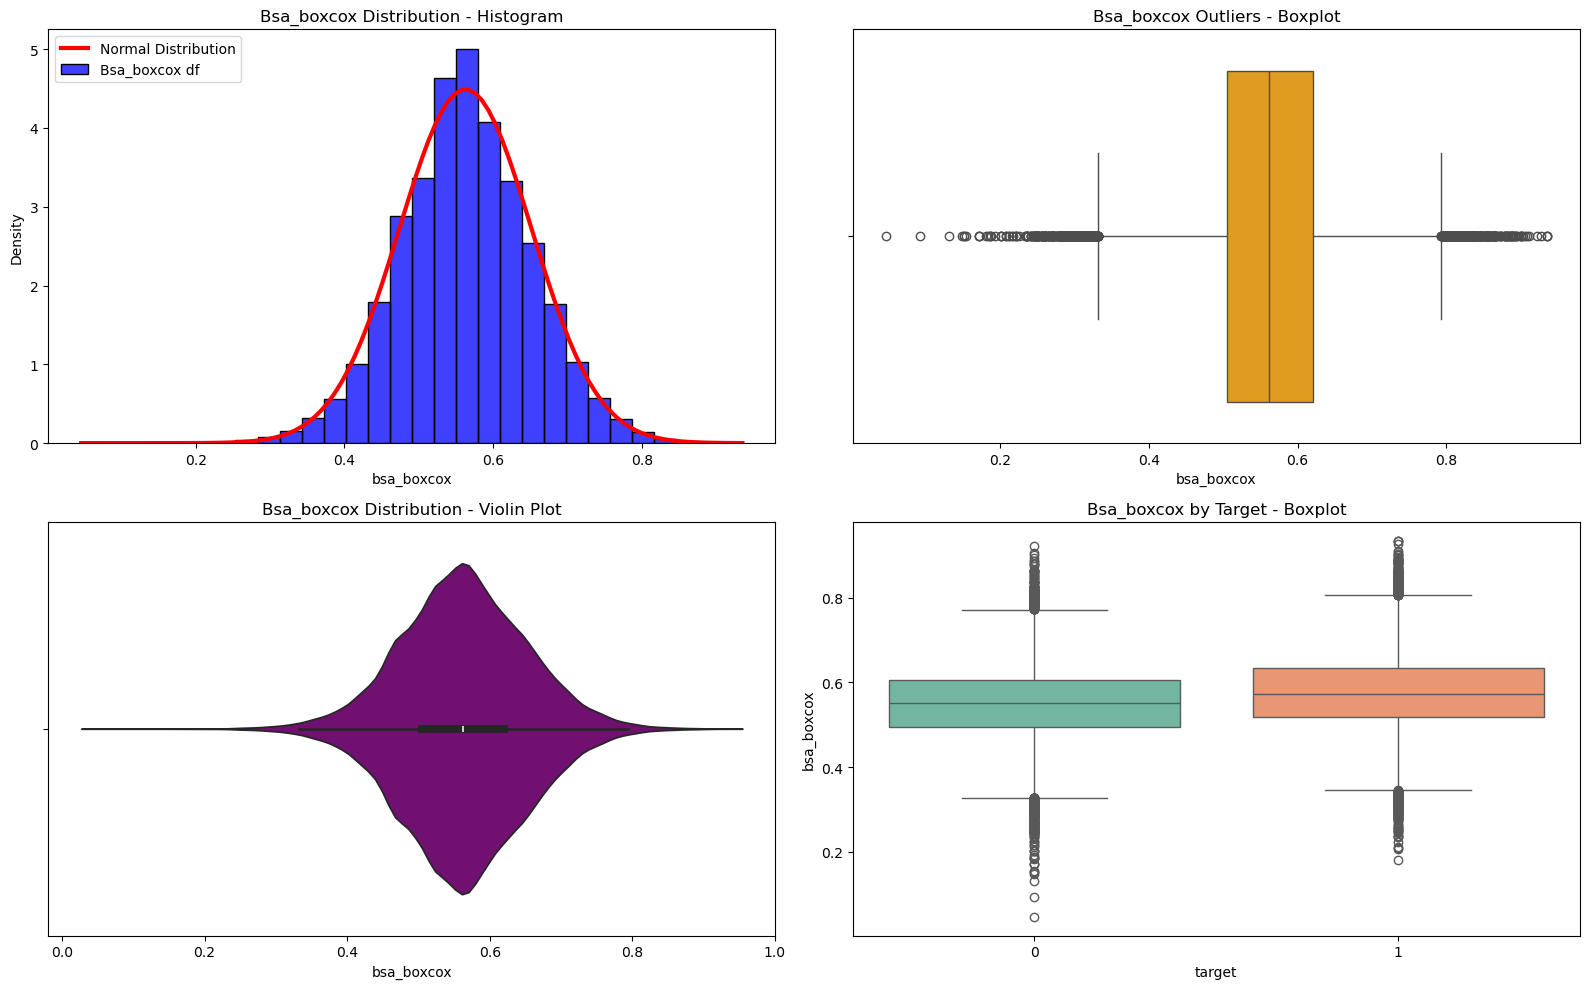

In [139]:
plot_numerical_feature(df, 'bsa_boxcox')

##### `pulse_pressure`

In [140]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

In [141]:
df[['ap_hi', 'ap_lo', 'pulse_pressure']].sample(5)

ap_hi  ap_lo  pulse_pressure
id                                 
33482    120     60              60
44972    160    100              60
60293    104     75              29
31391    120     80              40
81757    120     70              50

In [142]:
df['pulse_pressure'].describe()

count    69781.000000
mean        44.966180
std         12.265167
min        -40.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        130.000000
Name: pulse_pressure, dtype: float64

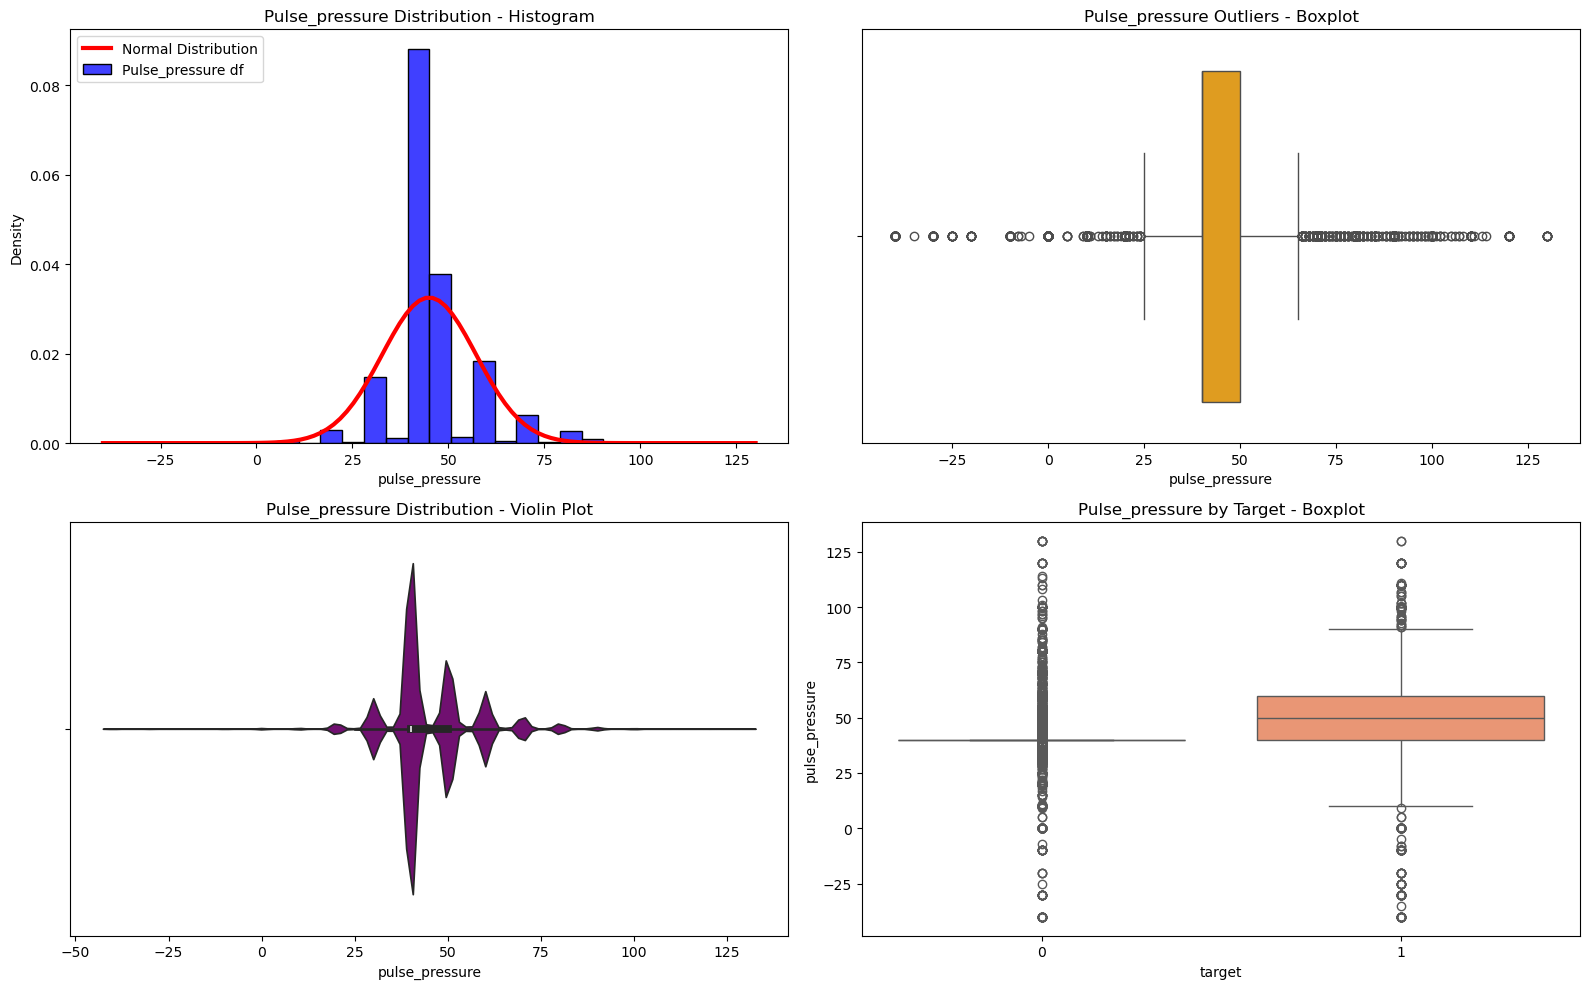

In [143]:
plot_numerical_feature(df, 'pulse_pressure')

In [144]:
# Drop rows where pulse pressure is < 20 or > 90
df = df[(df['pulse_pressure'] >= 20) & (df['pulse_pressure'] <= 90)]
df.shape

(69172, 31)

In [145]:
df['pulse_pressure'].describe()

count    69172.00000
mean        45.14902
std         11.17906
min         20.00000
25%         40.00000
50%         40.00000
75%         50.00000
max         90.00000
Name: pulse_pressure, dtype: float64

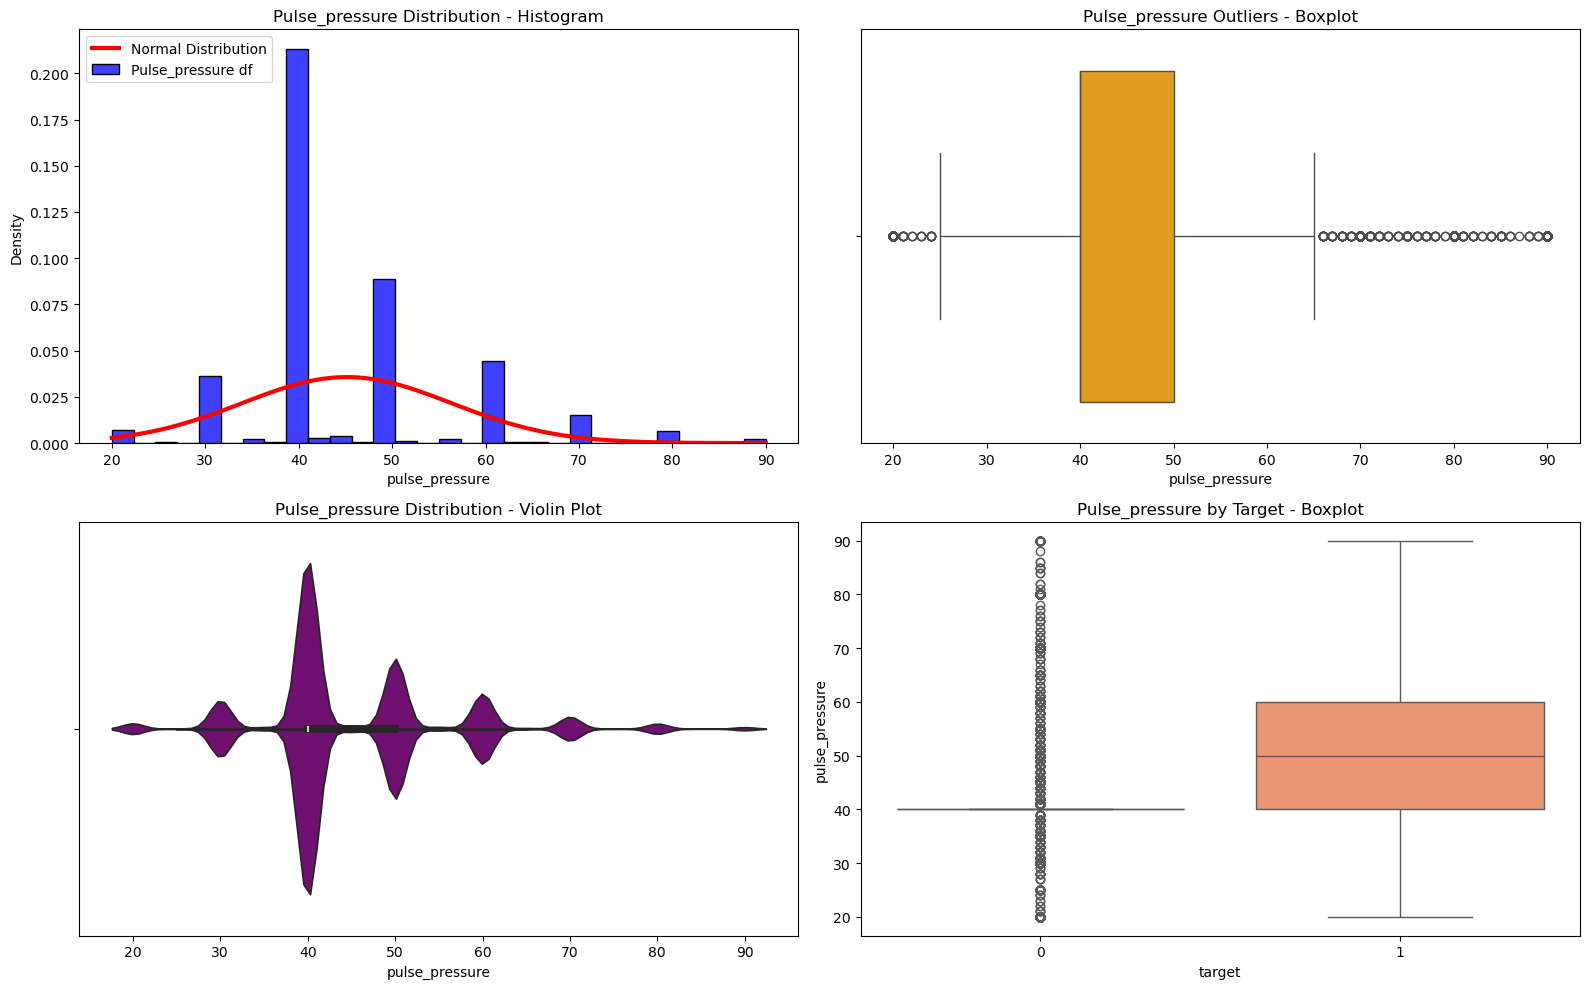

In [146]:
plot_numerical_feature(df, 'pulse_pressure')

In [147]:
skew_kurtosis(df, 'pulse_pressure')

PULSE_PRESSURE

Original:
Skewness: 1.0228184360940775, Kurtosis: 1.7372703370883311

Square Root Transformation:
Skewness: 0.538437660941564, Kurtosis: 1.1140971553283734

Log1p Transformation:
Skewness: 0.018743672916468813, Kurtosis: 1.2397448243325666

Box-Cox Transformation:
Skewness: 0.0009530040285333053, Kurtosis: 1.2673393548101561



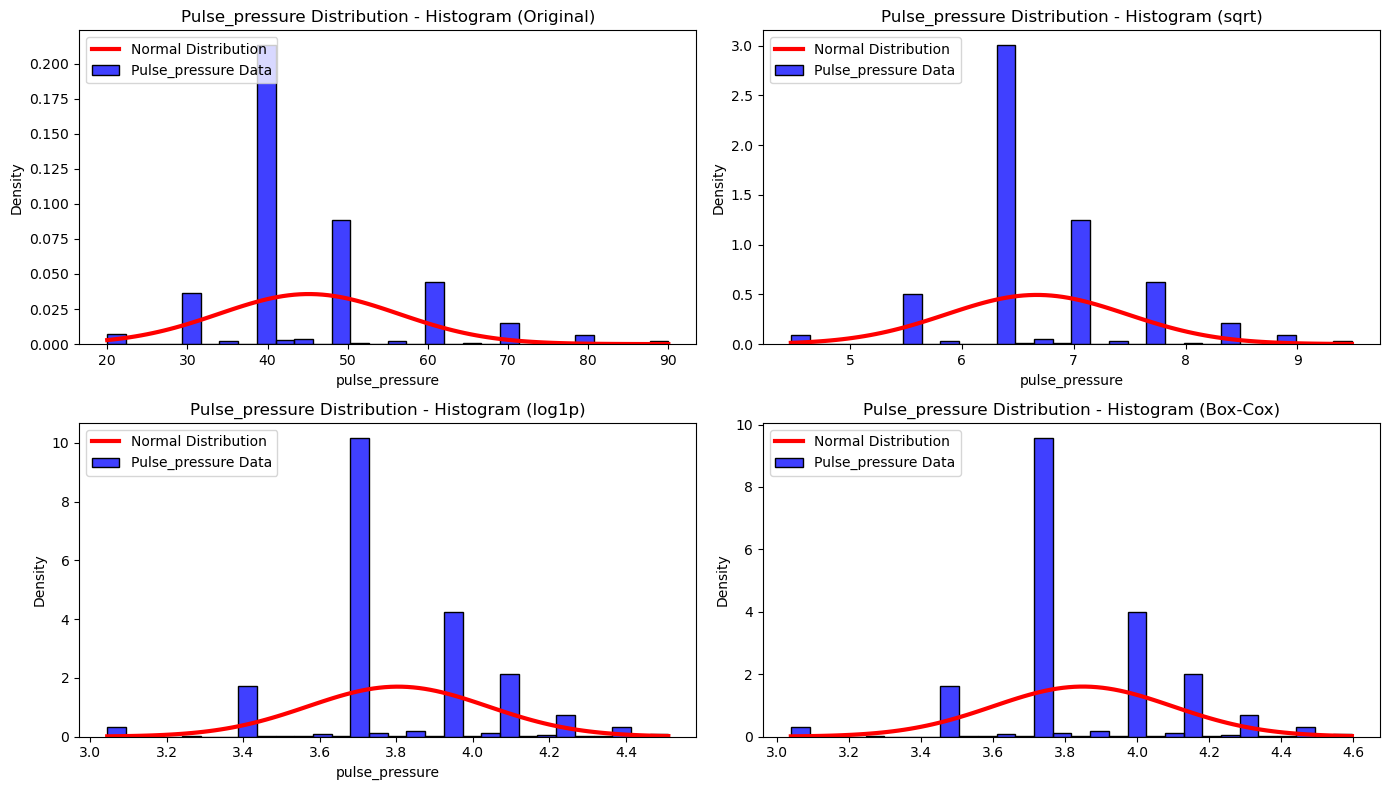

In [148]:
check_transform(df, 'pulse_pressure')

In [149]:
df['pulse_pressure_boxcox'], _ = boxcox(df['pulse_pressure'])

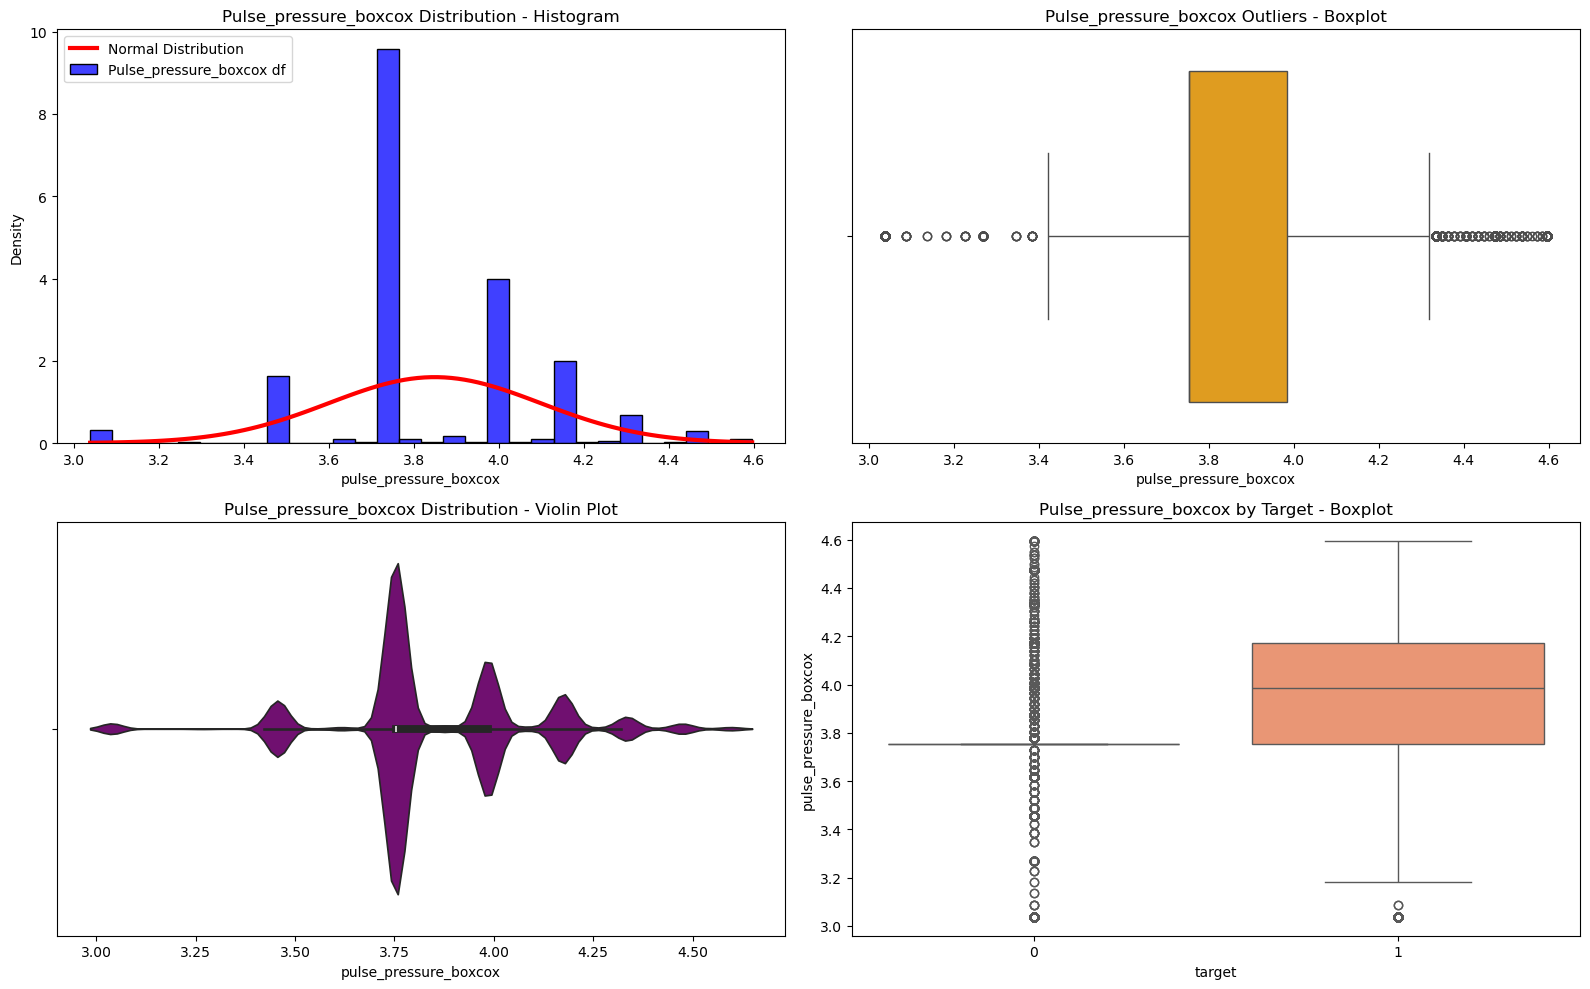

In [150]:
plot_numerical_feature(df, 'pulse_pressure_boxcox')

##### `mean_arterial_pressure`

In [151]:
df['mean_arterial_pressure'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3

In [152]:
df[['ap_hi', 'ap_lo', 'mean_arterial_pressure']].sample(5)

ap_hi  ap_lo  mean_arterial_pressure
id                                         
18068    120     80               93.333333
89628    150     90              110.000000
16793    130     80               96.666667
53488    110     80               90.000000
53243    130     70               90.000000

In [153]:
df['mean_arterial_pressure'].describe()

count    69172.000000
mean        96.822139
std         11.585616
min         60.000000
25%         93.333333
50%         93.333333
75%        103.333333
max        140.000000
Name: mean_arterial_pressure, dtype: float64

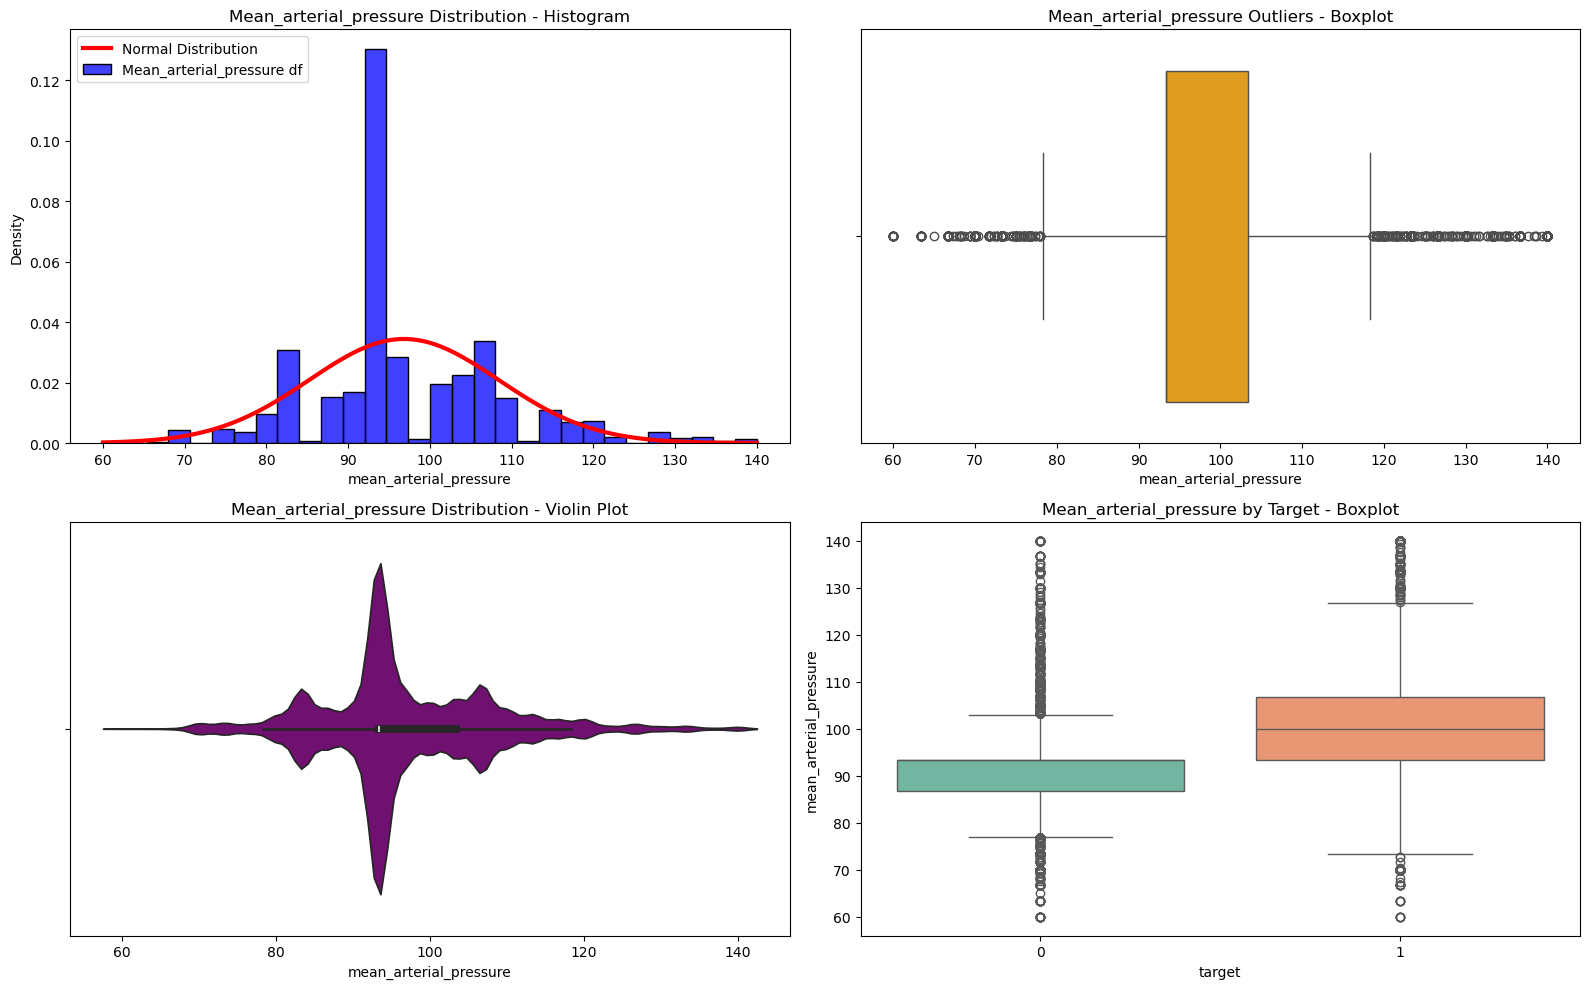

In [154]:
plot_numerical_feature(df, 'mean_arterial_pressure')

In [155]:
skew_kurtosis(df, 'mean_arterial_pressure')

MEAN_ARTERIAL_PRESSURE

Original:
Skewness: 0.6782257439531864, Kurtosis: 1.202900881544755

Square Root Transformation:
Skewness: 0.43908315927128, Kurtosis: 0.9261328047213091

Log1p Transformation:
Skewness: 0.20159581730185092, Kurtosis: 0.8168177201885345

Box-Cox Transformation:
Skewness: -0.013829920840139117, Kurtosis: 0.8615365758621722



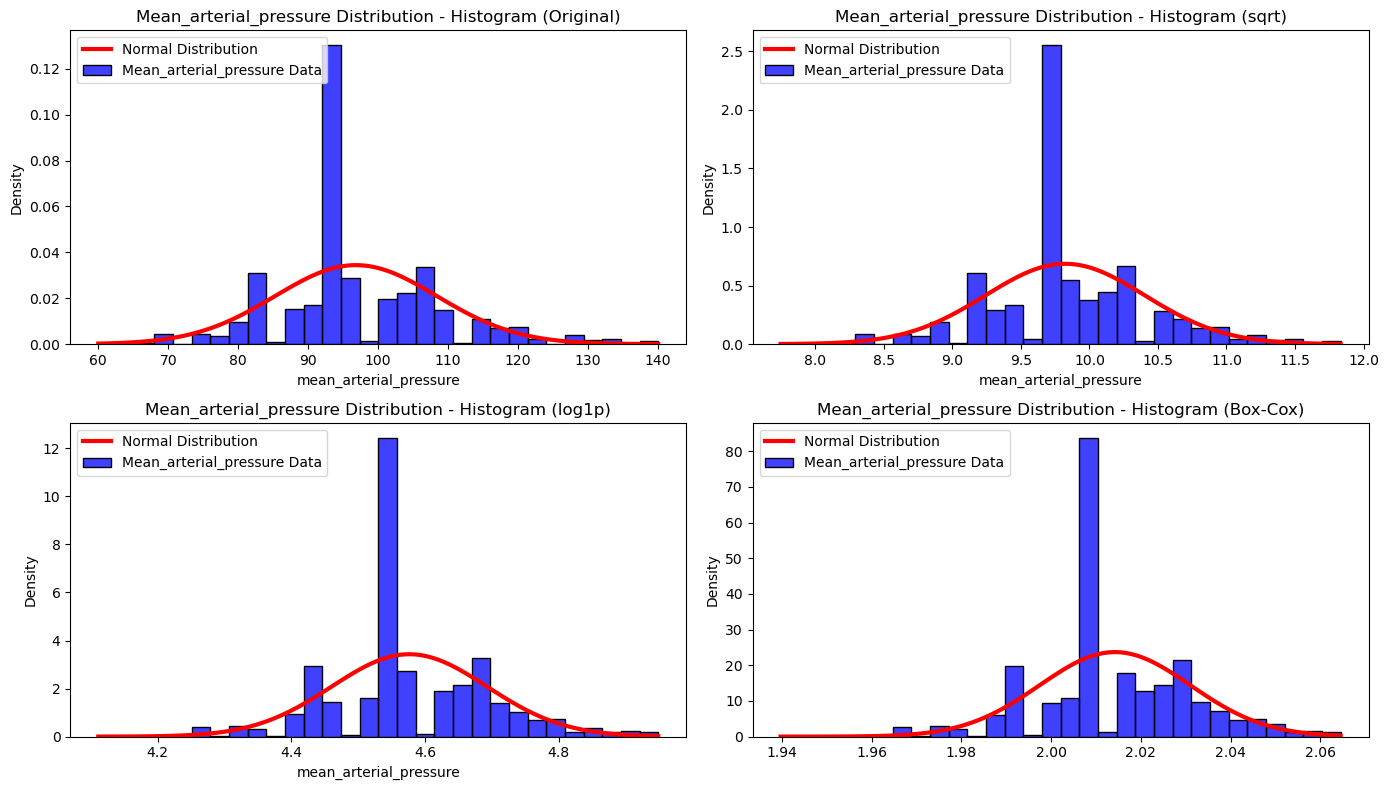

In [156]:
check_transform(df, 'mean_arterial_pressure')

In [157]:
df['mean_arterial_pressure_boxcox'], _ = boxcox(df['mean_arterial_pressure'])

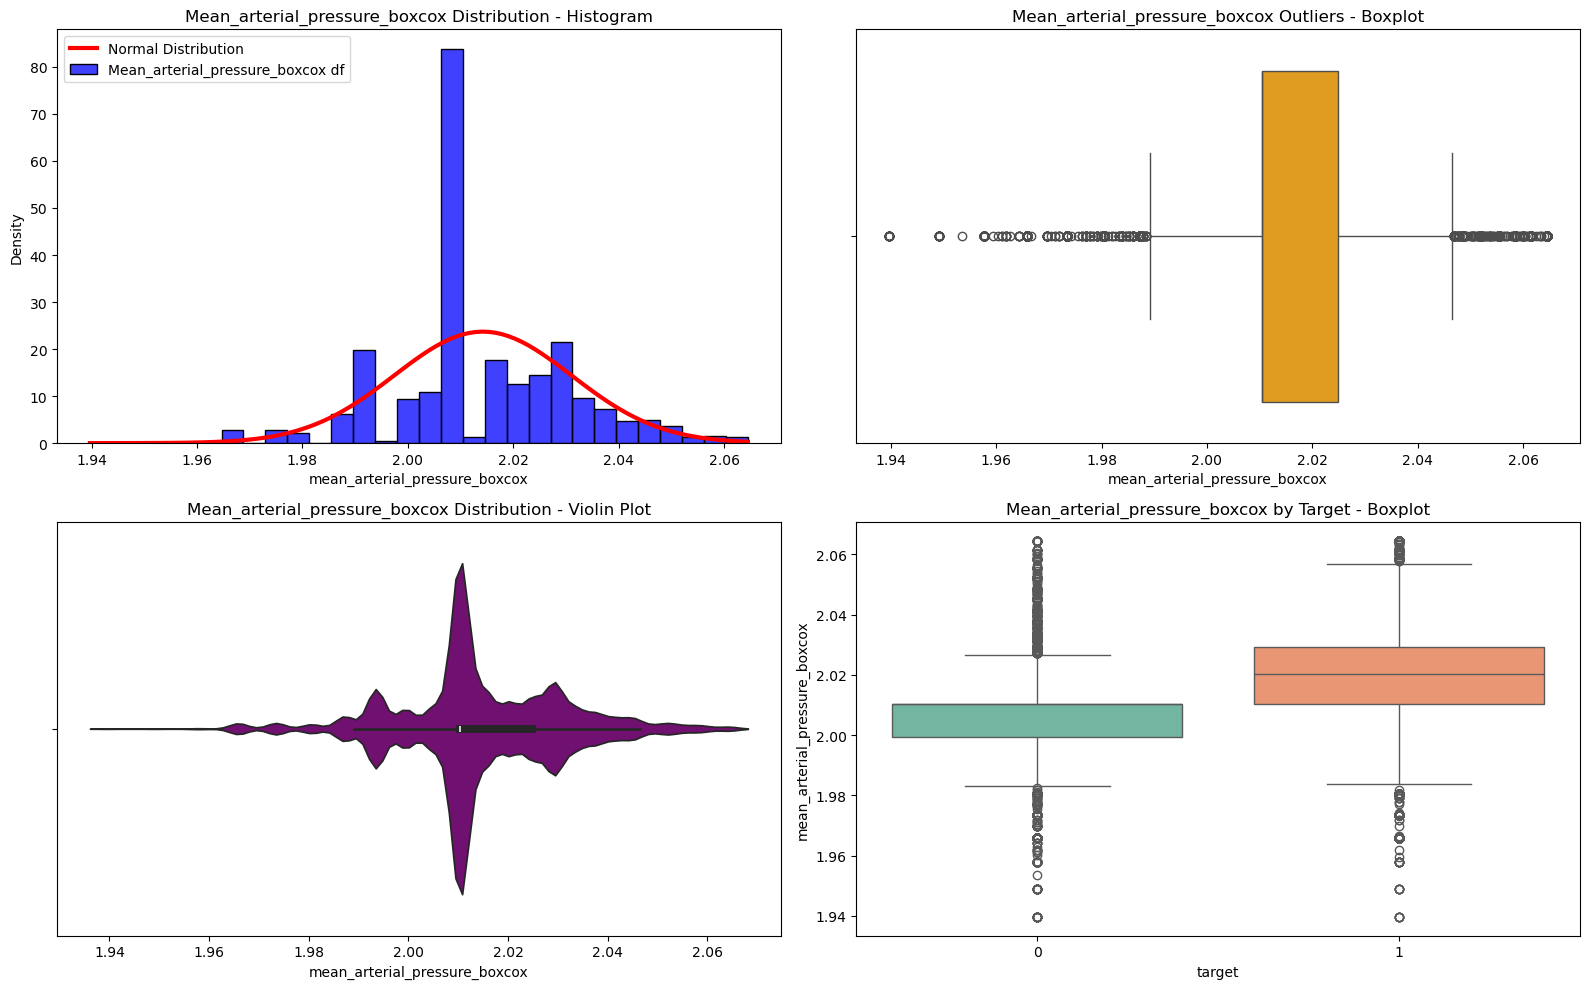

In [158]:
plot_numerical_feature(df, 'mean_arterial_pressure_boxcox')

##### `bp_ratio`

In [159]:
df['bp_ratio'] = df['ap_hi'] / df['ap_lo']

In [160]:
df[['ap_hi', 'ap_lo', 'bp_ratio']].sample(5)

ap_hi  ap_lo  bp_ratio
id                           
48741    170    120  1.416667
65003    120     80  1.500000
20614    160     90  1.777778
49965    150     90  1.666667
46999    120     70  1.714286

In [161]:
df['bp_ratio'].describe()

count    69172.000000
mean         1.557550
std          0.143232
min          1.166667
25%          1.500000
50%          1.500000
75%          1.625000
max          2.800000
Name: bp_ratio, dtype: float64

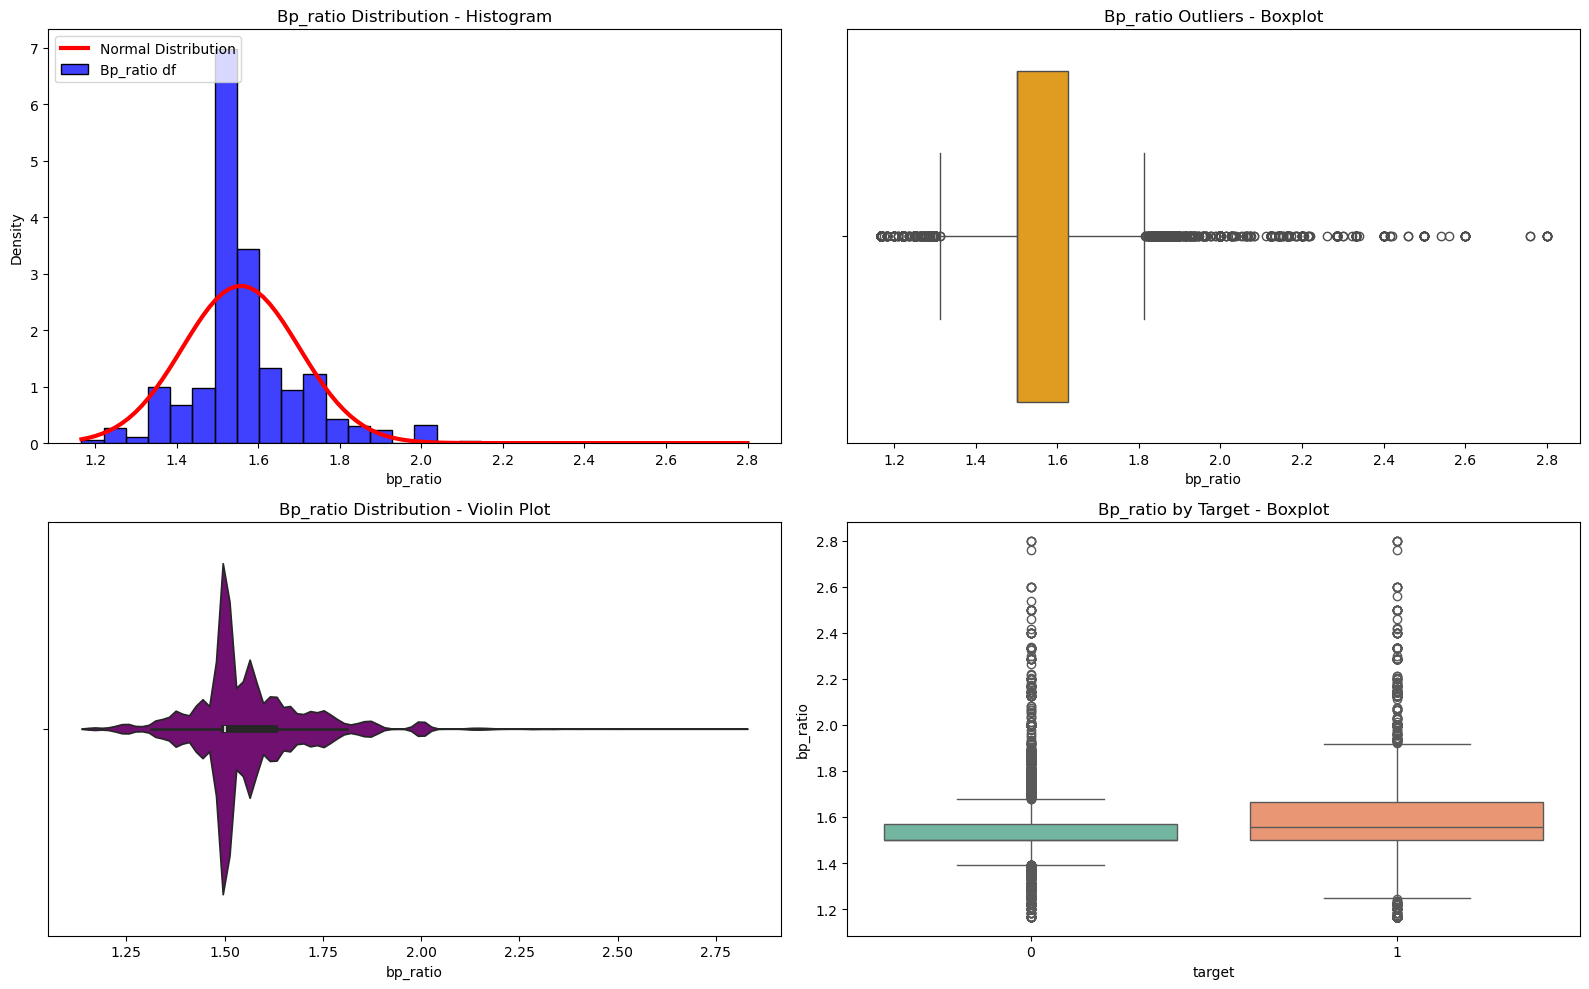

In [162]:
plot_numerical_feature(df, 'bp_ratio')

In [163]:
skew_kurtosis(df, 'bp_ratio')

BP_RATIO

Original:
Skewness: 1.332963509712126, Kurtosis: 4.5651940437841745

Square Root Transformation:
Skewness: 1.0433496784708616, Kurtosis: 3.381892984298437

Log1p Transformation:
Skewness: 0.9753194940333197, Kurtosis: 3.1214736379303663

Box-Cox Transformation:
Skewness: -0.08974292873825836, Kurtosis: 2.0156009570313485



In [164]:
df['bp_ratio_boxcox'], _ = boxcox(df['bp_ratio'])

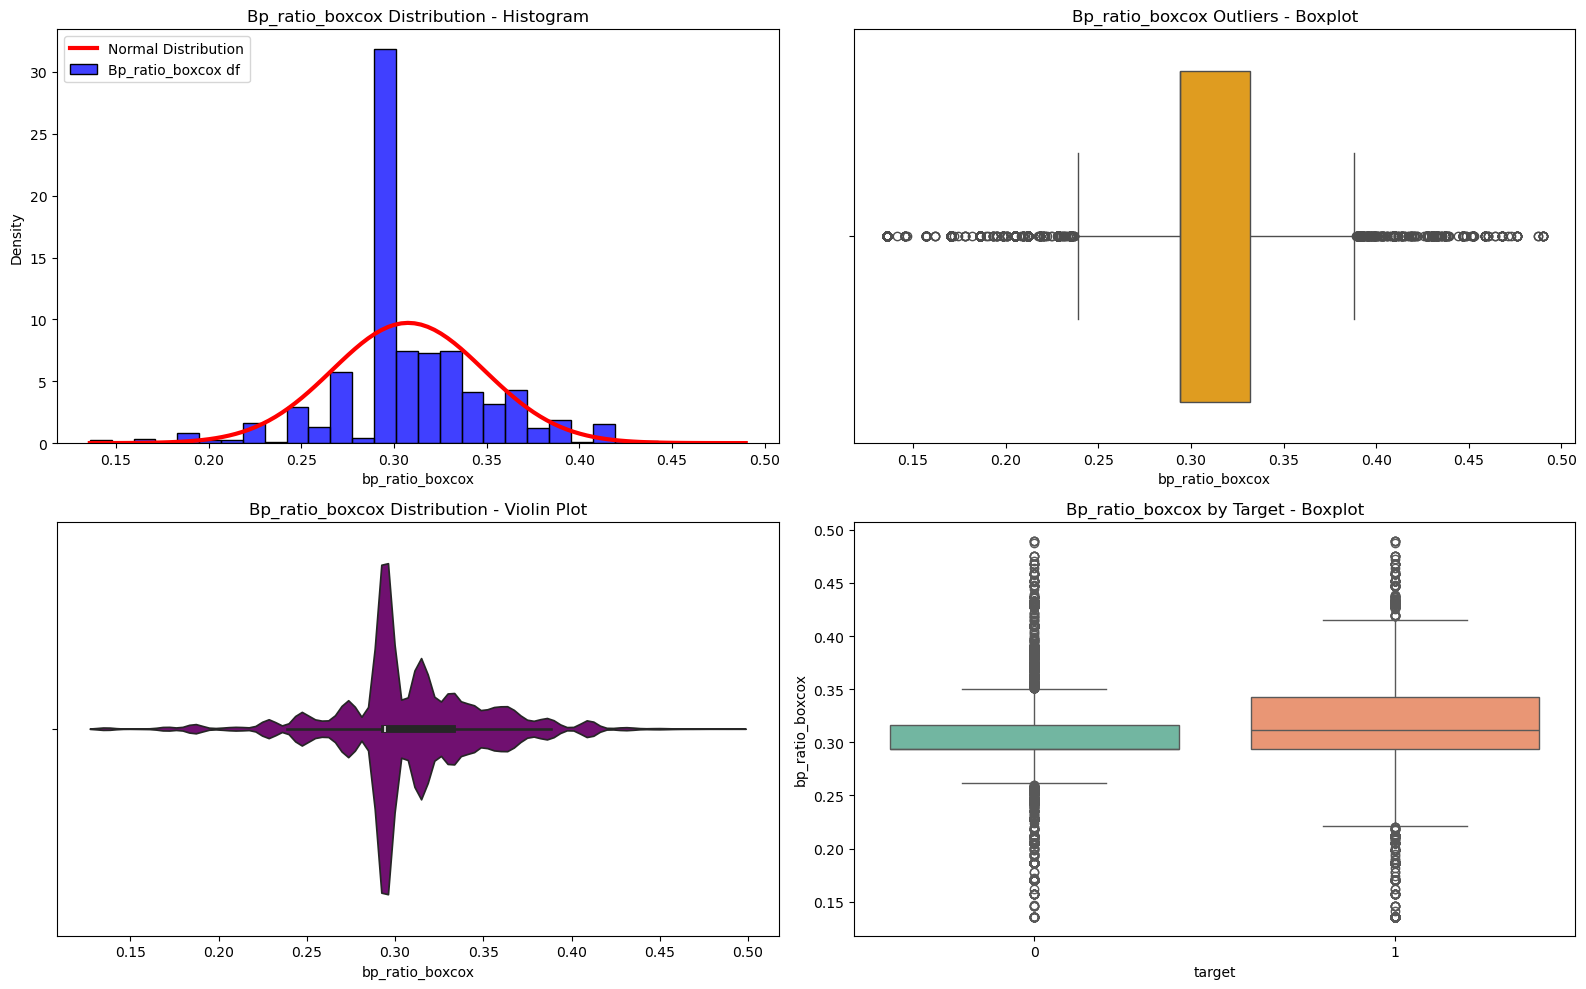

In [165]:
plot_numerical_feature(df, 'bp_ratio_boxcox')

##### `chol_gluc_risk`

In [166]:
def risk_level(row):
    if row['cholesterol'] == 0 and row['gluc'] == 0:
        return 0  # Low risk
    elif row['cholesterol'] == 2 or row['gluc'] == 2:
        return 2  # High risk
    else:
        return 1  # Moderate risk

df['chol_gluc_risk'] = df.apply(risk_level, axis=1)

In [167]:
df[['cholesterol', 'gluc', 'chol_gluc_risk']].sample(5)

cholesterol  gluc  chol_gluc_risk
id                                      
55752            0     0               0
4853             0     0               0
56578            0     0               0
14587            0     0               0
92595            2     0               2

In [168]:
df['chol_gluc_risk'].describe()

count    69172.000000
mean         0.446192
std          0.728568
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: chol_gluc_risk, dtype: float64

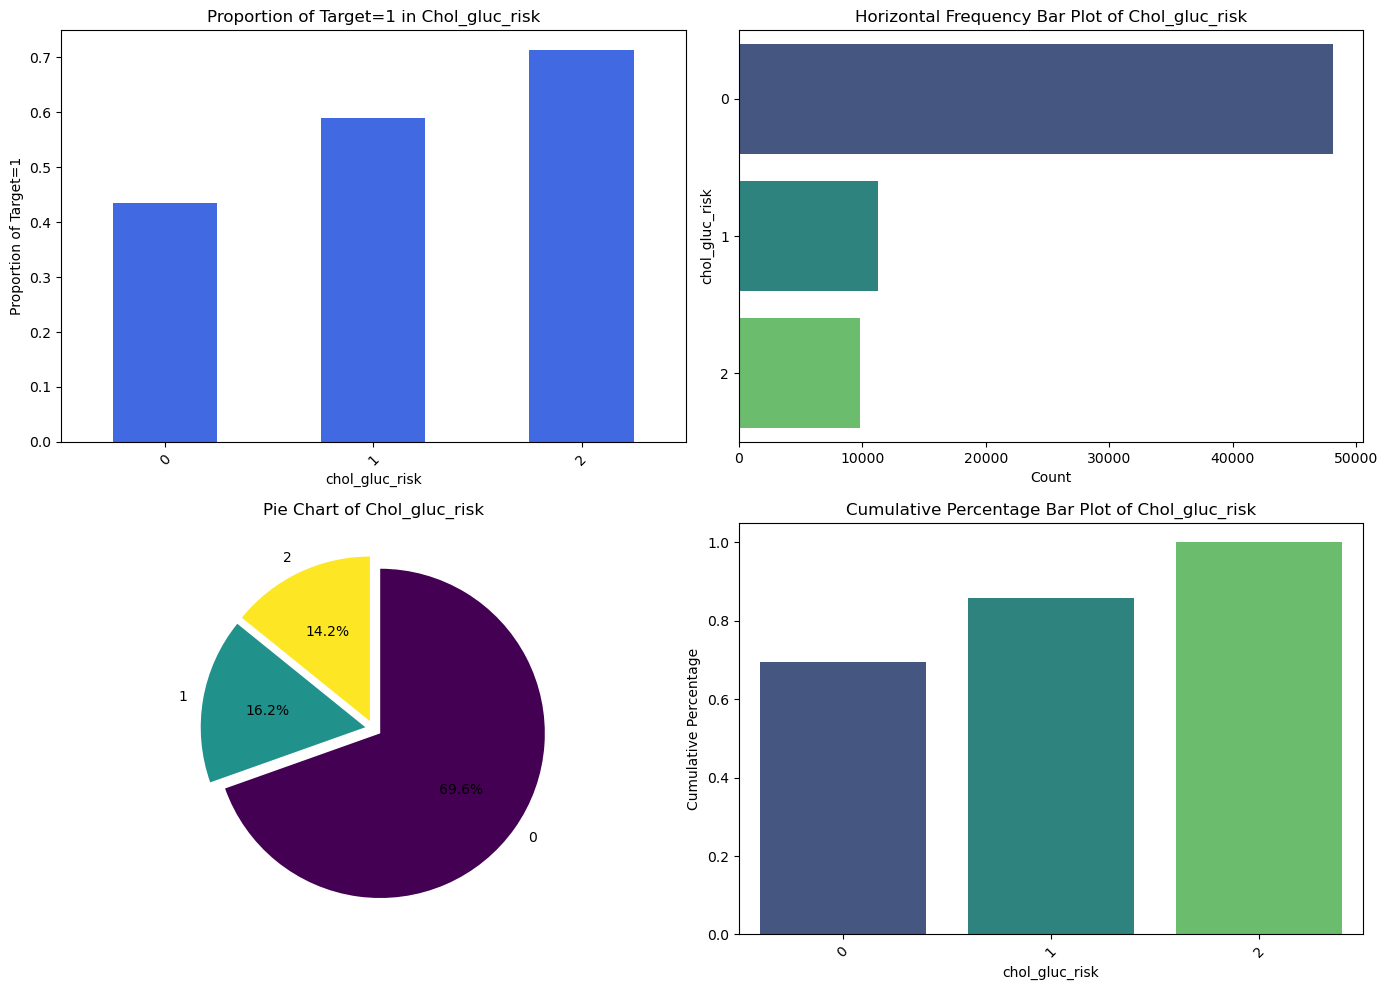

In [169]:
plot_categorical_feature(df, 'chol_gluc_risk')

##### `health_conscious`

In [170]:
df['health_conscious'] = ((df['smoke'] == 0) & (df['alco'] == 0) & (df['active'] == 1)).astype(int)

In [171]:
df[['smoke', 'alco', 'active', 'health_conscious']].sample(5)

smoke  alco  active  health_conscious
id                                          
20141      0     0       1                 1
72731      0     0       0                 0
36571      0     0       1                 1
4256       0     0       0                 0
97330      0     0       1                 1

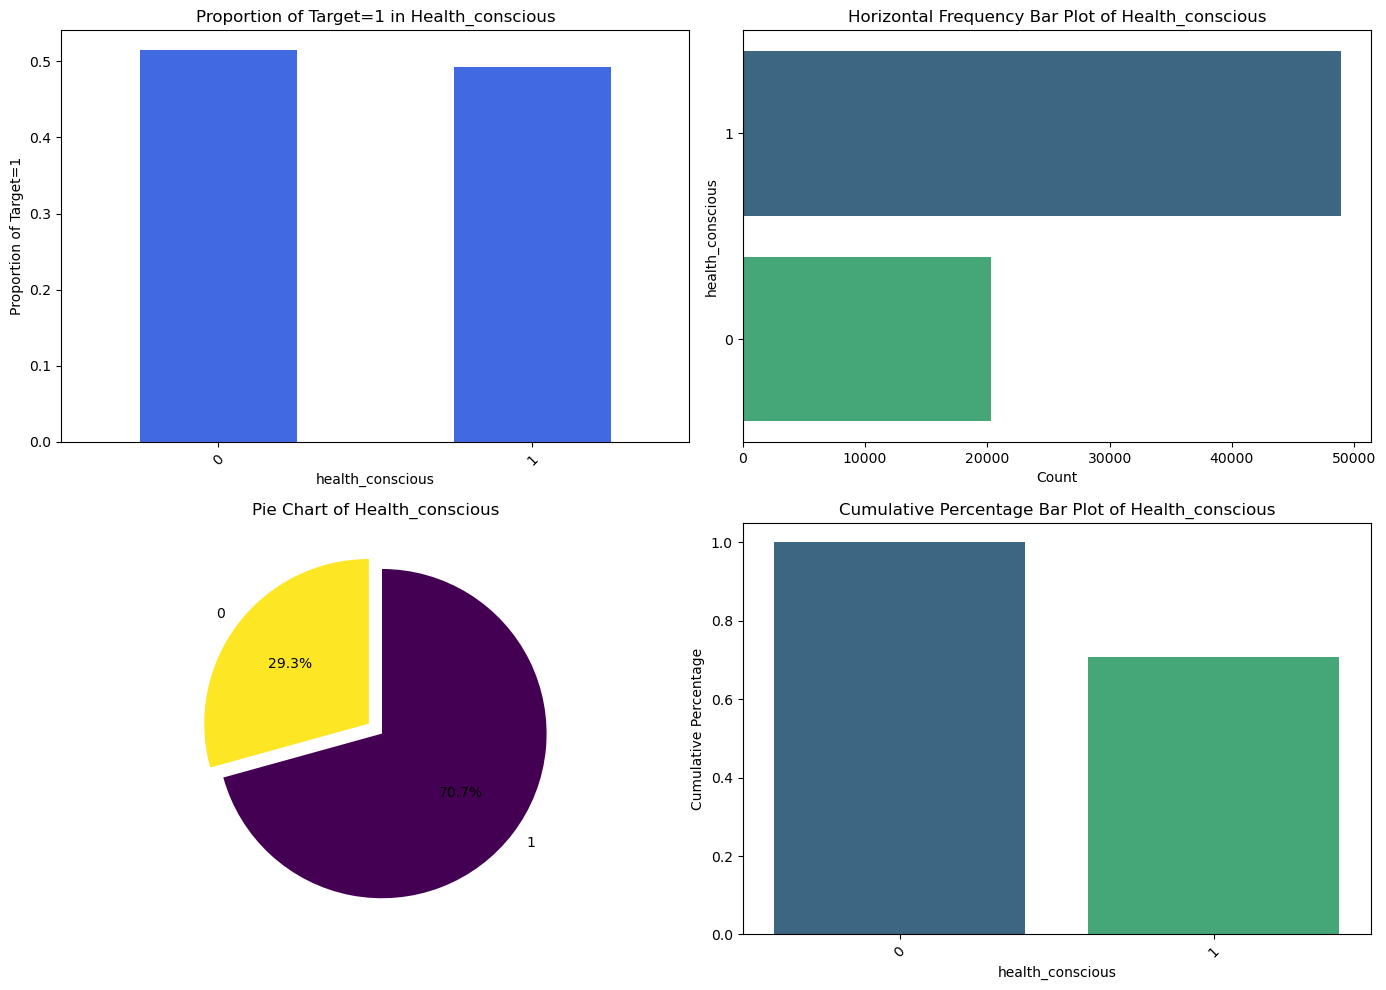

In [172]:
plot_categorical_feature(df, 'health_conscious')

##### `lifestyle_risk_score`

In [173]:
df['lifestyle_risk_score'] = df['smoke'] + df['alco'] + (1 - df['active'])

In [174]:
df[['smoke', 'alco', 'active', 'lifestyle_risk_score']].sample(5)

smoke  alco  active  lifestyle_risk_score
id                                              
37679      0     0       1                     0
51745      0     0       1                     0
66865      0     0       1                     0
28736      0     0       1                     0
51418      0     0       1                     0

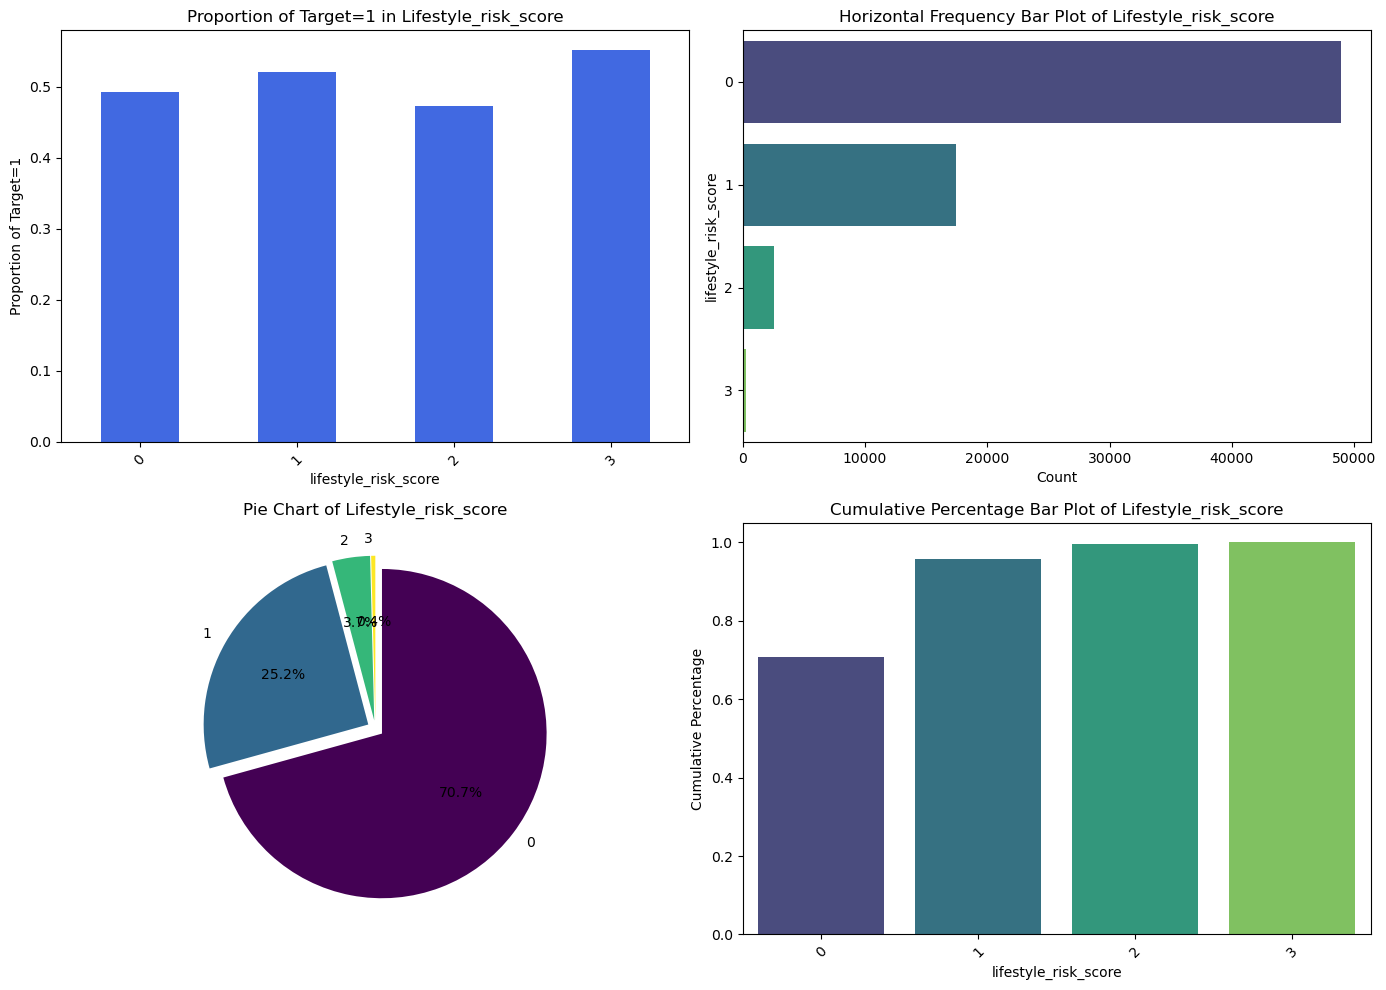

In [175]:
plot_categorical_feature(df, 'lifestyle_risk_score')

##### `high_risk_lifestyle`

In [176]:
df['high_risk_lifestyle'] = ((df['smoke'] + df['alco'] + (1 - df['active'])) >= 2).astype(int)

In [177]:
df[['smoke', 'alco', 'active', 'high_risk_lifestyle']].sample(5)

smoke  alco  active  high_risk_lifestyle
id                                             
53961      0     0       1                    0
81432      0     0       0                    0
51497      0     0       1                    0
54650      0     0       1                    0
14182      0     0       0                    0

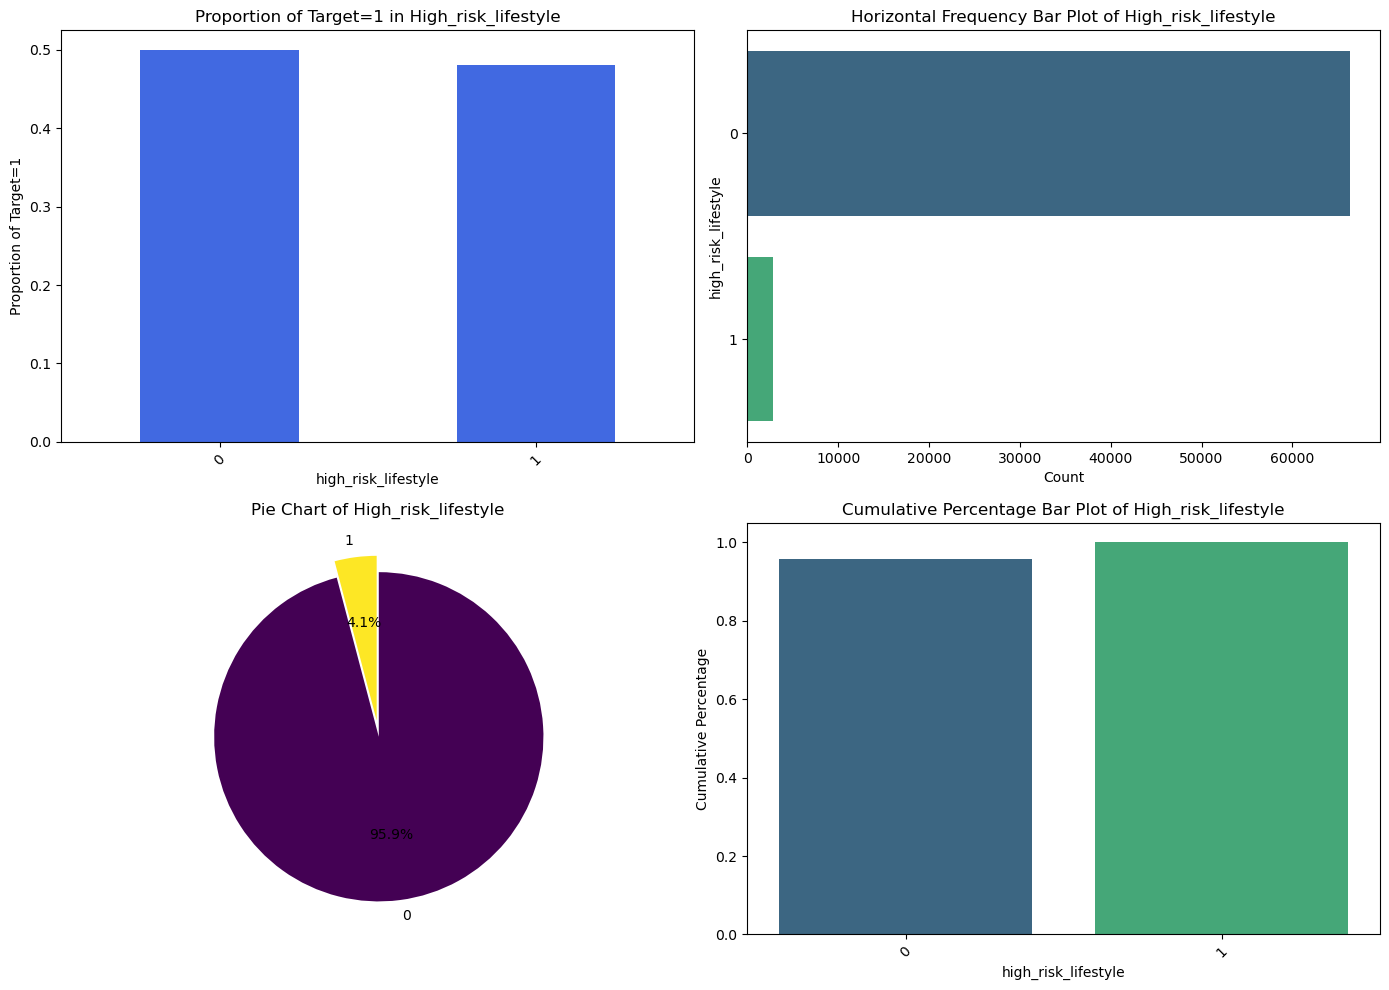

In [178]:
plot_categorical_feature(df, 'high_risk_lifestyle')

##### `age_group`

In [179]:
df.age.describe()

count    69172.000000
mean        52.837868
std          6.766832
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [180]:
bins = [20, 30, 40, 50, 60, 70]
labels = [0, 1, 2, 3, 4]

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

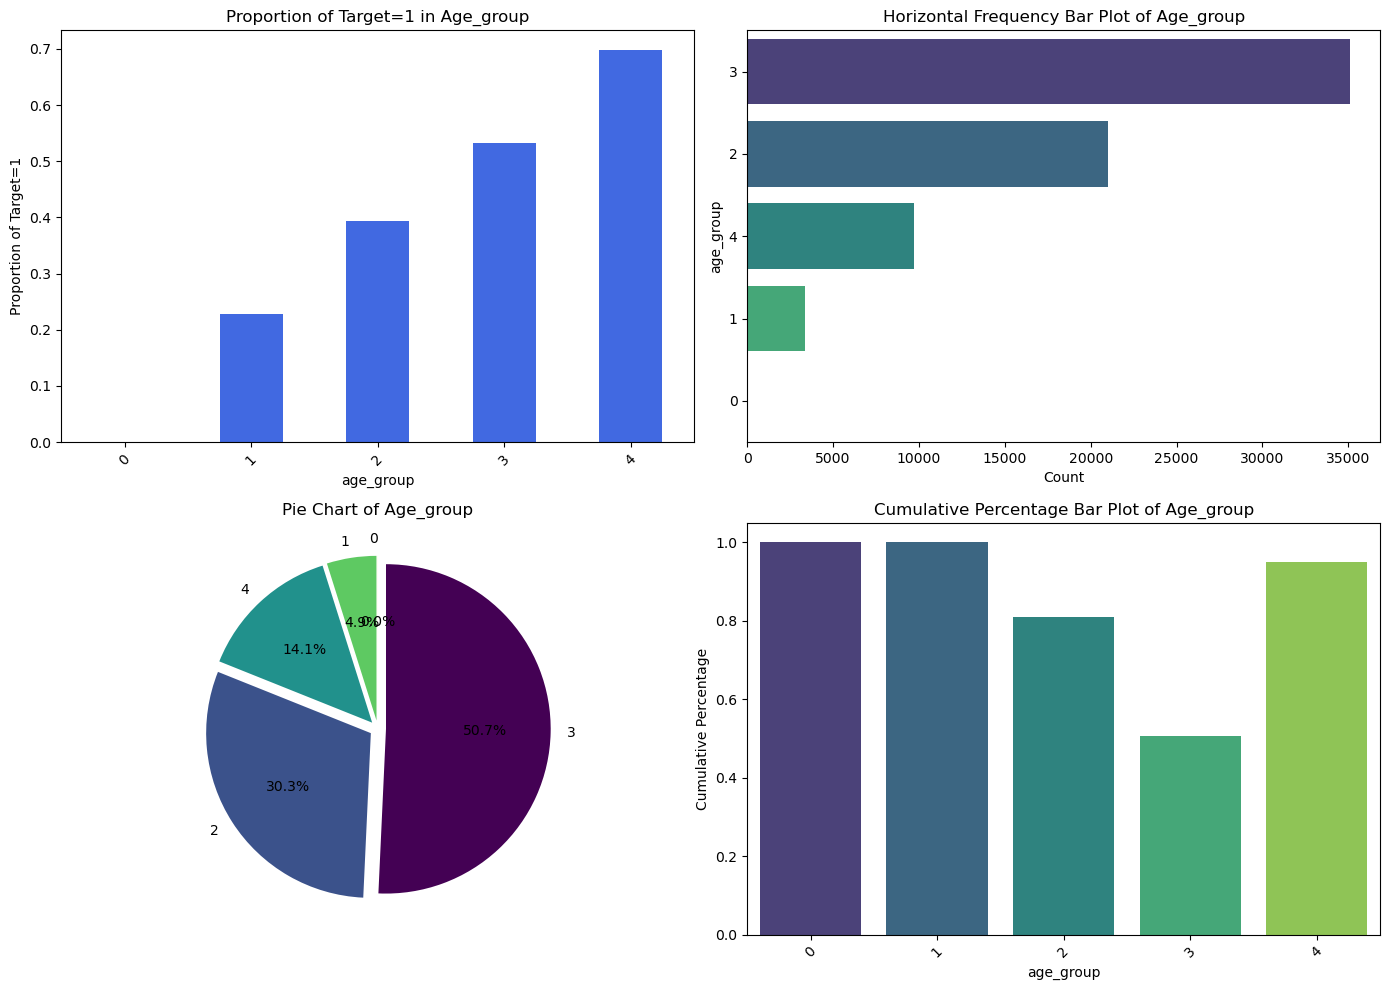

In [181]:
plot_categorical_feature(df, 'age_group')

In [182]:
# One-hot encoding for age_group column
df = pd.get_dummies(df, columns=['age_group'], drop_first=False, dtype=int)

In [183]:
df[['age', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4']].sample(5)

age  age_group_0  age_group_1  age_group_2  age_group_3  age_group_4
id                                                                         
13929   55            0            0            0            1            0
71562   58            0            0            0            1            0
50420   50            0            0            1            0            0
19538   61            0            0            0            0            1
32344   43            0            0            1            0            0

##### `age_gender_group`

In [184]:
def age_gender_group(age, gender):
    if age < 30:
        return 'young_male' if gender == 1 else 'young_female'
    elif 30 <= age < 50:
        return 'middle_aged_male' if gender == 1 else 'middle_aged_female'
    else:
        return 'senior_male' if gender == 1 else 'senior_female'

# Function to create the 'age_gender_group' column
df['age_gender_group'] = df.apply(lambda x: age_gender_group(x['age'], x['gender']), axis=1)

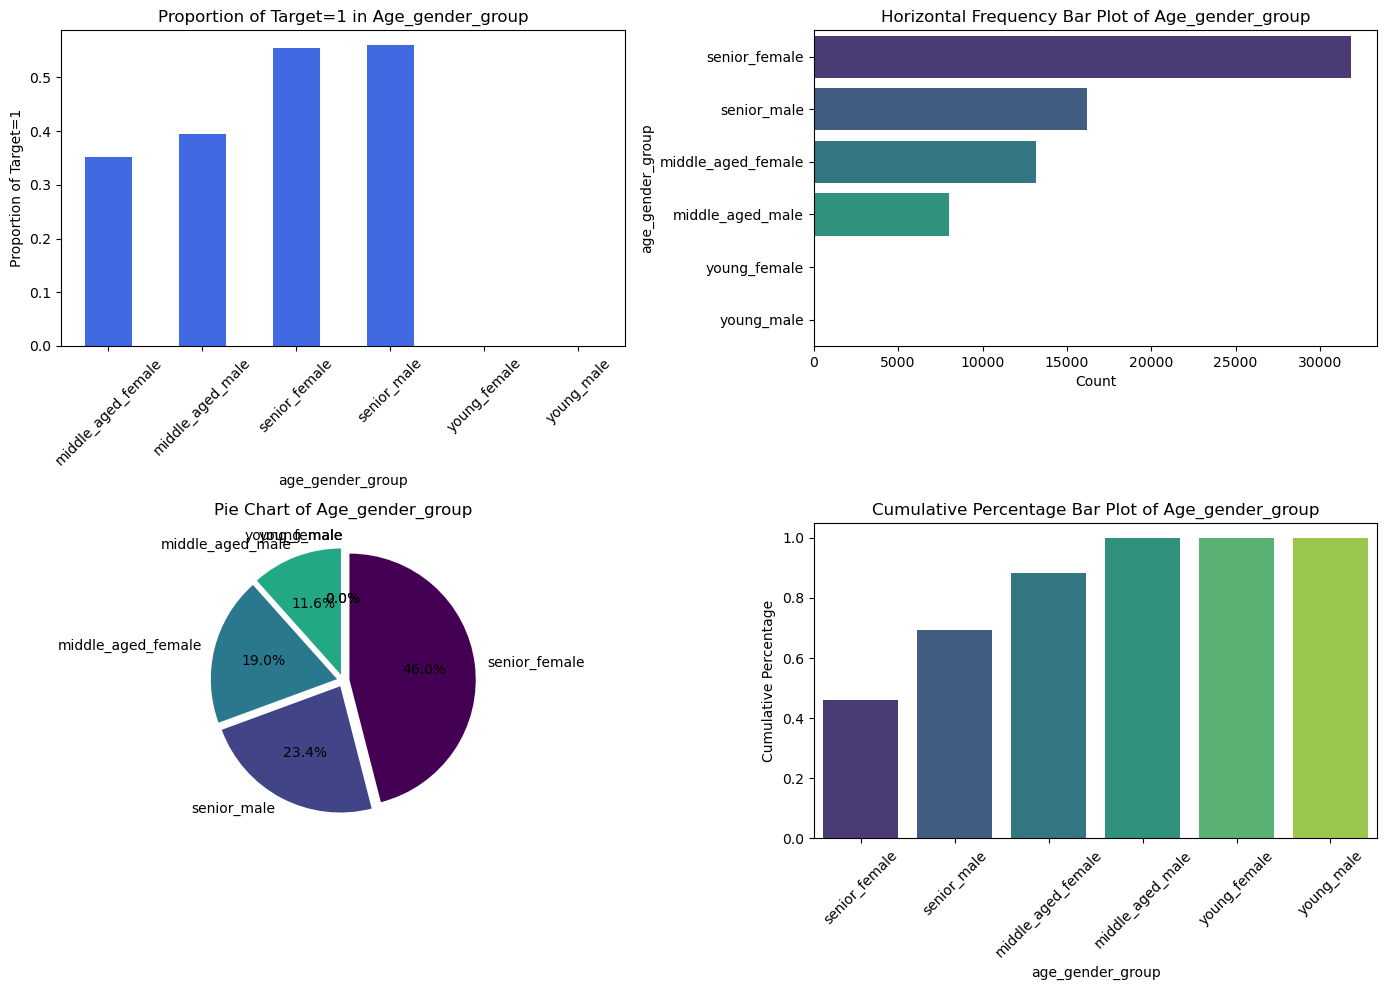

In [185]:
plot_categorical_feature(df, 'age_gender_group')

In [186]:
# One-hot encoding for age_group column
df = pd.get_dummies(df, columns=['age_gender_group'], drop_first=False, dtype=int)

In [187]:
df[['age', 'gender', 'age_gender_group_young_male', 'age_gender_group_young_female', 'age_gender_group_middle_aged_male', 
    'age_gender_group_middle_aged_female', 'age_gender_group_senior_male', 'age_gender_group_senior_female']].sample(5)

age  gender  age_gender_group_young_male  \
id                                                
39875   59       0                            0   
11251   46       0                            0   
40493   47       1                            0   
68524   40       0                            0   
93616   56       0                            0   

       age_gender_group_young_female  age_gender_group_middle_aged_male  \
id                                                                        
39875                              0                                  0   
11251                              0                                  0   
40493                              0                                  1   
68524                              0                                  0   
93616                              0                                  0   

       age_gender_group_middle_aged_female  age_gender_group_senior_male  \
id                                                                         
39875                                    0                             0   
11251                                    1                             0   
40493                                    0                             0   
68524                                    1                             0   
93616                                    0                             0   

       age_gender_group_senior_female  
id                                     
39875                               1  
11251                               0  
40493                               0  
68524                               0  
93616                               1

### `Exploring New Dataset`

In [192]:
df.sample(10)

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                           
46158   45       0     160    75.0    110     80            0     0      0   
4161    59       0     152    60.0    140     90            0     0      0   
40758   54       1     169    79.0    120     80            0     0      0   
22045   49       1     172    80.0    140     90            0     0      0   
49149   53       0     163    70.0     90     60            0     0      0   
35268   63       1     160    70.0    160     80            0     0      0   
94190   53       0     160    76.0    140     90            2     0      0   
57248   59       0     154    73.0     90     60            2     2      0   
30380   40       0     161    49.0     90     60            0     0      0   
16893   58       0     169    70.0    120     80            0     0      0   

       alco  active  target   age_boxcox  height_boxcox  weight_boxcox  \
id                                                                       
46158     0       1       1  1140.218687    2127.537683       2.211759   
4161      0       1       1  1979.622917    1959.568072       2.161425   
40758     0       0       1  1652.950525    2322.644478       2.222919   
22045     0       1       1  1356.178294    2389.101732       2.225590   
49149     0       0       1  1591.207273    2191.857338       2.196619   
35268     0       1       0  2262.553461    2127.537683       2.196619   
94190     0       1       1  1591.207273    2127.537683       2.214623   
57248     0       1       1  1979.622917    2001.072778       2.205872   
30380     0       1       0   896.995947    2148.897502       2.112168   
16893     0       0       0  1911.891720    2322.644478       2.196619   

       ap_hi_boxcox  ap_lo_boxcox        bmi  bmi_boxcox  bmi_category  \
id                                                                       
46158      2.135039      3.172755  29.296875    1.029535             2   
4161       2.170909      3.231601  25.969529    1.024004             2   
40758      2.148377      3.172755  27.660096    1.026974             2   
22045      2.170909      3.231601  27.041644    1.025929             2   
49149      2.102471      3.024390  26.346494    1.024698             2   
35268      2.189348      3.172755  27.343750    1.026445             2   
94190      2.170909      3.231601  29.687500    1.030105             2   
57248      2.102471      3.024390  30.780907    1.031628             3   
30380      2.102471      3.024390  18.903592    1.006091             1   
16893      2.148377      3.172755  24.508946    1.021120             1   

       age_to_bmi_ratio  age_to_bmi_ratio_boxcox  age_bmi_interaction  \
id                                                                      
46158          1.536000                 0.487878          1318.359375   
4161           2.271893                 1.053331          1532.202216   
40758          1.952271                 0.818821          1493.645180   
22045          1.812020                 0.710923          1325.040562   
49149          2.011653                 0.863531          1396.364184   
35268          2.304000                 1.076106          1722.656250   
94190          1.785263                 0.689950          1573.437500   
57248          1.916773                 0.791824          1816.073537   
30380          2.116000                 0.940790           756.143667   
16893          2.366483                 1.120055          1421.518854   

       age_bmi_interaction_boxcox  body_fat_indicator  \
id                                                      
46158                    5.100363           13.183594   
4161                     5.172306           15.322022   
40758                    5.160185           14.936452   
22045                    5.102800           13.250406   
49149                    5.128004           13.963642   
35268           

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69172 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  69172 non-null  int64  
 1   gender                               69172 non-null  int64  
 2   height                               69172 non-null  int64  
 3   weight                               69172 non-null  float64
 4   ap_hi                                69172 non-null  int64  
 5   ap_lo                                69172 non-null  int64  
 6   cholesterol                          69172 non-null  int64  
 7   gluc                                 69172 non-null  int64  
 8   smoke                                69172 non-null  int64  
 9   alco                                 69172 non-null  int64  
 10  active                               69172 non-null  int64  
 11  target                           

In [190]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69172.000000  69172.000000  69172.000000  69172.000000  69172.000000   
mean      52.837868      0.349968    164.416296     74.121254    126.921486   
std        6.766832      0.476963      7.902920     14.071448     16.577863   
min       29.000000      0.000000    120.000000     35.000000     80.000000   
25%       48.000000      0.000000    159.000000     65.000000    120.000000   
50%       53.000000      0.000000    165.000000     72.000000    120.000000   
75%       58.000000      1.000000    170.000000     82.000000    140.000000   
max       64.000000      1.000000    190.000000    150.000000    180.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69172.000000  69172.000000  69172.000000  69172.000000  69172.000000   
mean      81.772466      0.366651      0.225785      0.088374      0.053606   
std       10.275412      0.680280      0.571545      0.283840      0.225239   
min       50.000000      0.000000      0.000000      0.000000      0.000000   
25%       80.000000      0.000000      0.000000      0.000000      0.000000   
50%       80.000000      0.000000      0.000000      0.000000      0.000000   
75%       90.000000      1.000000      0.000000      0.000000      0.000000   
max      120.000000      2.000000      2.000000      1.000000      1.000000   

             active        target    age_boxcox  height_boxcox  weight_boxcox  \
count  69172.000000  69172.000000  69172.000000   69172.000000   69172.000000   
mean       0.803808      0.498843   1608.654952    2224.954731       2.204134   
std        0.397118      0.500002    405.196181     171.270787       0.040201   
min        0.000000      0.000000    465.819356    1341.352910       2.022105   
25%        1.000000      0.000000   1300.402840    2106.258194       2.179939   
50%        1.000000      0.000000   1591.207273    2235.136136       2.202845   
75%        1.000000      1.000000   1911.891720    2344.718537       2.230799   
max        1.000000      1.000000   2336.291083    2802.433627       2.344994   

       ap_hi_boxcox  ap_lo_boxcox           bmi    bmi_boxcox  bmi_category  \
count  69172.000000  69172.000000  69172.000000  69172.000000  69172.000000   
mean       2.155050      3.179309     27.452829      1.025216      1.894437   
std        0.018699      0.062297      5.112570      0.008103      0.801604   
min        2.082117      2.926851     16.003658      0.994359      0.000000   
25%        2.148377      3.172755     23.875115      1.019763      1.000000   
50%        2.148377      3.172755     26.370238      1.024741      2.000000   
75%        2.170909      3.231601     30.119402      1.030720      3.000000   
max        2.204823      3.370857     51.929084      1.048780      3.000000   

       age_to_bmi_ratio  age_to_bmi_ratio_boxcox  age_bmi_interaction  \
count      69172.000000             69172.000000         69172.000000   
mean           1.980989                 0.827550          1454.110843   
std            0.403054                 0.304604           344.876182   
min            0.769184                -0.243271           558.693878   
25%            1.697097                 0.619901          1212.037037   
50%            1.965915                 0.829143          1410.612245   
75%            2.250571                 1.038131          1650.016976   
max            3.931863                 2.098658          3321.799308   

       age_bmi_interaction_boxcox  body_fat_indicator  \
count                69172.000000        69172.000000   
mean                     5.133110           14.541108   
std                      0.111212            3.448762   
min                      4.667736            5.586939   
25%                      5.059637           12.120370   
50%                      5.132869           14.106122   
75%                      5.207359           16.500170   
max                      5.525772   

In [191]:
ppeetertr()

NameError: name 'ppeetertr' is not defined

### `Split dataset (Train, Dev, Test)`

In [ ]:
X = df.drop(columns="target", axis=1)
y = df["target"]

In [ ]:
X.sample(5)

In [ ]:
print(f"Shape of X {X.shape} and Y {y.shape}")

In [ ]:
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.10, random_state=2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.1111, random_state=2)

In [ ]:
print(f"Training set size: {X_train.shape}")
print(f"Dev set size: {X_dev.shape}")
print(f"Test set size: {X_test.shape}")

print("\nTotal examples")
print(X_train.shape[0] + X_dev.shape[0] + X_test.shape[0])

In [ ]:
print("y_train value Counts")
print(y_train.value_counts())

print("\ny_dev value Counts")
print(y_dev.value_counts())

print("\ny_test value Counts")
print(y_test.value_counts())

print("\nTotal examples")
print(y_train.shape[0] + y_dev.shape[0] + y_test.shape[0])

### `Scaling Numerical Features`

In [ ]:
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
numerical_features

In [ ]:
scaler = StandardScaler()

# Scale training data (fit and transform)
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [ ]:
# Scale dev and test data (transform only)
X_dev_scaled = X_dev.copy()
X_dev_scaled[numerical_features] = scaler.transform(X_dev[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [ ]:
# Verify scaling
print("X_train_scaled")
print(X_train_scaled.head())

print("\n\n X_dev_scaled")
print(X_dev_scaled.head())

print("\n\n X_test_scaled")
print(X_test_scaled.head())

In [ ]:
# Verify scaling
print("X_train_scaled")
print(X_train_scaled.isnull().sum())

print("\n\n X_dev_scaled")
print(X_dev_scaled.isnull().sum())

print("\n\n X_test_scaled")
print(X_test_scaled.isnull().sum())

In [ ]:
print(X_train_scaled.sample(8))

In [ ]:
X_train_scaled[numerical_features].boxplot(figsize=(14,8))
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
sns.heatmap(X_train_scaled.corr(), annot=True, cmap='coolwarm')
plt.show()

### `Train Neurol Network`

In [ ]:
print(X_train_scaled.shape)

In [ ]:
print(y_train.value_counts())

In [ ]:
# Define the neural network model
dropout_rate = 0.4

model = Sequential([
    Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Train with early stopping
history = model.fit(
    x=X_train_scaled,
    y=y_train, 
    batch_size=16,
    epochs=16,
    validation_split=0.2, 
    verbose=1,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_dev_scaled, y_dev, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
